# Detection of Shallow Reef Structures Using Machine Learning

The goal of this notebook is to facilitate and train a Convolutional Neural Network (CNN) with the express purpose of detecting shallow reef structures. We will leverage data from Sentinel-2, due to its high resolution imagery, especially important for CNNs, which learn the context of surrounding pixels.

We will be training our CNN on the Great Barrier Reef. We will choose two cloudless tiles, adjacent to eachother where images were taken on the same day. One will be used to extract regions of interest for manual classification using the Intelligently Reinforced Image Segmentation (IRIS) software, which will be used as training data for our CNN. The other will be used as a rollout region. This classification will then be compared to a mask provided by the Allen Coral Atlas (ACA) which will serve as the ground truth.

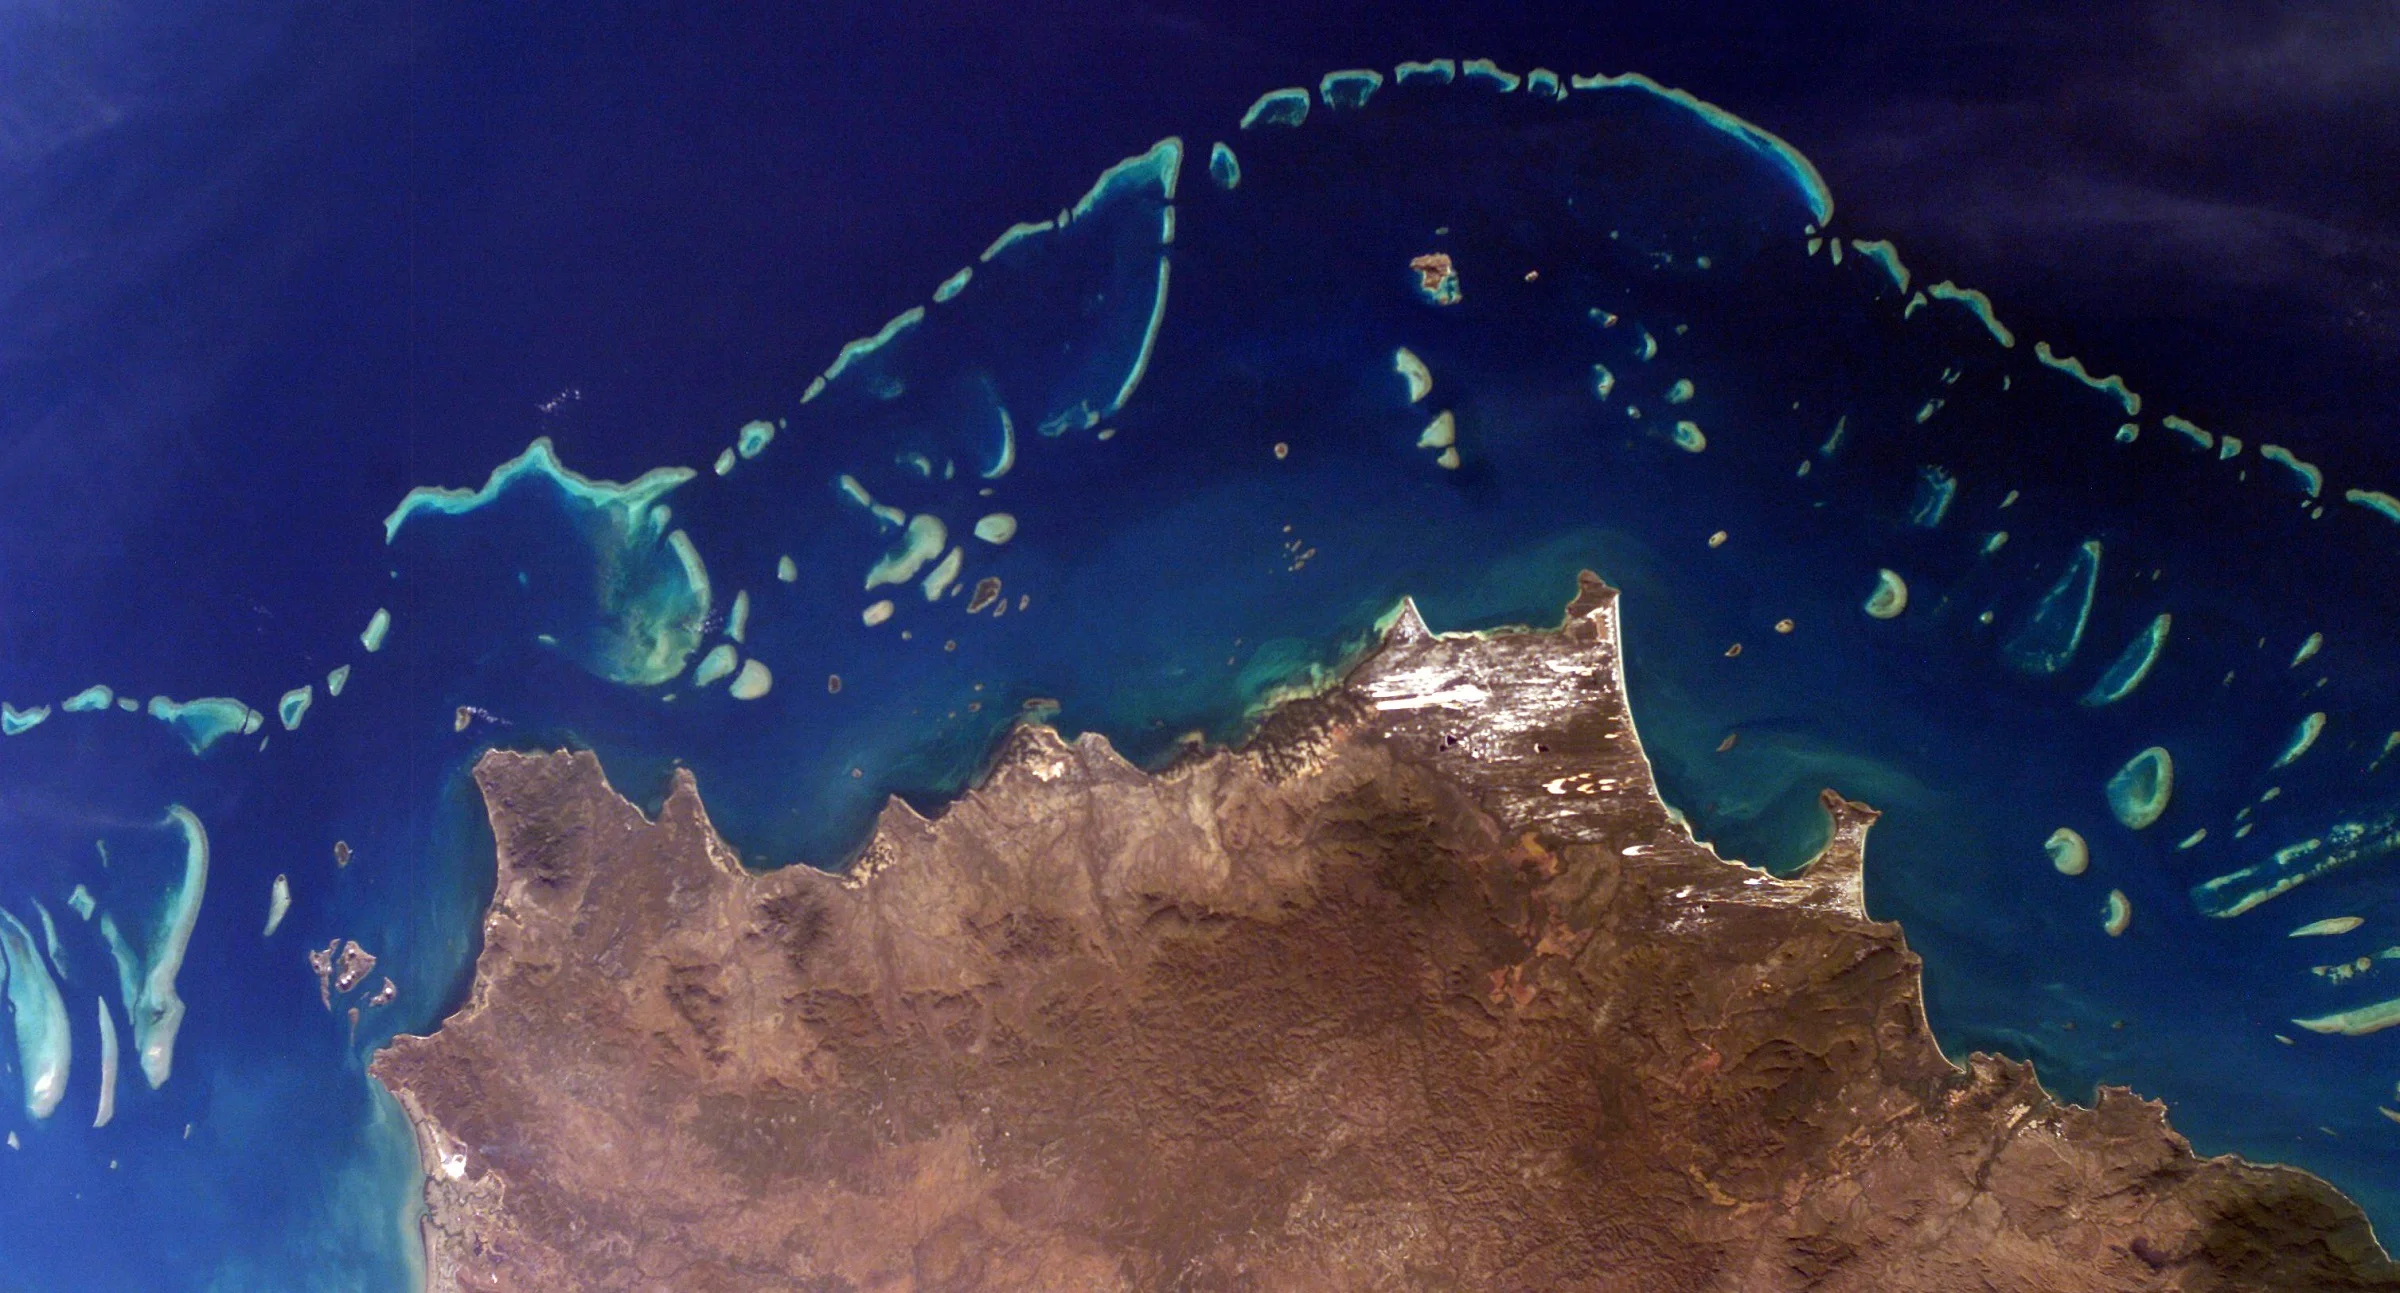

# Getting Started

This setup installs essential libraries for geospatial and remote sensing workflows. requests allows you to download data from online APIs, while shapely provides tools for manipulating geometric shapes like polygons and points. rasterio handles raster data such as satellite imagery, and fiona enables reading vector files like shapefiles or GeoPackages. CodeCarbon will allow us to track emissions for our most computationally heavy tasks, such as model training. Finally, tqdm adds progress bars to loops, making long-running tasks easier to track.

In [ ]:
# ---------------------- Install Dependencies ----------------------
!pip -q install requests shapely rasterio tqdm fiona codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 716.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.16.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


Mount your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Retreival

Now we will read in some useful functions for obtaining our Sentinel-2 data. Once the functions have been read in you will be prompted to input your Copernicus Data Space Ecosystem username and password.

In [ ]:
# ------------------------- 1. Imports ------------------------------
import os, zipfile, requests, warnings
import numpy as np, pandas as pd, rasterio
from shapely.geometry import Polygon
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

# ---------------------- 2. Credentials -----------------------------
from getpass import getpass
username = input("Copernicus username: ")
password = getpass("Copernicus password: ")

# ------------------ 3. Copernicus token helpers --------------------
def get_tokens(user, pwd):
    url  = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {"grant_type":"password","username":user,"password":pwd,"client_id":"cdse-public"}
    return requests.post(url, data=data, timeout=60).json()

def refresh_atoken(rtoken):
    url  = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {"grant_type":"refresh_token","refresh_token":rtoken,"client_id":"cdse-public"}
    return requests.post(url, data=data, timeout=60).json()

tokens = get_tokens(username, password)
atok, rtok = tokens["access_token"], tokens["refresh_token"]

def api_call(url, method="GET"):
    global atok, rtok
    hdr = {"Authorization": f"Bearer {atok}"}
    r   = requests.request(method, url, headers=hdr, timeout=120)
    if r.status_code in (401,403):
        new = refresh_atoken(rtok)
        atok = new["access_token"]
        rtok = new.get("refresh_token", rtok)
        hdr  = {"Authorization": f"Bearer {atok}"}
        r    = requests.request(method, url, headers=hdr, timeout=120)
    r.raise_for_status()
    return r

# ---------- 4. Query Sentinel-2 MSI L2A scenes -------------
def query_s2(start, end, wkt, max_items=100, max_cloud_pct=1):
    # 1) remove extra space in WKT to match "POLYGON((...))" syntax
    wkt_clean = wkt.replace("POLYGON ((", "POLYGON((").replace("))", "))")

    # 2) build all clauses, using 'cloudCover' attribute
    clauses = [
        "Collection/Name eq 'SENTINEL-2'",
        "Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/Value eq 'S2MSI2A')",
        f"Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/Value lt {max_cloud_pct})",
        f"ContentDate/Start gt {start}T00:00:00.000Z",
        f"ContentDate/Start lt {end}T23:59:59.999Z",
        f"OData.CSC.Intersects(area=geography'SRID=4326;{wkt_clean}')"
    ]
    filter_str = " and ".join(clauses)

    # 3) quote the whole filter once
    url = (
        "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
        f"?$filter={requests.utils.quote(filter_str)}"
        f"&$top={max_items}"
    )

    rows, next_url = [], url
    while next_url:
        js = api_call(next_url).json()
        rows.extend(js["value"])
        next_url = js.get("@odata.nextLink")
    return pd.DataFrame(rows)

# ------------------ 5. Download & extract ----------------------------
DL_DIR = "s2_tiles"
os.makedirs(DL_DIR, exist_ok=True)

def download_and_extract(pid, name, out_base=DL_DIR):
    zip_path = os.path.join(out_base, f"{name}.zip")
    folder   = os.path.join(out_base, name)
    if not os.path.isdir(folder):
        # download
        url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({pid})/$value"
        with api_call(url, "GET") as r, open(zip_path, "wb") as f:
            for chunk in r.iter_content(256_000):
                f.write(chunk)
        # unzip
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(folder)
    return folder

# --------- 6. Load & save only 10 m bands per tile ----------
def save_10m_bands(tile_folder, bands=("B02","B03","B04","B08")):
    out_numpy = {}
    for root, _, files in os.walk(tile_folder):
        for f in files:
            for b in bands:
                if f.endswith(f"{b}_10m.jp2"):
                    with rasterio.open(os.path.join(root, f)) as src:
                        arr = src.read(1).astype("float32") / 10000.0
                    out_numpy[b] = arr
    for b, arr in out_numpy.items():
        np.save(os.path.join(tile_folder, f"{b}_10m.npy"), arr)
        del arr
    print(f"Saved bands {list(out_numpy)} for {os.path.basename(tile_folder)}")

Copernicus username: jonomclennan@gmail.com
Copernicus password: ··········


With our functions read in we are now ready to extract some data.

This code below will download two adjacent, nearly cloudless tiles between the specified dates. This approach facilitates the most precise classification of our reefs, and allows us to roll our our model on untrained areas without worrying about factors like differing solar zenith angle between observations.

We focus on the four 10 m Sentinel-2 bands: blue, green, red, and near-infrared (NIR). These provide the ideal spectral combination for reef classification—blue and green penetrate shallow water to reveal reef flats and lagoons, while red and NIR help distinguish land, vegetation, and benthic cover. Together, they enable both water masking (e.g., via NDWI) and geomorphic feature detection, all while maintaining high spatial detail.

In [ ]:
# ---------------------- 6. Define two reef ROIs & date window ----------------------
from shapely.geometry import Polygon
import os
from tqdm.notebook import tqdm

reef_rois = {
    "reef_loc1": Polygon([
        (145.50, -14.82),
        (145.50, -14.84),
        (145.52, -14.84),
        (145.52, -14.82),
    ]).wkt,
    "reef_loc2": Polygon([
        (145.55, -15.80),
        (145.55, -15.82),
        (145.57, -15.82),
        (145.57, -15.80),
    ]).wkt,
}
start_date, end_date = "2019-02-01", "2019-04-30"  # bleaching period
DL_DIR = "s2_tiles"
os.makedirs(DL_DIR, exist_ok=True)

# ---------------------- 7. Query 2 scenes per ROI, pick unique ----------------------
df_list = []
used_names = set()

for loc_name, wkt in reef_rois.items():
    # fetch the first 2 low-cloud scenes for this ROI
    candidates = query_s2(start_date, end_date, wkt, max_cloud_pct=1, max_items=2)
    # pick the first one whose Name we haven't used yet
    for _, row in candidates.iterrows():
        if row["Name"] not in used_names:
            used_names.add(row["Name"])
            row["Location"] = loc_name
            df_list.append(row)
            break
    else:
        raise RuntimeError(f"No unique low-cloud tile found for {loc_name}")

df_tiles = pd.DataFrame(df_list)
print(f"Processing {len(df_tiles)} distinct tiles with <1% cloud…")

# ---------------------- 8. Download, extract & save 10m bands ----------------------
for _, row in tqdm(df_tiles.iterrows(), total=len(df_tiles), desc="Tiles"):
    pid, name = row["Id"], row["Name"]
    tile_folder = download_and_extract(pid, name, out_base=DL_DIR)
    save_10m_bands(tile_folder)

print("Done: two unique low-cloud tiles downloaded and saved.")

Processing 2 distinct tiles with <1% cloud…


Tiles:   0%|          | 0/2 [00:00<?, ?it/s]

Saved bands ['B08', 'B03', 'B02', 'B04'] for S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE
Saved bands ['B08', 'B04', 'B03', 'B02'] for S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE
Done: two unique low-cloud tiles downloaded and saved.


Now we will combine the blue, green and red bands to produce a true colour image of our two tiles for a quick visual inspection.

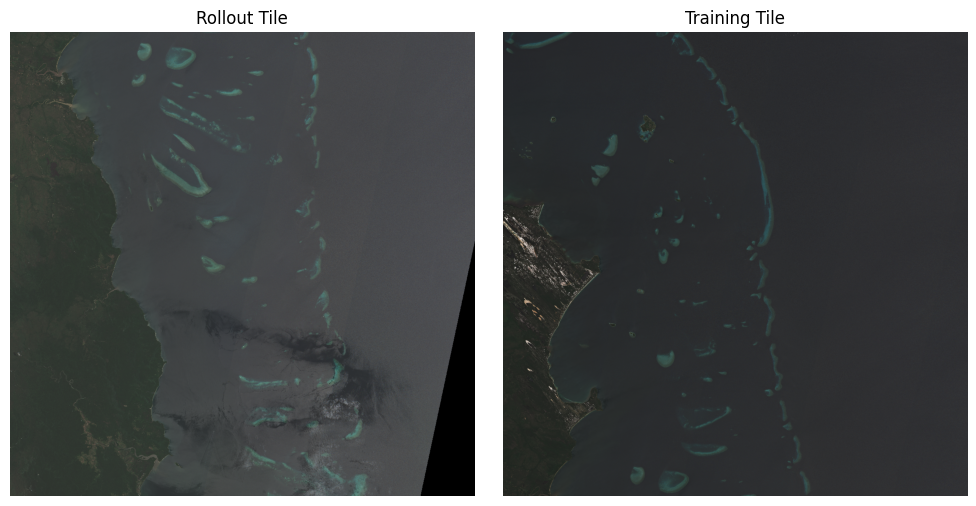

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def display_tile_rgb(tile_path, scale=0.1, vmax=None, title=None):
    """
    Load Sentinel-2 bands B04 (red), B03 (green), B02 (blue) via memory-map,
    downsample by `scale`, normalize, and plot.

    Parameters
    ----------
    tile_path : str
        Path to the .SAFE folder containing B02_10m.npy, B03_10m.npy, B04_10m.npy
    scale : float
        Fraction of pixels to keep in each direction (e.g. 0.1 = 10% → 1/10th resolution)
    vmax : int or None
        Optional upper clip value for reflectance (if you know the data range,
        e.g. 10000); if None, auto-scale from min–max.
    title : str or None
        Title to display on the subplot. If None, uses folder name.
    """
    # memory-map the three bands
    blue  = np.load(os.path.join(tile_path, 'B02_10m.npy'), mmap_mode='r')
    green = np.load(os.path.join(tile_path, 'B03_10m.npy'), mmap_mode='r')
    red   = np.load(os.path.join(tile_path, 'B04_10m.npy'), mmap_mode='r')

    # compute integer step so we keep roughly `scale*100%` of pixels
    step = max(1, int(1/scale))

    # slice every `step`th pixel in each axis
    red_ds   = red[::step, ::step]
    green_ds = green[::step, ::step]
    blue_ds  = blue[::step, ::step]

    # stack into H×W×3 (RGB order)
    rgb = np.dstack((red_ds, green_ds, blue_ds)).astype(np.float32)

    # optional clipping for extreme values
    if vmax is not None:
        rgb = np.clip(rgb, 0, vmax)

    # normalize to [0,1]
    mn, mx = rgb.min(), rgb.max()
    rgb = (rgb - mn) / (mx - mn + 1e-6)

    # plot
    plt.imshow(rgb)
    if title is None:
        plt.title(os.path.basename(tile_path))
    else:
        plt.title(title)
    plt.axis('off')


if __name__ == '__main__':
    # list your two SAFE folders here
    tiles = [
        '/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE',
        '/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE',
    ]

    # corresponding titles for each plot
    titles = ['Rollout Tile', 'Training Tile']

    # make a figure with one subplot per tile
    plt.figure(figsize=(10, 5))
    for i, (t, title) in enumerate(zip(tiles, titles), 1):
        plt.subplot(1, len(tiles), i)
        display_tile_rgb(t, scale=0.1, vmax=10000, title=title)
    plt.tight_layout()
    plt.show()

# Creating a Baseline using NDWI:

With our data downloaded, one of the simplest ways to pop out our reefs is by using the Normalised Difference Water Index or NDWI 1996 by S.K. McFeeters. It is calculated for each pixel as follows:

$$
\mathrm{NDWI} = \frac{G - \mathrm{NIR}}{G + \mathrm{NIR}}
$$

Here G is the green band value, with NIR being the Near Infrared band, corresponding respectively to B03 and B08 in our code. We have chosen our reef mask to be any pixel which fits the requirement:

$$
0.1 < \mathrm{NDWI} < 0.5
$$

NDWI values above 0.5 typically indicate deep or open water, where NIR reflectance is strongly absorbed due to water’s high attenuation in the near-infrared, while the green band reflects moderately. This yields a large numerator in the NDWI formula, pushing values upward.

Conversely, land and dry reef surfaces tend to reflect strongly in both green and NIR, especially over vegetation or bare rock, reducing the contrast between the two bands and lowering the NDWI.

NDWI masks for both tiles are calculated and plotted below:

rollout tile: S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE
training tile: S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE


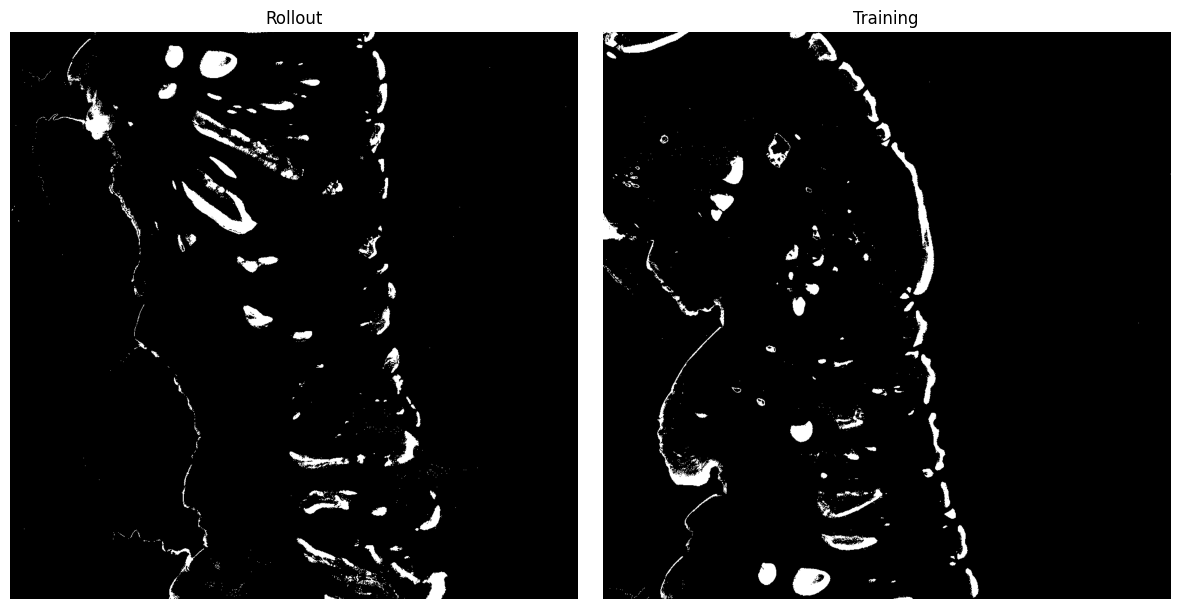

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc

# — your two SAFE directories —
tile_dirs = [
    Path("/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE"),
    Path("/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE"),
]

# all bands filenames
bands = {
    "blue": "B02_10m.npy",
    "green": "B03_10m.npy",
    "red": "B04_10m.npy",
    "nir": "B08_10m.npy",
}

# Phase 1: determine the downsampled (every‐10th) shape for each tile
ds_shapes = []
for td in tile_dirs:
    mm = np.load(td / bands["blue"], mmap_mode="r")
    h, w = mm.shape
    ds_shapes.append(((h + 9)//10, (w + 9)//10))
    del mm

# common downsampled size
h_ds, w_ds = map(min, zip(*ds_shapes))

# assign labels to each tile
labels = ["rollout", "training"]

# Phase 2: load, slice, compute NDWI mask, plot, cleanup
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (label, td) in zip(axes, zip(labels, tile_dirs)):
    # print the labeled tile name
    print(f"{label} tile: {td.name}")

    # mmap each band
    mmaps = {name: np.load(td / fname, mmap_mode="r") for name, fname in bands.items()}

    # slice + downsample: take rows 0…h_ds*10 stepping 10, same for cols
    slices = {
        name: mm[:h_ds*10:10, :w_ds*10:10].astype(np.float32)
        for name, mm in mmaps.items()
    }

    # compute NDWI = (green - nir) / (green + nir)
    g = slices["green"]
    nir = slices["nir"]
    ndwi = (g - nir) / (g + nir + 1e-6)
    mask = (ndwi >= 0.1) & (ndwi <= 0.5)

    ax.imshow(mask, cmap="gray")
    ax.set_title(f"{label.capitalize()}")
    ax.axis("off")

    # tidy up
    del mmaps, slices, g, nir, ndwi, mask
    gc.collect()

plt.tight_layout()
plt.show()

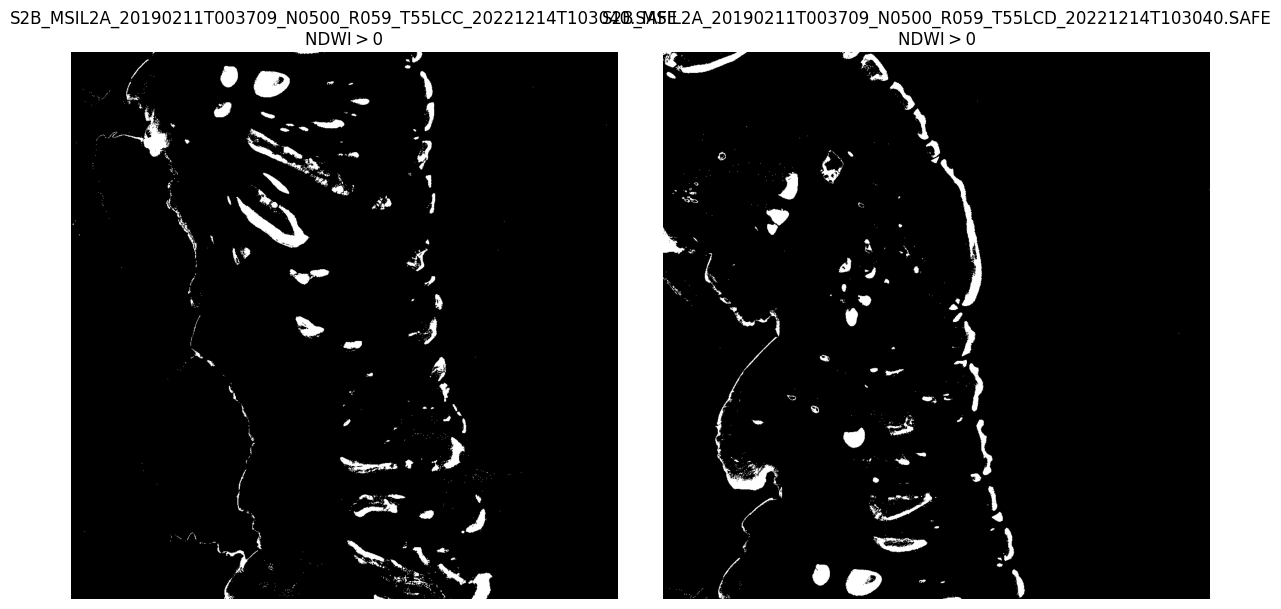

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc

# — your two SAFE directories —
tile_dirs = [
    Path("/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE"),
    Path("/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE"),
]

# all bands filenames
bands = {
    "blue": "B02_10m.npy",
    "green": "B03_10m.npy",
    "red": "B04_10m.npy",
    "nir": "B08_10m.npy",
}

# Phase 1: determine the downsampled (every-10th) shape for each tile
ds_shapes = []
for td in tile_dirs:
    mm = np.load(td / bands["blue"], mmap_mode="r")
    h, w = mm.shape
    ds_shapes.append(((h + 9)//10, (w + 9)//10))
    del mm

# common downsampled size
h_ds, w_ds = map(min, zip(*ds_shapes))

# Phase 2: load, slice, compute NDWI mask, plot, cleanup
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, td in zip(axes, tile_dirs):
    # mmap each band
    mmaps = {name: np.load(td / fname, mmap_mode="r") for name, fname in bands.items()}

    # slice + downsample: take rows 0…h_ds*10 stepping 10, same for cols
    slices = {
        name: mm[:h_ds*10:10, :w_ds*10:10].astype(np.float32)
        for name, mm in mmaps.items()
    }

    # compute NDWI = (green - nir) / (green + nir)
    g = slices["green"]
    nir = slices["nir"]
    ndwi = (g - nir) / (g + nir + 1e-6)
    mask = (ndwi >= 0.1) & (ndwi <= 0.5)

    ax.imshow(mask, cmap="gray")
    ax.set_title(f"{td.name}\nNDWI > 0")
    ax.axis("off")

    # tidy up
    del mmaps, slices, g, nir, ndwi, mask
    gc.collect()

plt.tight_layout()
plt.show()

# Creating Training Data for our CNN

Now that we've downloaded our Sentinel-2 tiles, we stack the relevant 10 m bands (B02, B03, B04, B08) into 4-channel image cubes for each scene, ready for analysis and model input.

In [ ]:
# === Stack and save cubes for both tiles with custom names ===
import os
import numpy as np

# 1. Point this to where your tiles live
base_dir = "s2_tiles"

# 2. Discover the two tile folders
tile_dirs = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
])[:2]

# 3. Specify the 10 m bands you want to stack
bands = ["B02", "B03", "B04", "B08"]

# 4. Loop over each tile, load, stack, and save with specific names
for tile in tile_dirs:
    tile_path = os.path.join(base_dir, tile)
    arrays = []
    for b in bands:
        fn = os.path.join(tile_path, f"{b}_10m.npy")
        arr = np.load(fn)            # shape H×W
        arrays.append(arr)
    cube = np.stack(arrays, axis=-1)  # shape H×W×4
    print(f"{tile}: stacked cube shape = {cube.shape}")

    # 5. Determine output filename
    if "T55LCC" in tile:
        out_name = "stacked_cube_gen.npy"
    else:
        out_name = "stacked_cube.npy"

    # 6. Save locally
    out_local = os.path.join(base_dir, out_name)
    np.save(out_local, cube)

    # 7. Also save to your Drive folder
    out_drive = os.path.expanduser(
        f"~/MyDrive/AI4EO/Final_Project/{out_name}"
    )
    os.makedirs(os.path.dirname(out_drive), exist_ok=True)
    np.save(out_drive, cube)

print("Done: stacked_cube and stacked_cube_gen saved.")

S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE: stacked cube shape = (10980, 10980, 4)
S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE: stacked cube shape = (10980, 10980, 4)
Done: stacked_cube and stacked_cube_gen saved.


Now we will start working on creating training data for IRIS - This snippet lets us zoom in on specific regions in our training tile so that we can extract interesting regions for training

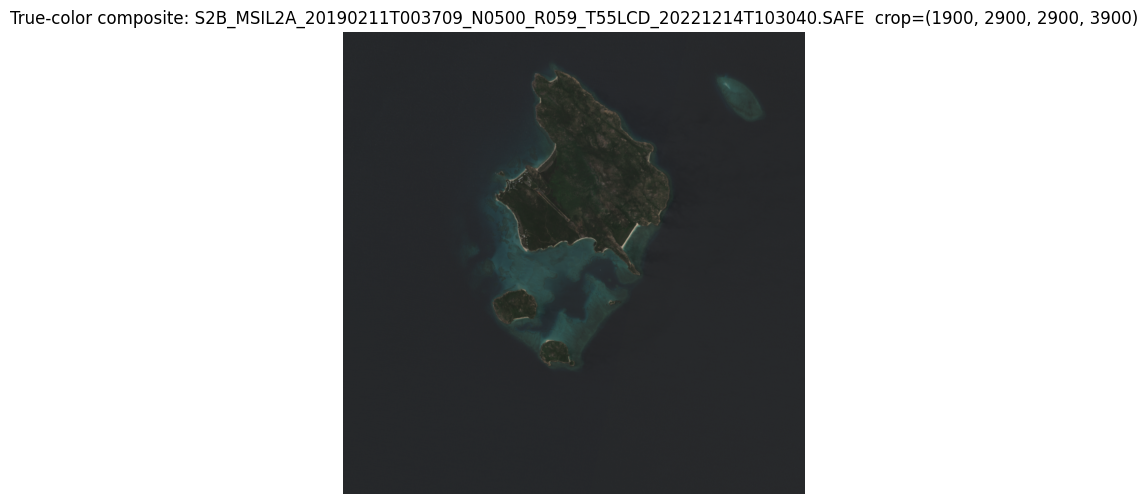

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_truecolor(tile_path, crop_window=None, vmin=0, vmax=1.0):
    """
    Plot a true‐color composite from a Sentinel‐2 tile folder, optionally cropped.

    Args:
      tile_path (str): path to the .SAFE folder containing B02_10m.npy … B08_10m.npy
      crop_window (tuple or None): (y0, y1, x0, x1) pixel indices to crop to
      vmin, vmax (float): display stretch
    """
    # load bands
    b2 = np.load(os.path.join(tile_path, "B02_10m.npy"))
    b3 = np.load(os.path.join(tile_path, "B03_10m.npy"))
    b4 = np.load(os.path.join(tile_path, "B04_10m.npy"))

    # stack to RGB
    rgb = np.dstack([b4, b3, b2])

    # apply crop if requested
    if crop_window is not None:
        y0, y1, x0, x1 = crop_window
        rgb = rgb[y0:y1, x0:x1]

    # plot
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb, vmin=vmin, vmax=vmax)
    plt.axis("off")
    title = os.path.basename(tile_path)
    if crop_window:
        title += f"  crop={crop_window}"
    plt.title(f"True‐color composite: {title}")
    plt.show()


# ------------------ USAGE ------------------

# 1) point to your base dir & pick a tile
base_dir = "s2_tiles"
tiles = [d for d in os.listdir(base_dir)
         if os.path.isdir(os.path.join(base_dir, d))]
tile = tiles[0]   # or change index
tile_path = os.path.join(base_dir, tile)

# 2) set your crop window here (y0, y1, x0, x1), or None for full image
#    tweak these values to zoom in/out and trial different ROIs
crop_window = 1900, 2900, 2900, 3900

# 3) call the plot function
plot_truecolor(tile_path, crop_window=crop_window, vmin=0, vmax=0.2)

Save your identified interesting regions as .npy files in a local folder and proceed to training with IRIS.

In [ ]:
import numpy as np

# 1) load the full cube in memory-mapped mode
cube = np.load('/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube.npy', mmap_mode='r')
h, w, b = cube.shape
print("Full cube:", cube.shape)

# 2) define your crop box (row_min, row_max, col_min, col_max)
r0, r1, c0, c1 = 1900, 2900, 2900, 3900 ### Lizard Island location         ###
#r0, r1, c0, c1 = 3300, 4300, 200, 1200  ### Shallow Coastal Water location ###
#r0, r1, c0, c1 = 1500, 2500, 5000, 6000 ### Horseshoe Reef location        ###
#r0, r1, c0, c1 = 7500, 8500, 3500, 4500 ### Forraster Reef                 ###
#r0, r1, c0, c1 = 7000, 8000, 1000, 2000 ### Micivor River opening          ###
#r0, r1, c0, c1 = 2500, 3500, 2000, 3000 ### Eyrie and Martin Reef          ###
#r0, r1, c0, c1 = 9000, 10000, 9000, 10000

# 3) slice out the sub-cube
sub = cube[r0:r1, c0:c1, :]      # shape will be (r1-r0, c1-c0, 4)
print("Sub-cube:", sub.shape)

# 4) save that smaller chunk
np.save('/content/s2_tiles/reefimage6.npy', sub)
print("Wrote reefimage.npy")

Full cube: (10980, 10980, 4)
Sub-cube: (1000, 1000, 4)
Wrote reefimage.npy


Below is an example mask for Lizard Island created in IRIS, one of the regions of interest chosen for training. Blue regions are shallow sand, yellow is deep water, red is land and white are reef flats and lagoons, another class not shown here is sediment/turbid sand, which runs off the coastal areas of the great barrier reef. Once your masks are complete, upload them with your configuration file to your google drive and proceed with creating balanced training data.

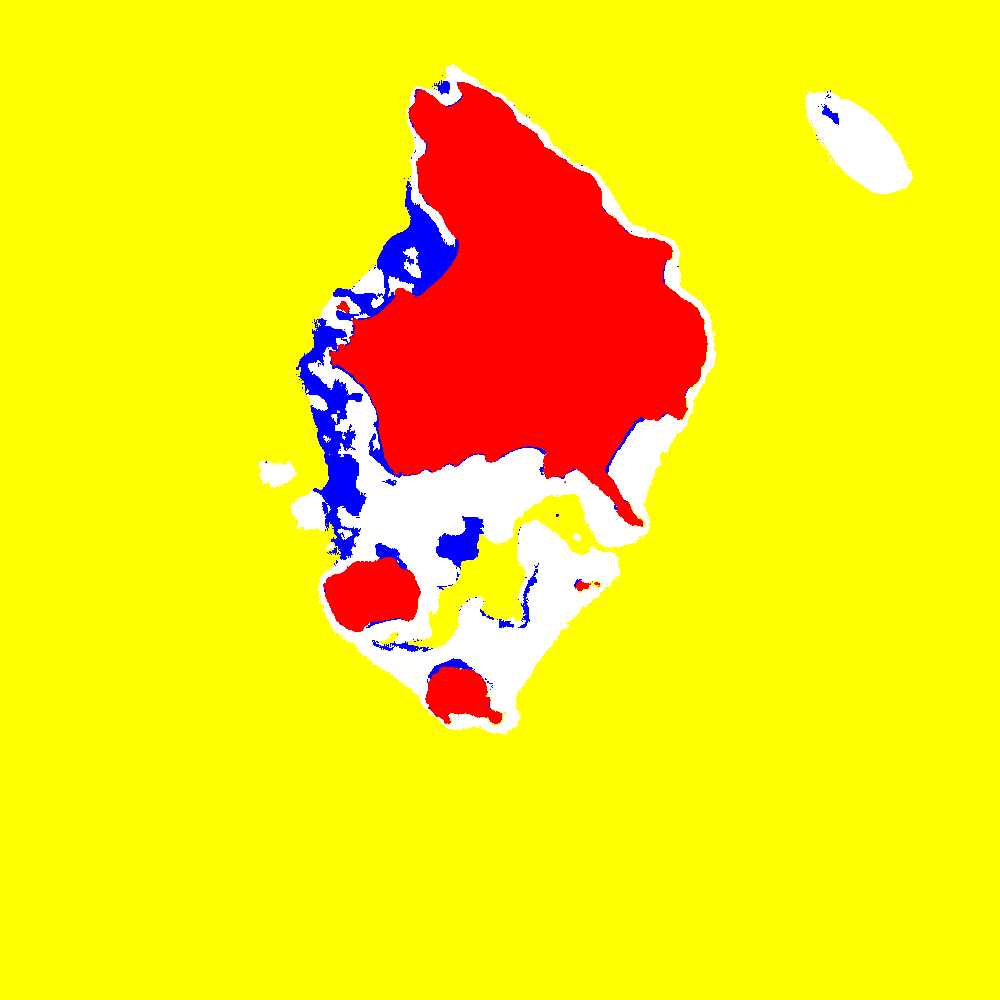

We now extract balanced training and testing datasets by sampling fixed-size image patches (11x11) from labeled reef regions, using memmaps for efficiency and stratified splitting to preserve class distribution.

In [ ]:
import os
import numpy as np
import cv2
import json
from sklearn.model_selection import train_test_split

# ─── Configuration ────────────────────────────────────────────────────────────
IMAGE_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube.npy'
MASK_PATHS  = {
    'l': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask0.png',
    'c': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask1.png',
    'b': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask2.png',
    'd': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask3.png',
    'e': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask4.png',
}
BBOX        = {
    'l': (2900, 1900, 3900, 2900),
    'c': (5000, 1500, 6000, 2500),
    'b': (3500, 7500, 4500, 8500),
    'd': (1000, 7000, 2000, 8000),
    'e': ( 200, 3300, 1200, 4300),
}
CONFIG_PATH = '/content/drive/MyDrive/AI4EO/Final_Project/config_reef.json'
OUT_DIR     = '/content/drive/MyDrive/AI4EO/Final_Project/TrainingData/test_run'
PATCH_SIZE  = 11
OFFSET      = PATCH_SIZE // 2
TEST_SIZE   = 0.1

os.makedirs(OUT_DIR, exist_ok=True)

# ─── Helpers ───────────────────────────────────────────────────────────────────
cube = np.load(IMAGE_PATH)  # (H, W, 4)

with open(CONFIG_PATH) as f:
    cfg = json.load(f)
classes    = cfg['classes']
colour2idx = {tuple(c['colour'][:3]): i for i, c in enumerate(classes)}

def rgb_to_labels(mask_rgb):
    h, w = mask_rgb.shape[:2]
    lbl  = np.zeros((h, w), dtype=np.int8)
    for rgb, idx in colour2idx.items():
        lbl[np.all(mask_rgb[..., :3] == rgb, axis=-1)] = idx
    return lbl

# ─── PASS 1: count total patches & per-class population ───────────────────────
total_patches = 0
class_counts  = np.zeros(len(classes), dtype=np.int64)

for cid, mask_path in MASK_PATHS.items():
    x0, y0, x1, y1 = BBOX[cid]
    roi_h, roi_w  = (y1 - y0), (x1 - x0)
    if roi_h < PATCH_SIZE or roi_w < PATCH_SIZE:
        raise ValueError(f"ROI {cid} too small for {PATCH_SIZE}")

    n_patches = (roi_h - 2*OFFSET) * (roi_w - 2*OFFSET)
    total_patches += n_patches

    mask_bgr  = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask_rgb  = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    lbl2d     = rgb_to_labels(mask_rgb)
    valid     = lbl2d[OFFSET:roi_h-OFFSET, OFFSET:roi_w-OFFSET].ravel()
    uniq, cnt = np.unique(valid, return_counts=True)
    class_counts[uniq] += cnt

min_count = class_counts.min()

# ─── PASS 2: write to memmap & reservoir‐sample per class ────────────────────
X_all = np.memmap(
    os.path.join(OUT_DIR, f'X{PATCH_SIZE}_all.dat'),
    dtype=cube.dtype, mode='w+',
    shape=(total_patches, PATCH_SIZE, PATCH_SIZE, cube.shape[2])
)
y_all = np.memmap(
    os.path.join(OUT_DIR,      'y_all.dat'),
    dtype=np.int8,  mode='w+',
    shape=(total_patches,)
)

reservoir = {cls: [] for cls in range(len(classes))}
seen      = np.zeros(len(classes), dtype=np.int64)

idx = 0
for cid, mask_path in MASK_PATHS.items():
    x0, y0, x1, y1 = BBOX[cid]
    roi            = cube[y0:y1, x0:x1, :]
    h, w           = roi.shape[:2]

    mask_bgr = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    lbl2d    = rgb_to_labels(mask_rgb)

    for i in range(OFFSET, h - OFFSET):
        for j in range(OFFSET, w - OFFSET):
            patch = roi[i-OFFSET : i+OFFSET+1, j-OFFSET : j+OFFSET+1, :]
            cls   = int(lbl2d[i, j])

            X_all[idx] = patch
            y_all[idx] = cls

            seen[cls] += 1
            if len(reservoir[cls]) < min_count:
                reservoir[cls].append(idx)
            else:
                r = np.random.randint(seen[cls])
                if r < min_count:
                    reservoir[cls][r] = idx

            idx += 1

bal_indices = np.concatenate([np.array(reservoir[c]) for c in range(len(classes))])

# ─── PASS 3: stratified split & write final .npy files ──────────────────────
y_bal = y_all[bal_indices]
train_pos, test_pos = train_test_split(
    np.arange(len(bal_indices)),
    test_size=TEST_SIZE,
    stratify=y_bal
)

n_train = len(train_pos)
n_test  = len(test_pos)

X_train = np.memmap(
    os.path.join(OUT_DIR, f'X{PATCH_SIZE}_train.dat'),
    dtype=cube.dtype, mode='w+',
    shape=(n_train, PATCH_SIZE, PATCH_SIZE, cube.shape[2])
)
y_train = np.memmap(
    os.path.join(OUT_DIR,       'y_train.dat'),
    dtype=np.int8,  mode='w+',
    shape=(n_train,)
)
X_test  = np.memmap(
    os.path.join(OUT_DIR, f'X{PATCH_SIZE}_test.dat'),
    dtype=cube.dtype, mode='w+',
    shape=(n_test, PATCH_SIZE, PATCH_SIZE, cube.shape[2])
)
y_test  = np.memmap(
    os.path.join(OUT_DIR,      'y_test.dat'),
    dtype=np.int8,  mode='w+',
    shape=(n_test,)
)

for out_idx, src in enumerate(train_pos):
    real_idx        = bal_indices[src]
    X_train[out_idx] = X_all[real_idx]
    y_train[out_idx] = y_all[real_idx]

for out_idx, src in enumerate(test_pos):
    real_idx       = bal_indices[src]
    X_test[out_idx] = X_all[real_idx]
    y_test[out_idx] = y_all[real_idx]

# save as .npy for compatibility
np.save(os.path.join(OUT_DIR, f'X{PATCH_SIZE}_train.npy'), np.array(X_train))
np.save(os.path.join(OUT_DIR, f'X{PATCH_SIZE}_test.npy'),  np.array(X_test))
np.save(os.path.join(OUT_DIR,              'y_train.npy'), np.array(y_train))
np.save(os.path.join(OUT_DIR,              'y_test.npy'),  np.array(y_test))

print(f"Done—extracted {PATCH_SIZE}×{PATCH_SIZE} patches ({n_train} train, {n_test} test) into {OUT_DIR}")

Done—extracted 11×11 patches (404811 train, 44979 test) into /content/drive/MyDrive/AI4EO/Final_Project/TrainingData/test_run


# Training Our CNN

We now train a convolutional neural network on the extracted patch data, using an appended NDWI channel to enhance spectral sensitivity, class weighting to address imbalance, and early stopping to prevent overfitting. As this is by far the most computationally heavy task, we track our emissions using the CodeCarbon package.

Data shapes: X_train=(404811, 11, 11, 4), X_test=(44979, 11, 11, 4), y_train=(404811,), y_test=(44979,)
Class weight dict: {0: np.float64(2.0000049405894123), 1: np.float64(1.0000024702947061), 2: np.float64(0.999990118943221), 3: np.float64(1.0000024702947061), 4: np.float64(2.0000049405894123)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 11, 32)     │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,877 (296.39 KB)

 Trainable params: 75,493 (294.89 KB)

 Non-trainable params: 384 (1.50 KB)

[codecarbon WARNING @ 14:44:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:44:43] [setup] RAM Tracking...
[codecarbon INFO @ 14:44:43] [setup] CPU Tracking...
[codecarbon WARNING @ 14:44:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:44:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:44:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:44:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:44:45] [setup] GPU Tracking...
[codecarbon INFO @ 14:44:45] No GPU found.
[codecarbon INFO @ 14:44:45] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Epoch 1/50
  68/2847 ━━━━━━━━━━━━━━━━━━━━ 3:51 83ms/step - accuracy: 0.7478 - loss: 0.9904

[codecarbon INFO @ 14:45:00] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:45:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:45:00] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 14:45:00] 0.000219 kWh of electricity used since the beginning.


 225/2847 ━━━━━━━━━━━━━━━━━━━━ 4:00 92ms/step - accuracy: 0.8289 - loss: 0.6939

[codecarbon INFO @ 14:45:15] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:45:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:45:15] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 14:45:15] 0.000437 kWh of electricity used since the beginning.


 382/2847 ━━━━━━━━━━━━━━━━━━━━ 3:50 93ms/step - accuracy: 0.8534 - loss: 0.5984

[codecarbon INFO @ 14:45:30] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:45:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:45:30] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 14:45:30] 0.000656 kWh of electricity used since the beginning.


 500/2847 ━━━━━━━━━━━━━━━━━━━━ 3:57 101ms/step - accuracy: 0.8641 - loss: 0.5559

[codecarbon INFO @ 14:45:45] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:45:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:45:45] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 14:45:45] 0.000875 kWh of electricity used since the beginning.


 609/2847 ━━━━━━━━━━━━━━━━━━━━ 4:01 108ms/step - accuracy: 0.8712 - loss: 0.5274

[codecarbon INFO @ 14:46:00] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:46:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:46:00] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 14:46:00] 0.001094 kWh of electricity used since the beginning.


 717/2847 ━━━━━━━━━━━━━━━━━━━━ 3:59 113ms/step - accuracy: 0.8768 - loss: 0.5050

[codecarbon INFO @ 14:46:15] Energy consumed for RAM : 0.000250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:46:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:46:15] Energy consumed for All CPU : 0.001063 kWh
[codecarbon INFO @ 14:46:15] 0.001312 kWh of electricity used since the beginning.


 822/2847 ━━━━━━━━━━━━━━━━━━━━ 3:55 116ms/step - accuracy: 0.8814 - loss: 0.4868

[codecarbon INFO @ 14:46:30] Energy consumed for RAM : 0.000292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:46:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:46:30] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 14:46:30] 0.001531 kWh of electricity used since the beginning.


 927/2847 ━━━━━━━━━━━━━━━━━━━━ 3:49 119ms/step - accuracy: 0.8852 - loss: 0.4715

[codecarbon INFO @ 14:46:45] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:46:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:46:45] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 14:46:45] 0.001750 kWh of electricity used since the beginning.


 928/2847 ━━━━━━━━━━━━━━━━━━━━ 3:49 119ms/step - accuracy: 0.8853 - loss: 0.4714

[codecarbon INFO @ 14:46:45] 0.003900 g.CO2eq/s mean an estimation of 122.99955714551201 kg.CO2eq/year


1031/2847 ━━━━━━━━━━━━━━━━━━━━ 3:41 122ms/step - accuracy: 0.8886 - loss: 0.4584

[codecarbon INFO @ 14:47:00] Energy consumed for RAM : 0.000375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:47:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:47:00] Energy consumed for All CPU : 0.001594 kWh
[codecarbon INFO @ 14:47:00] 0.001969 kWh of electricity used since the beginning.


1134/2847 ━━━━━━━━━━━━━━━━━━━━ 3:32 124ms/step - accuracy: 0.8914 - loss: 0.4470

[codecarbon INFO @ 14:47:15] Energy consumed for RAM : 0.000417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:47:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:47:15] Energy consumed for All CPU : 0.001771 kWh
[codecarbon INFO @ 14:47:15] 0.002188 kWh of electricity used since the beginning.


1238/2847 ━━━━━━━━━━━━━━━━━━━━ 3:22 126ms/step - accuracy: 0.8940 - loss: 0.4369

[codecarbon INFO @ 14:47:30] Energy consumed for RAM : 0.000458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:47:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:47:30] Energy consumed for All CPU : 0.001948 kWh
[codecarbon INFO @ 14:47:30] 0.002406 kWh of electricity used since the beginning.


1339/2847 ━━━━━━━━━━━━━━━━━━━━ 3:12 128ms/step - accuracy: 0.8962 - loss: 0.4280

[codecarbon INFO @ 14:47:45] Energy consumed for RAM : 0.000500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:47:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:47:45] Energy consumed for All CPU : 0.002125 kWh
[codecarbon INFO @ 14:47:45] 0.002625 kWh of electricity used since the beginning.


1441/2847 ━━━━━━━━━━━━━━━━━━━━ 3:01 129ms/step - accuracy: 0.8982 - loss: 0.4200

[codecarbon INFO @ 14:48:00] Energy consumed for RAM : 0.000541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:48:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:48:00] Energy consumed for All CPU : 0.002302 kWh
[codecarbon INFO @ 14:48:00] 0.002844 kWh of electricity used since the beginning.


1543/2847 ━━━━━━━━━━━━━━━━━━━━ 2:49 130ms/step - accuracy: 0.9000 - loss: 0.4126

[codecarbon INFO @ 14:48:15] Energy consumed for RAM : 0.000583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:48:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:48:15] Energy consumed for All CPU : 0.002479 kWh
[codecarbon INFO @ 14:48:15] 0.003062 kWh of electricity used since the beginning.


1647/2847 ━━━━━━━━━━━━━━━━━━━━ 2:37 131ms/step - accuracy: 0.9017 - loss: 0.4057

[codecarbon INFO @ 14:48:30] Energy consumed for RAM : 0.000625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:48:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:48:30] Energy consumed for All CPU : 0.002656 kWh
[codecarbon INFO @ 14:48:30] 0.003281 kWh of electricity used since the beginning.


1748/2847 ━━━━━━━━━━━━━━━━━━━━ 2:25 132ms/step - accuracy: 0.9032 - loss: 0.3996

[codecarbon INFO @ 14:48:45] Energy consumed for RAM : 0.000666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:48:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:48:45] Energy consumed for All CPU : 0.002833 kWh
[codecarbon INFO @ 14:48:45] 0.003500 kWh of electricity used since the beginning.


1749/2847 ━━━━━━━━━━━━━━━━━━━━ 2:24 132ms/step - accuracy: 0.9032 - loss: 0.3995

[codecarbon INFO @ 14:48:45] 0.003900 g.CO2eq/s mean an estimation of 122.98467548902101 kg.CO2eq/year


1854/2847 ━━━━━━━━━━━━━━━━━━━━ 2:11 133ms/step - accuracy: 0.9047 - loss: 0.3935

[codecarbon INFO @ 14:49:00] Energy consumed for RAM : 0.000708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:49:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:49:00] Energy consumed for All CPU : 0.003010 kWh
[codecarbon INFO @ 14:49:00] 0.003718 kWh of electricity used since the beginning.


1954/2847 ━━━━━━━━━━━━━━━━━━━━ 1:59 134ms/step - accuracy: 0.9060 - loss: 0.3883

[codecarbon INFO @ 14:49:15] Energy consumed for RAM : 0.000750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:49:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:49:15] Energy consumed for All CPU : 0.003188 kWh
[codecarbon INFO @ 14:49:15] 0.003937 kWh of electricity used since the beginning.


2059/2847 ━━━━━━━━━━━━━━━━━━━━ 1:45 134ms/step - accuracy: 0.9073 - loss: 0.3831

[codecarbon INFO @ 14:49:30] Energy consumed for RAM : 0.000791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:49:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:49:30] Energy consumed for All CPU : 0.003365 kWh
[codecarbon INFO @ 14:49:30] 0.004156 kWh of electricity used since the beginning.


2185/2847 ━━━━━━━━━━━━━━━━━━━━ 1:28 133ms/step - accuracy: 0.9087 - loss: 0.3772

[codecarbon INFO @ 14:49:45] Energy consumed for RAM : 0.000833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:49:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:49:45] Energy consumed for All CPU : 0.003542 kWh
[codecarbon INFO @ 14:49:45] 0.004375 kWh of electricity used since the beginning.


2342/2847 ━━━━━━━━━━━━━━━━━━━━ 1:05 131ms/step - accuracy: 0.9103 - loss: 0.3706

[codecarbon INFO @ 14:50:00] Energy consumed for RAM : 0.000875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:50:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:50:00] Energy consumed for All CPU : 0.003719 kWh
[codecarbon INFO @ 14:50:00] 0.004594 kWh of electricity used since the beginning.


2499/2847 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.9119 - loss: 0.3644

[codecarbon INFO @ 14:50:15] Energy consumed for RAM : 0.000916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:50:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:50:15] Energy consumed for All CPU : 0.003896 kWh
[codecarbon INFO @ 14:50:15] 0.004812 kWh of electricity used since the beginning.


2655/2847 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.9132 - loss: 0.3588

[codecarbon INFO @ 14:50:30] Energy consumed for RAM : 0.000958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:50:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:50:30] Energy consumed for All CPU : 0.004073 kWh
[codecarbon INFO @ 14:50:30] 0.005031 kWh of electricity used since the beginning.


2812/2847 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9145 - loss: 0.3536

[codecarbon INFO @ 14:50:45] Energy consumed for RAM : 0.001000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:50:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:50:45] Energy consumed for All CPU : 0.004250 kWh
[codecarbon INFO @ 14:50:45] 0.005250 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:50:45] 0.003901 g.CO2eq/s mean an estimation of 123.0174329294814 kg.CO2eq/year


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 368s 127ms/step - accuracy: 0.9148 - loss: 0.3525 - val_accuracy: 0.8784 - val_loss: 0.5980 - learning_rate: 0.0010
Epoch 2/50
  32/2847 ━━━━━━━━━━━━━━━━━━━━ 4:35 98ms/step - accuracy: 0.9558 - loss: 0.1889

[codecarbon INFO @ 14:51:00] Energy consumed for RAM : 0.001041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:51:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:51:00] Energy consumed for All CPU : 0.004427 kWh
[codecarbon INFO @ 14:51:00] 0.005469 kWh of electricity used since the beginning.


 137/2847 ━━━━━━━━━━━━━━━━━━━━ 5:59 133ms/step - accuracy: 0.9564 - loss: 0.1836

[codecarbon INFO @ 14:51:15] Energy consumed for RAM : 0.001083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:51:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:51:15] Energy consumed for All CPU : 0.004604 kWh
[codecarbon INFO @ 14:51:15] 0.005688 kWh of electricity used since the beginning.


 240/2847 ━━━━━━━━━━━━━━━━━━━━ 5:59 138ms/step - accuracy: 0.9552 - loss: 0.1863

[codecarbon INFO @ 14:51:30] Energy consumed for RAM : 0.001125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:51:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:51:30] Energy consumed for All CPU : 0.004782 kWh
[codecarbon INFO @ 14:51:30] 0.005906 kWh of electricity used since the beginning.


 343/2847 ━━━━━━━━━━━━━━━━━━━━ 5:51 141ms/step - accuracy: 0.9545 - loss: 0.1877

[codecarbon INFO @ 14:51:45] Energy consumed for RAM : 0.001166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:51:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:51:45] Energy consumed for All CPU : 0.004959 kWh
[codecarbon INFO @ 14:51:45] 0.006125 kWh of electricity used since the beginning.


 445/2847 ━━━━━━━━━━━━━━━━━━━━ 5:40 142ms/step - accuracy: 0.9541 - loss: 0.1888

[codecarbon INFO @ 14:52:00] Energy consumed for RAM : 0.001208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:52:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:52:00] Energy consumed for All CPU : 0.005136 kWh
[codecarbon INFO @ 14:52:00] 0.006344 kWh of electricity used since the beginning.


 548/2847 ━━━━━━━━━━━━━━━━━━━━ 5:27 143ms/step - accuracy: 0.9538 - loss: 0.1896

[codecarbon INFO @ 14:52:15] Energy consumed for RAM : 0.001250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:52:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:52:15] Energy consumed for All CPU : 0.005313 kWh
[codecarbon INFO @ 14:52:15] 0.006562 kWh of electricity used since the beginning.


 652/2847 ━━━━━━━━━━━━━━━━━━━━ 5:13 143ms/step - accuracy: 0.9537 - loss: 0.1901

[codecarbon INFO @ 14:52:30] Energy consumed for RAM : 0.001291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:52:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:52:30] Energy consumed for All CPU : 0.005490 kWh
[codecarbon INFO @ 14:52:31] 0.006781 kWh of electricity used since the beginning.


 754/2847 ━━━━━━━━━━━━━━━━━━━━ 5:00 143ms/step - accuracy: 0.9537 - loss: 0.1902

[codecarbon INFO @ 14:52:45] Energy consumed for RAM : 0.001333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:52:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:52:46] Energy consumed for All CPU : 0.005666 kWh
[codecarbon INFO @ 14:52:46] 0.006999 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:52:46] 0.003900 g.CO2eq/s mean an estimation of 122.97960386416219 kg.CO2eq/year


 857/2847 ━━━━━━━━━━━━━━━━━━━━ 4:46 144ms/step - accuracy: 0.9537 - loss: 0.1901

[codecarbon INFO @ 14:53:00] Energy consumed for RAM : 0.001374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:53:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:53:01] Energy consumed for All CPU : 0.005843 kWh
[codecarbon INFO @ 14:53:01] 0.007218 kWh of electricity used since the beginning.


 960/2847 ━━━━━━━━━━━━━━━━━━━━ 4:31 144ms/step - accuracy: 0.9537 - loss: 0.1901

[codecarbon INFO @ 14:53:16] Energy consumed for RAM : 0.001416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:53:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:53:16] Energy consumed for All CPU : 0.006020 kWh
[codecarbon INFO @ 14:53:16] 0.007436 kWh of electricity used since the beginning.


1064/2847 ━━━━━━━━━━━━━━━━━━━━ 4:16 144ms/step - accuracy: 0.9538 - loss: 0.1899

[codecarbon INFO @ 14:53:31] Energy consumed for RAM : 0.001458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:53:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:53:31] Energy consumed for All CPU : 0.006197 kWh
[codecarbon INFO @ 14:53:31] 0.007655 kWh of electricity used since the beginning.


1168/2847 ━━━━━━━━━━━━━━━━━━━━ 4:01 144ms/step - accuracy: 0.9538 - loss: 0.1897

[codecarbon INFO @ 14:53:46] Energy consumed for RAM : 0.001499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:53:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:53:46] Energy consumed for All CPU : 0.006375 kWh
[codecarbon INFO @ 14:53:46] 0.007874 kWh of electricity used since the beginning.


1271/2847 ━━━━━━━━━━━━━━━━━━━━ 3:47 144ms/step - accuracy: 0.9539 - loss: 0.1895

[codecarbon INFO @ 14:54:01] Energy consumed for RAM : 0.001541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:54:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:54:01] Energy consumed for All CPU : 0.006552 kWh
[codecarbon INFO @ 14:54:01] 0.008093 kWh of electricity used since the beginning.


1374/2847 ━━━━━━━━━━━━━━━━━━━━ 3:32 144ms/step - accuracy: 0.9540 - loss: 0.1893

[codecarbon INFO @ 14:54:16] Energy consumed for RAM : 0.001583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:54:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:54:16] Energy consumed for All CPU : 0.006729 kWh
[codecarbon INFO @ 14:54:16] 0.008312 kWh of electricity used since the beginning.


1477/2847 ━━━━━━━━━━━━━━━━━━━━ 3:17 144ms/step - accuracy: 0.9540 - loss: 0.1891

[codecarbon INFO @ 14:54:31] Energy consumed for RAM : 0.001625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:54:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:54:31] Energy consumed for All CPU : 0.006906 kWh
[codecarbon INFO @ 14:54:31] 0.008531 kWh of electricity used since the beginning.


1580/2847 ━━━━━━━━━━━━━━━━━━━━ 3:03 144ms/step - accuracy: 0.9541 - loss: 0.1889

[codecarbon INFO @ 14:54:46] Energy consumed for RAM : 0.001666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:54:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:54:46] Energy consumed for All CPU : 0.007083 kWh
[codecarbon INFO @ 14:54:46] 0.008750 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:54:46] 0.003900 g.CO2eq/s mean an estimation of 123.00405722621545 kg.CO2eq/year


1683/2847 ━━━━━━━━━━━━━━━━━━━━ 2:48 145ms/step - accuracy: 0.9541 - loss: 0.1887

[codecarbon INFO @ 14:55:01] Energy consumed for RAM : 0.001708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:55:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:55:01] Energy consumed for All CPU : 0.007261 kWh
[codecarbon INFO @ 14:55:01] 0.008968 kWh of electricity used since the beginning.


1831/2847 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.9542 - loss: 0.1884

[codecarbon INFO @ 14:55:16] Energy consumed for RAM : 0.001750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:55:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:55:16] Energy consumed for All CPU : 0.007438 kWh
[codecarbon INFO @ 14:55:16] 0.009187 kWh of electricity used since the beginning.


1987/2847 ━━━━━━━━━━━━━━━━━━━━ 1:58 138ms/step - accuracy: 0.9543 - loss: 0.1880

[codecarbon INFO @ 14:55:31] Energy consumed for RAM : 0.001791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:55:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


1988/2847 ━━━━━━━━━━━━━━━━━━━━ 1:58 138ms/step - accuracy: 0.9543 - loss: 0.1880

[codecarbon INFO @ 14:55:31] Energy consumed for All CPU : 0.007615 kWh
[codecarbon INFO @ 14:55:31] 0.009406 kWh of electricity used since the beginning.


2143/2847 ━━━━━━━━━━━━━━━━━━━━ 1:34 135ms/step - accuracy: 0.9544 - loss: 0.1875

[codecarbon INFO @ 14:55:46] Energy consumed for RAM : 0.001833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:55:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:55:46] Energy consumed for All CPU : 0.007792 kWh
[codecarbon INFO @ 14:55:46] 0.009624 kWh of electricity used since the beginning.


2293/2847 ━━━━━━━━━━━━━━━━━━━━ 1:13 132ms/step - accuracy: 0.9545 - loss: 0.1871

[codecarbon INFO @ 14:56:01] Energy consumed for RAM : 0.001874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:56:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:56:01] Energy consumed for All CPU : 0.007969 kWh
[codecarbon INFO @ 14:56:01] 0.009843 kWh of electricity used since the beginning.


2435/2847 ━━━━━━━━━━━━━━━━━━━━ 53s 131ms/step - accuracy: 0.9546 - loss: 0.1868

[codecarbon INFO @ 14:56:16] Energy consumed for RAM : 0.001916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:56:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:56:16] Energy consumed for All CPU : 0.008146 kWh
[codecarbon INFO @ 14:56:16] 0.010062 kWh of electricity used since the beginning.


2537/2847 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.9547 - loss: 0.1865

[codecarbon INFO @ 14:56:31] Energy consumed for RAM : 0.001958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:56:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:56:31] Energy consumed for All CPU : 0.008323 kWh
[codecarbon INFO @ 14:56:31] 0.010280 kWh of electricity used since the beginning.


2639/2847 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.9548 - loss: 0.1863

[codecarbon INFO @ 14:56:46] Energy consumed for RAM : 0.001999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:56:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:56:46] Energy consumed for All CPU : 0.008500 kWh
[codecarbon INFO @ 14:56:46] 0.010499 kWh of electricity used since the beginning.


2640/2847 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.9548 - loss: 0.1862

[codecarbon INFO @ 14:56:46] 0.003900 g.CO2eq/s mean an estimation of 122.97644109302243 kg.CO2eq/year


2744/2847 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9548 - loss: 0.1860

[codecarbon INFO @ 14:57:01] Energy consumed for RAM : 0.002041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:57:01] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 14:57:01] Energy consumed for All CPU : 0.008677 kWh
[codecarbon INFO @ 14:57:01] 0.010719 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9549 - loss: 0.1857

[codecarbon INFO @ 14:57:16] Energy consumed for RAM : 0.002083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:57:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:57:16] Energy consumed for All CPU : 0.008854 kWh
[codecarbon INFO @ 14:57:16] 0.010937 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:31] Energy consumed for RAM : 0.002124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:57:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:57:31] Energy consumed for All CPU : 0.009032 kWh
[codecarbon INFO @ 14:57:31] 0.011156 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 399s 140ms/step - accuracy: 0.9549 - loss: 0.1857 - val_accuracy: 0.8320 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 3/50


[codecarbon INFO @ 14:57:46] Energy consumed for RAM : 0.002166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:57:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:57:46] Energy consumed for All CPU : 0.009209 kWh
[codecarbon INFO @ 14:57:46] 0.011375 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:01] Energy consumed for RAM : 0.002208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:58:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:58:01] Energy consumed for All CPU : 0.009386 kWh
[codecarbon INFO @ 14:58:01] 0.011593 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:16] Energy consumed for RAM : 0.002249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:58:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:58:16] Energy consumed for All CPU : 0.009563 kWh
[codecarbon INFO @ 14:58:16] 0.011812 kWh 

  71/2847 ━━━━━━━━━━━━━━━━━━━━ 7:08 154ms/step - accuracy: 0.9667 - loss: 0.1462

[codecarbon INFO @ 14:58:31] Energy consumed for RAM : 0.002291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:58:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:58:31] Energy consumed for All CPU : 0.009740 kWh
[codecarbon INFO @ 14:58:31] 0.012031 kWh of electricity used since the beginning.


 175/2847 ━━━━━━━━━━━━━━━━━━━━ 6:36 148ms/step - accuracy: 0.9651 - loss: 0.1506

[codecarbon INFO @ 14:58:46] Energy consumed for RAM : 0.002333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:58:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:58:46] Energy consumed for All CPU : 0.009917 kWh
[codecarbon INFO @ 14:58:46] 0.012250 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:46] 0.003902 g.CO2eq/s mean an estimation of 123.03879991685383 kg.CO2eq/year


 280/2847 ━━━━━━━━━━━━━━━━━━━━ 6:15 146ms/step - accuracy: 0.9646 - loss: 0.1527

[codecarbon INFO @ 14:59:01] Energy consumed for RAM : 0.002374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:59:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:59:01] Energy consumed for All CPU : 0.010094 kWh
[codecarbon INFO @ 14:59:01] 0.012469 kWh of electricity used since the beginning.


 384/2847 ━━━━━━━━━━━━━━━━━━━━ 5:59 146ms/step - accuracy: 0.9642 - loss: 0.1541

[codecarbon INFO @ 14:59:16] Energy consumed for RAM : 0.002416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:59:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:59:16] Energy consumed for All CPU : 0.010272 kWh
[codecarbon INFO @ 14:59:16] 0.012688 kWh of electricity used since the beginning.


 487/2847 ━━━━━━━━━━━━━━━━━━━━ 5:43 146ms/step - accuracy: 0.9640 - loss: 0.1546

[codecarbon INFO @ 14:59:31] Energy consumed for RAM : 0.002458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:59:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:59:31] Energy consumed for All CPU : 0.010449 kWh
[codecarbon INFO @ 14:59:31] 0.012907 kWh of electricity used since the beginning.


 589/2847 ━━━━━━━━━━━━━━━━━━━━ 5:29 146ms/step - accuracy: 0.9638 - loss: 0.1549

[codecarbon INFO @ 14:59:46] Energy consumed for RAM : 0.002500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:59:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:59:46] Energy consumed for All CPU : 0.010626 kWh
[codecarbon INFO @ 14:59:46] 0.013126 kWh of electricity used since the beginning.


 692/2847 ━━━━━━━━━━━━━━━━━━━━ 5:14 146ms/step - accuracy: 0.9636 - loss: 0.1555

[codecarbon INFO @ 15:00:01] Energy consumed for RAM : 0.002541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:00:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:00:01] Energy consumed for All CPU : 0.010803 kWh
[codecarbon INFO @ 15:00:01] 0.013344 kWh of electricity used since the beginning.


 792/2847 ━━━━━━━━━━━━━━━━━━━━ 5:01 147ms/step - accuracy: 0.9634 - loss: 0.1560

[codecarbon INFO @ 15:00:16] Energy consumed for RAM : 0.002583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:00:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:00:16] Energy consumed for All CPU : 0.010980 kWh
[codecarbon INFO @ 15:00:16] 0.013563 kWh of electricity used since the beginning.


 894/2847 ━━━━━━━━━━━━━━━━━━━━ 4:46 147ms/step - accuracy: 0.9632 - loss: 0.1564

[codecarbon INFO @ 15:00:31] Energy consumed for RAM : 0.002625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:00:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:00:31] Energy consumed for All CPU : 0.011157 kWh
[codecarbon INFO @ 15:00:31] 0.013782 kWh of electricity used since the beginning.


 996/2847 ━━━━━━━━━━━━━━━━━━━━ 4:31 147ms/step - accuracy: 0.9631 - loss: 0.1566

[codecarbon INFO @ 15:00:46] Energy consumed for RAM : 0.002666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:00:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:00:46] Energy consumed for All CPU : 0.011335 kWh
[codecarbon INFO @ 15:00:46] 0.014001 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:00:46] 0.003901 g.CO2eq/s mean an estimation of 123.01993753677444 kg.CO2eq/year


1099/2847 ━━━━━━━━━━━━━━━━━━━━ 4:16 147ms/step - accuracy: 0.9630 - loss: 0.1568

[codecarbon INFO @ 15:01:01] Energy consumed for RAM : 0.002708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:01:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:01] Energy consumed for All CPU : 0.011512 kWh
[codecarbon INFO @ 15:01:01] 0.014219 kWh of electricity used since the beginning.


1201/2847 ━━━━━━━━━━━━━━━━━━━━ 4:01 147ms/step - accuracy: 0.9629 - loss: 0.1569

[codecarbon INFO @ 15:01:16] Energy consumed for RAM : 0.002750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:01:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:16] Energy consumed for All CPU : 0.011689 kWh
[codecarbon INFO @ 15:01:16] 0.014438 kWh of electricity used since the beginning.


1311/2847 ━━━━━━━━━━━━━━━━━━━━ 3:43 146ms/step - accuracy: 0.9629 - loss: 0.1570

[codecarbon INFO @ 15:01:31] Energy consumed for RAM : 0.002791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:01:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:31] Energy consumed for All CPU : 0.011866 kWh
[codecarbon INFO @ 15:01:31] 0.014657 kWh of electricity used since the beginning.


1465/2847 ━━━━━━━━━━━━━━━━━━━━ 3:14 141ms/step - accuracy: 0.9629 - loss: 0.1569

[codecarbon INFO @ 15:01:46] Energy consumed for RAM : 0.002833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:01:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:46] Energy consumed for All CPU : 0.012043 kWh
[codecarbon INFO @ 15:01:46] 0.014876 kWh of electricity used since the beginning.


1619/2847 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.9628 - loss: 0.1568

[codecarbon INFO @ 15:02:01] Energy consumed for RAM : 0.002875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:02:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:02:01] Energy consumed for All CPU : 0.012220 kWh
[codecarbon INFO @ 15:02:01] 0.015095 kWh of electricity used since the beginning.


1772/2847 ━━━━━━━━━━━━━━━━━━━━ 2:23 133ms/step - accuracy: 0.9628 - loss: 0.1567

[codecarbon INFO @ 15:02:16] Energy consumed for RAM : 0.002916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:02:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:02:16] Energy consumed for All CPU : 0.012397 kWh
[codecarbon INFO @ 15:02:16] 0.015313 kWh of electricity used since the beginning.


1926/2847 ━━━━━━━━━━━━━━━━━━━━ 2:00 130ms/step - accuracy: 0.9628 - loss: 0.1566

[codecarbon INFO @ 15:02:31] Energy consumed for RAM : 0.002958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:02:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:02:31] Energy consumed for All CPU : 0.012574 kWh
[codecarbon INFO @ 15:02:31] 0.015532 kWh of electricity used since the beginning.


2078/2847 ━━━━━━━━━━━━━━━━━━━━ 1:38 128ms/step - accuracy: 0.9628 - loss: 0.1564

[codecarbon INFO @ 15:02:46] Energy consumed for RAM : 0.002999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:02:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:02:46] Energy consumed for All CPU : 0.012751 kWh
[codecarbon INFO @ 15:02:46] 0.015750 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:02:46] 0.003901 g.CO2eq/s mean an estimation of 123.01817409659137 kg.CO2eq/year


2190/2847 ━━━━━━━━━━━━━━━━━━━━ 1:24 128ms/step - accuracy: 0.9628 - loss: 0.1563

[codecarbon INFO @ 15:03:01] Energy consumed for RAM : 0.003041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:03:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:03:01] Energy consumed for All CPU : 0.012928 kWh
[codecarbon INFO @ 15:03:01] 0.015969 kWh of electricity used since the beginning.


2297/2847 ━━━━━━━━━━━━━━━━━━━━ 1:10 129ms/step - accuracy: 0.9629 - loss: 0.1562

[codecarbon INFO @ 15:03:16] Energy consumed for RAM : 0.003083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:03:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:03:16] Energy consumed for All CPU : 0.013105 kWh
[codecarbon INFO @ 15:03:16] 0.016188 kWh of electricity used since the beginning.


2398/2847 ━━━━━━━━━━━━━━━━━━━━ 58s 130ms/step - accuracy: 0.9629 - loss: 0.1561

[codecarbon INFO @ 15:03:31] Energy consumed for RAM : 0.003124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:03:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:03:31] Energy consumed for All CPU : 0.013282 kWh
[codecarbon INFO @ 15:03:31] 0.016406 kWh of electricity used since the beginning.


2500/2847 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - accuracy: 0.9629 - loss: 0.1560

[codecarbon INFO @ 15:03:46] Energy consumed for RAM : 0.003166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:03:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:03:46] Energy consumed for All CPU : 0.013459 kWh
[codecarbon INFO @ 15:03:46] 0.016625 kWh of electricity used since the beginning.


2603/2847 ━━━━━━━━━━━━━━━━━━━━ 31s 131ms/step - accuracy: 0.9629 - loss: 0.1559

[codecarbon INFO @ 15:04:01] Energy consumed for RAM : 0.003208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:04:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:04:01] Energy consumed for All CPU : 0.013636 kWh
[codecarbon INFO @ 15:04:01] 0.016844 kWh of electricity used since the beginning.


2705/2847 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.9629 - loss: 0.1558

[codecarbon INFO @ 15:04:16] Energy consumed for RAM : 0.003249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:04:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:04:16] Energy consumed for All CPU : 0.013813 kWh
[codecarbon INFO @ 15:04:16] 0.017063 kWh of electricity used since the beginning.


2806/2847 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9629 - loss: 0.1557

[codecarbon INFO @ 15:04:31] Energy consumed for RAM : 0.003291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:04:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:04:31] Energy consumed for All CPU : 0.013990 kWh
[codecarbon INFO @ 15:04:31] 0.017281 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9630 - loss: 0.1557

[codecarbon INFO @ 15:04:46] Energy consumed for RAM : 0.003333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:04:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:04:46] Energy consumed for All CPU : 0.014167 kWh
[codecarbon INFO @ 15:04:46] 0.017500 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:04:46] 0.003901 g.CO2eq/s mean an estimation of 123.00787738312819 kg.CO2eq/year


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 434s 137ms/step - accuracy: 0.9630 - loss: 0.1557 - val_accuracy: 0.8194 - val_loss: 0.7248 - learning_rate: 0.0010
Epoch 4/50


[codecarbon INFO @ 15:05:01] Energy consumed for RAM : 0.003374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:05:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:05:01] Energy consumed for All CPU : 0.014344 kWh
[codecarbon INFO @ 15:05:01] 0.017719 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:05:16] Energy consumed for RAM : 0.003416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:05:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:05:16] Energy consumed for All CPU : 0.014522 kWh
[codecarbon INFO @ 15:05:16] 0.017937 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:05:31] Energy consumed for RAM : 0.003458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:05:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:05:31] Energy consumed for All CPU : 0.014699 kWh
[codecarbon INFO @ 15:05:31] 0.018156 kWh 

  25/2847 ━━━━━━━━━━━━━━━━━━━━ 8:26 179ms/step - accuracy: 0.9646 - loss: 0.1361

[codecarbon INFO @ 15:05:46] Energy consumed for RAM : 0.003499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:05:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:05:46] Energy consumed for All CPU : 0.014876 kWh
[codecarbon INFO @ 15:05:46] 0.018375 kWh of electricity used since the beginning.


 126/2847 ━━━━━━━━━━━━━━━━━━━━ 7:01 155ms/step - accuracy: 0.9654 - loss: 0.1419

[codecarbon INFO @ 15:06:01] Energy consumed for RAM : 0.003541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:06:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:06:01] Energy consumed for All CPU : 0.015053 kWh
[codecarbon INFO @ 15:06:01] 0.018594 kWh of electricity used since the beginning.


 266/2847 ━━━━━━━━━━━━━━━━━━━━ 5:34 130ms/step - accuracy: 0.9654 - loss: 0.1440

[codecarbon INFO @ 15:06:16] Energy consumed for RAM : 0.003582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:06:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:06:16] Energy consumed for All CPU : 0.015230 kWh
[codecarbon INFO @ 15:06:16] 0.018812 kWh of electricity used since the beginning.


 421/2847 ━━━━━━━━━━━━━━━━━━━━ 4:45 118ms/step - accuracy: 0.9657 - loss: 0.1440

[codecarbon INFO @ 15:06:31] Energy consumed for RAM : 0.003624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:06:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:06:31] Energy consumed for All CPU : 0.015407 kWh
[codecarbon INFO @ 15:06:31] 0.019031 kWh of electricity used since the beginning.


 575/2847 ━━━━━━━━━━━━━━━━━━━━ 4:15 112ms/step - accuracy: 0.9657 - loss: 0.1444

[codecarbon INFO @ 15:06:46] Energy consumed for RAM : 0.003666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:06:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:06:46] Energy consumed for All CPU : 0.015584 kWh
[codecarbon INFO @ 15:06:46] 0.019250 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:06:46] 0.003901 g.CO2eq/s mean an estimation of 123.00722808409893 kg.CO2eq/year


 729/2847 ━━━━━━━━━━━━━━━━━━━━ 3:51 109ms/step - accuracy: 0.9657 - loss: 0.1446

[codecarbon INFO @ 15:07:01] Energy consumed for RAM : 0.003707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:07:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:07:01] Energy consumed for All CPU : 0.015761 kWh
[codecarbon INFO @ 15:07:01] 0.019468 kWh of electricity used since the beginning.


 884/2847 ━━━━━━━━━━━━━━━━━━━━ 3:29 107ms/step - accuracy: 0.9657 - loss: 0.1447

[codecarbon INFO @ 15:07:16] Energy consumed for RAM : 0.003749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:07:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:07:16] Energy consumed for All CPU : 0.015938 kWh
[codecarbon INFO @ 15:07:16] 0.019687 kWh of electricity used since the beginning.


1018/2847 ━━━━━━━━━━━━━━━━━━━━ 3:16 108ms/step - accuracy: 0.9656 - loss: 0.1447

[codecarbon INFO @ 15:07:31] Energy consumed for RAM : 0.003791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:07:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:07:31] Energy consumed for All CPU : 0.016115 kWh
[codecarbon INFO @ 15:07:31] 0.019906 kWh of electricity used since the beginning.


1123/2847 ━━━━━━━━━━━━━━━━━━━━ 3:11 111ms/step - accuracy: 0.9656 - loss: 0.1447

[codecarbon INFO @ 15:07:46] Energy consumed for RAM : 0.003832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:07:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:07:46] Energy consumed for All CPU : 0.016292 kWh
[codecarbon INFO @ 15:07:46] 0.020125 kWh of electricity used since the beginning.


1231/2847 ━━━━━━━━━━━━━━━━━━━━ 3:03 113ms/step - accuracy: 0.9657 - loss: 0.1445

[codecarbon INFO @ 15:08:01] Energy consumed for RAM : 0.003874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:08:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:08:01] Energy consumed for All CPU : 0.016470 kWh
[codecarbon INFO @ 15:08:01] 0.020344 kWh of electricity used since the beginning.


1333/2847 ━━━━━━━━━━━━━━━━━━━━ 2:55 116ms/step - accuracy: 0.9657 - loss: 0.1443

[codecarbon INFO @ 15:08:16] Energy consumed for RAM : 0.003916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:08:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:08:16] Energy consumed for All CPU : 0.016647 kWh
[codecarbon INFO @ 15:08:16] 0.020563 kWh of electricity used since the beginning.


1435/2847 ━━━━━━━━━━━━━━━━━━━━ 2:46 118ms/step - accuracy: 0.9657 - loss: 0.1442

[codecarbon INFO @ 15:08:31] Energy consumed for RAM : 0.003957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:08:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:08:31] Energy consumed for All CPU : 0.016824 kWh
[codecarbon INFO @ 15:08:31] 0.020781 kWh of electricity used since the beginning.


1538/2847 ━━━━━━━━━━━━━━━━━━━━ 2:37 120ms/step - accuracy: 0.9657 - loss: 0.1440

[codecarbon INFO @ 15:08:46] Energy consumed for RAM : 0.003999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:08:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:08:46] Energy consumed for All CPU : 0.017001 kWh
[codecarbon INFO @ 15:08:46] 0.021000 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:08:46] 0.003901 g.CO2eq/s mean an estimation of 123.0164210532254 kg.CO2eq/year


1640/2847 ━━━━━━━━━━━━━━━━━━━━ 2:26 122ms/step - accuracy: 0.9657 - loss: 0.1438

[codecarbon INFO @ 15:09:01] Energy consumed for RAM : 0.004041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:09:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:09:01] Energy consumed for All CPU : 0.017178 kWh
[codecarbon INFO @ 15:09:01] 0.021219 kWh of electricity used since the beginning.


1742/2847 ━━━━━━━━━━━━━━━━━━━━ 2:16 123ms/step - accuracy: 0.9658 - loss: 0.1436

[codecarbon INFO @ 15:09:16] Energy consumed for RAM : 0.004082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:09:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:09:16] Energy consumed for All CPU : 0.017355 kWh
[codecarbon INFO @ 15:09:16] 0.021438 kWh of electricity used since the beginning.


1842/2847 ━━━━━━━━━━━━━━━━━━━━ 2:05 125ms/step - accuracy: 0.9658 - loss: 0.1434

[codecarbon INFO @ 15:09:31] Energy consumed for RAM : 0.004124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:09:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:09:31] Energy consumed for All CPU : 0.017532 kWh
[codecarbon INFO @ 15:09:31] 0.021656 kWh of electricity used since the beginning.


1945/2847 ━━━━━━━━━━━━━━━━━━━━ 1:53 126ms/step - accuracy: 0.9658 - loss: 0.1433

[codecarbon INFO @ 15:09:46] Energy consumed for RAM : 0.004166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:09:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:09:46] Energy consumed for All CPU : 0.017709 kWh
[codecarbon INFO @ 15:09:46] 0.021875 kWh of electricity used since the beginning.


2048/2847 ━━━━━━━━━━━━━━━━━━━━ 1:41 127ms/step - accuracy: 0.9658 - loss: 0.1432

[codecarbon INFO @ 15:10:01] Energy consumed for RAM : 0.004207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:10:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:10:01] Energy consumed for All CPU : 0.017887 kWh
[codecarbon INFO @ 15:10:01] 0.022094 kWh of electricity used since the beginning.


2150/2847 ━━━━━━━━━━━━━━━━━━━━ 1:29 128ms/step - accuracy: 0.9659 - loss: 0.1430

[codecarbon INFO @ 15:10:16] Energy consumed for RAM : 0.004249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:10:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:10:16] Energy consumed for All CPU : 0.018064 kWh
[codecarbon INFO @ 15:10:16] 0.022313 kWh of electricity used since the beginning.


2253/2847 ━━━━━━━━━━━━━━━━━━━━ 1:16 129ms/step - accuracy: 0.9659 - loss: 0.1429

[codecarbon INFO @ 15:10:31] Energy consumed for RAM : 0.004291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:10:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:10:31] Energy consumed for All CPU : 0.018241 kWh
[codecarbon INFO @ 15:10:31] 0.022532 kWh of electricity used since the beginning.


2356/2847 ━━━━━━━━━━━━━━━━━━━━ 1:03 129ms/step - accuracy: 0.9659 - loss: 0.1428

[codecarbon INFO @ 15:10:46] Energy consumed for RAM : 0.004332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:10:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:10:46] Energy consumed for All CPU : 0.018418 kWh
[codecarbon INFO @ 15:10:46] 0.022750 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:46] 0.003901 g.CO2eq/s mean an estimation of 123.0249538711184 kg.CO2eq/year


2461/2847 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.9659 - loss: 0.1427

[codecarbon INFO @ 15:11:01] Energy consumed for RAM : 0.004374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:11:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:11:01] Energy consumed for All CPU : 0.018595 kWh
[codecarbon INFO @ 15:11:01] 0.022969 kWh of electricity used since the beginning.


2561/2847 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - accuracy: 0.9659 - loss: 0.1426

[codecarbon INFO @ 15:11:16] Energy consumed for RAM : 0.004416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:11:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:11:16] Energy consumed for All CPU : 0.018772 kWh
[codecarbon INFO @ 15:11:16] 0.023188 kWh of electricity used since the beginning.


2663/2847 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.9660 - loss: 0.1425

[codecarbon INFO @ 15:11:31] Energy consumed for RAM : 0.004457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:11:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:11:31] Energy consumed for All CPU : 0.018949 kWh
[codecarbon INFO @ 15:11:31] 0.023407 kWh of electricity used since the beginning.


2814/2847 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9660 - loss: 0.1424

[codecarbon INFO @ 15:11:46] Energy consumed for RAM : 0.004499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:11:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:11:46] Energy consumed for All CPU : 0.019126 kWh
[codecarbon INFO @ 15:11:46] 0.023625 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 431s 133ms/step - accuracy: 0.9660 - loss: 0.1423 - val_accuracy: 0.8796 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 5/50


[codecarbon INFO @ 15:12:01] Energy consumed for RAM : 0.004541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:12:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:12:01] Energy consumed for All CPU : 0.019303 kWh
[codecarbon INFO @ 15:12:01] 0.023844 kWh of electricity used since the beginning.


 135/2847 ━━━━━━━━━━━━━━━━━━━━ 4:20 96ms/step - accuracy: 0.9679 - loss: 0.1363

[codecarbon INFO @ 15:12:16] Energy consumed for RAM : 0.004582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:12:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:12:16] Energy consumed for All CPU : 0.019481 kWh
[codecarbon INFO @ 15:12:16] 0.024063 kWh of electricity used since the beginning.


 281/2847 ━━━━━━━━━━━━━━━━━━━━ 4:15 100ms/step - accuracy: 0.9677 - loss: 0.1359

[codecarbon INFO @ 15:12:31] Energy consumed for RAM : 0.004624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:12:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:12:31] Energy consumed for All CPU : 0.019658 kWh
[codecarbon INFO @ 15:12:31] 0.024282 kWh of electricity used since the beginning.


 427/2847 ━━━━━━━━━━━━━━━━━━━━ 4:04 101ms/step - accuracy: 0.9677 - loss: 0.1351

[codecarbon INFO @ 15:12:46] Energy consumed for RAM : 0.004666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:12:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:12:46] Energy consumed for All CPU : 0.019835 kWh
[codecarbon INFO @ 15:12:46] 0.024500 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:12:46] 0.003901 g.CO2eq/s mean an estimation of 123.01389806007103 kg.CO2eq/year


 575/2847 ━━━━━━━━━━━━━━━━━━━━ 3:49 101ms/step - accuracy: 0.9677 - loss: 0.1345

[codecarbon INFO @ 15:13:01] Energy consumed for RAM : 0.004707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:13:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:13:01] Energy consumed for All CPU : 0.020012 kWh
[codecarbon INFO @ 15:13:01] 0.024719 kWh of electricity used since the beginning.


 678/2847 ━━━━━━━━━━━━━━━━━━━━ 3:53 108ms/step - accuracy: 0.9679 - loss: 0.1340

[codecarbon INFO @ 15:13:16] Energy consumed for RAM : 0.004749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:13:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:13:16] Energy consumed for All CPU : 0.020189 kWh
[codecarbon INFO @ 15:13:16] 0.024938 kWh of electricity used since the beginning.


 783/2847 ━━━━━━━━━━━━━━━━━━━━ 3:52 112ms/step - accuracy: 0.9680 - loss: 0.1335

[codecarbon INFO @ 15:13:31] Energy consumed for RAM : 0.004791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:13:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:13:31] Energy consumed for All CPU : 0.020366 kWh
[codecarbon INFO @ 15:13:31] 0.025157 kWh of electricity used since the beginning.


 884/2847 ━━━━━━━━━━━━━━━━━━━━ 3:49 117ms/step - accuracy: 0.9681 - loss: 0.1331

[codecarbon INFO @ 15:13:46] Energy consumed for RAM : 0.004832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:13:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:13:46] Energy consumed for All CPU : 0.020543 kWh
[codecarbon INFO @ 15:13:46] 0.025376 kWh of electricity used since the beginning.


 985/2847 ━━━━━━━━━━━━━━━━━━━━ 3:43 120ms/step - accuracy: 0.9681 - loss: 0.1328

[codecarbon INFO @ 15:14:01] Energy consumed for RAM : 0.004874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:14:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:14:01] Energy consumed for All CPU : 0.020720 kWh
[codecarbon INFO @ 15:14:01] 0.025594 kWh of electricity used since the beginning.


1084/2847 ━━━━━━━━━━━━━━━━━━━━ 3:36 123ms/step - accuracy: 0.9681 - loss: 0.1326

[codecarbon INFO @ 15:14:16] Energy consumed for RAM : 0.004916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:14:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:14:16] Energy consumed for All CPU : 0.020897 kWh
[codecarbon INFO @ 15:14:16] 0.025813 kWh of electricity used since the beginning.


1183/2847 ━━━━━━━━━━━━━━━━━━━━ 3:28 125ms/step - accuracy: 0.9682 - loss: 0.1324

[codecarbon INFO @ 15:14:31] Energy consumed for RAM : 0.004957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:14:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:14:31] Energy consumed for All CPU : 0.021074 kWh
[codecarbon INFO @ 15:14:31] 0.026032 kWh of electricity used since the beginning.


1280/2847 ━━━━━━━━━━━━━━━━━━━━ 3:19 127ms/step - accuracy: 0.9682 - loss: 0.1323

[codecarbon INFO @ 15:14:46] Energy consumed for RAM : 0.004999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:14:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:14:46] Energy consumed for All CPU : 0.021252 kWh
[codecarbon INFO @ 15:14:46] 0.026251 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:46] 0.003901 g.CO2eq/s mean an estimation of 123.02521325212383 kg.CO2eq/year


1374/2847 ━━━━━━━━━━━━━━━━━━━━ 3:10 130ms/step - accuracy: 0.9682 - loss: 0.1322

[codecarbon INFO @ 15:15:01] Energy consumed for RAM : 0.005041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:15:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:15:01] Energy consumed for All CPU : 0.021429 kWh
[codecarbon INFO @ 15:15:01] 0.026469 kWh of electricity used since the beginning.


1472/2847 ━━━━━━━━━━━━━━━━━━━━ 3:00 131ms/step - accuracy: 0.9683 - loss: 0.1320

[codecarbon INFO @ 15:15:16] Energy consumed for RAM : 0.005082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:15:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:15:16] Energy consumed for All CPU : 0.021606 kWh
[codecarbon INFO @ 15:15:16] 0.026688 kWh of electricity used since the beginning.


1572/2847 ━━━━━━━━━━━━━━━━━━━━ 2:48 132ms/step - accuracy: 0.9683 - loss: 0.1319

[codecarbon INFO @ 15:15:31] Energy consumed for RAM : 0.005124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:15:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:15:31] Energy consumed for All CPU : 0.021783 kWh
[codecarbon INFO @ 15:15:31] 0.026907 kWh of electricity used since the beginning.


1670/2847 ━━━━━━━━━━━━━━━━━━━━ 2:37 134ms/step - accuracy: 0.9683 - loss: 0.1318

[codecarbon INFO @ 15:15:46] Energy consumed for RAM : 0.005166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:15:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:15:46] Energy consumed for All CPU : 0.021960 kWh
[codecarbon INFO @ 15:15:46] 0.027126 kWh of electricity used since the beginning.


1765/2847 ━━━━━━━━━━━━━━━━━━━━ 2:25 135ms/step - accuracy: 0.9683 - loss: 0.1317

[codecarbon INFO @ 15:16:01] Energy consumed for RAM : 0.005207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:16:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:16:01] Energy consumed for All CPU : 0.022137 kWh
[codecarbon INFO @ 15:16:01] 0.027345 kWh of electricity used since the beginning.


1867/2847 ━━━━━━━━━━━━━━━━━━━━ 2:12 136ms/step - accuracy: 0.9683 - loss: 0.1316

[codecarbon INFO @ 15:16:16] Energy consumed for RAM : 0.005249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:16:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:16:16] Energy consumed for All CPU : 0.022314 kWh
[codecarbon INFO @ 15:16:16] 0.027563 kWh of electricity used since the beginning.


1967/2847 ━━━━━━━━━━━━━━━━━━━━ 1:59 136ms/step - accuracy: 0.9683 - loss: 0.1316

[codecarbon INFO @ 15:16:31] Energy consumed for RAM : 0.005291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:16:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:16:31] Energy consumed for All CPU : 0.022492 kWh
[codecarbon INFO @ 15:16:31] 0.027782 kWh of electricity used since the beginning.


2065/2847 ━━━━━━━━━━━━━━━━━━━━ 1:47 137ms/step - accuracy: 0.9684 - loss: 0.1315

[codecarbon INFO @ 15:16:46] Energy consumed for RAM : 0.005332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:16:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:16:46] Energy consumed for All CPU : 0.022669 kWh
[codecarbon INFO @ 15:16:46] 0.028001 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:16:46] 0.003901 g.CO2eq/s mean an estimation of 123.02026125082963 kg.CO2eq/year


2164/2847 ━━━━━━━━━━━━━━━━━━━━ 1:34 138ms/step - accuracy: 0.9684 - loss: 0.1314

[codecarbon INFO @ 15:17:01] Energy consumed for RAM : 0.005374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:17:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:17:01] Energy consumed for All CPU : 0.022846 kWh
[codecarbon INFO @ 15:17:01] 0.028220 kWh of electricity used since the beginning.


2302/2847 ━━━━━━━━━━━━━━━━━━━━ 1:14 136ms/step - accuracy: 0.9684 - loss: 0.1312

[codecarbon INFO @ 15:17:16] Energy consumed for RAM : 0.005416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:17:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:17:16] Energy consumed for All CPU : 0.023023 kWh
[codecarbon INFO @ 15:17:16] 0.028438 kWh of electricity used since the beginning.


2452/2847 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.9684 - loss: 0.1311

[codecarbon INFO @ 15:17:31] Energy consumed for RAM : 0.005457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:17:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:17:31] Energy consumed for All CPU : 0.023200 kWh
[codecarbon INFO @ 15:17:31] 0.028657 kWh of electricity used since the beginning.


2601/2847 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - accuracy: 0.9685 - loss: 0.1309

[codecarbon INFO @ 15:17:46] Energy consumed for RAM : 0.005499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:17:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:17:46] Energy consumed for All CPU : 0.023377 kWh
[codecarbon INFO @ 15:17:46] 0.028876 kWh of electricity used since the beginning.


2750/2847 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9685 - loss: 0.1308

[codecarbon INFO @ 15:18:01] Energy consumed for RAM : 0.005541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:18:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:18:01] Energy consumed for All CPU : 0.023554 kWh
[codecarbon INFO @ 15:18:01] 0.029095 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9685 - loss: 0.1307

[codecarbon INFO @ 15:18:16] Energy consumed for RAM : 0.005582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:18:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:18:16] Energy consumed for All CPU : 0.023731 kWh
[codecarbon INFO @ 15:18:16] 0.029314 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 380s 133ms/step - accuracy: 0.9685 - loss: 0.1307 - val_accuracy: 0.9514 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 6/50
 105/2847 ━━━━━━━━━━━━━━━━━━━━ 4:43 103ms/step - accuracy: 0.9731 - loss: 0.1173

[codecarbon INFO @ 15:18:31] Energy consumed for RAM : 0.005624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:18:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:18:31] Energy consumed for All CPU : 0.023908 kWh
[codecarbon INFO @ 15:18:31] 0.029532 kWh of electricity used since the beginning.


 207/2847 ━━━━━━━━━━━━━━━━━━━━ 5:30 125ms/step - accuracy: 0.9724 - loss: 0.1182

[codecarbon INFO @ 15:18:46] Energy consumed for RAM : 0.005666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:18:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:18:46] Energy consumed for All CPU : 0.024085 kWh
[codecarbon INFO @ 15:18:46] 0.029751 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:18:46] 0.003901 g.CO2eq/s mean an estimation of 123.01908212137606 kg.CO2eq/year


 308/2847 ━━━━━━━━━━━━━━━━━━━━ 5:35 132ms/step - accuracy: 0.9724 - loss: 0.1176

[codecarbon INFO @ 15:19:01] Energy consumed for RAM : 0.005707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:19:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:19:01] Energy consumed for All CPU : 0.024262 kWh
[codecarbon INFO @ 15:19:01] 0.029970 kWh of electricity used since the beginning.


 407/2847 ━━━━━━━━━━━━━━━━━━━━ 5:34 137ms/step - accuracy: 0.9721 - loss: 0.1178

[codecarbon INFO @ 15:19:16] Energy consumed for RAM : 0.005749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:19:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:19:16] Energy consumed for All CPU : 0.024440 kWh
[codecarbon INFO @ 15:19:16] 0.030188 kWh of electricity used since the beginning.


 506/2847 ━━━━━━━━━━━━━━━━━━━━ 5:27 140ms/step - accuracy: 0.9719 - loss: 0.1183

[codecarbon INFO @ 15:19:31] Energy consumed for RAM : 0.005791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:19:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:19:31] Energy consumed for All CPU : 0.024617 kWh
[codecarbon INFO @ 15:19:31] 0.030407 kWh of electricity used since the beginning.


 606/2847 ━━━━━━━━━━━━━━━━━━━━ 5:17 142ms/step - accuracy: 0.9717 - loss: 0.1186

[codecarbon INFO @ 15:19:46] Energy consumed for RAM : 0.005832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:19:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:19:46] Energy consumed for All CPU : 0.024794 kWh
[codecarbon INFO @ 15:19:46] 0.030626 kWh of electricity used since the beginning.


 704/2847 ━━━━━━━━━━━━━━━━━━━━ 5:06 143ms/step - accuracy: 0.9716 - loss: 0.1189

[codecarbon INFO @ 15:20:01] Energy consumed for RAM : 0.005874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:20:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:20:01] Energy consumed for All CPU : 0.024971 kWh
[codecarbon INFO @ 15:20:01] 0.030845 kWh of electricity used since the beginning.


 804/2847 ━━━━━━━━━━━━━━━━━━━━ 4:54 144ms/step - accuracy: 0.9715 - loss: 0.1191

[codecarbon INFO @ 15:20:16] Energy consumed for RAM : 0.005916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:20:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:20:16] Energy consumed for All CPU : 0.025148 kWh
[codecarbon INFO @ 15:20:16] 0.031063 kWh of electricity used since the beginning.


 902/2847 ━━━━━━━━━━━━━━━━━━━━ 4:42 145ms/step - accuracy: 0.9714 - loss: 0.1194

[codecarbon INFO @ 15:20:32] Energy consumed for RAM : 0.005957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:20:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:20:32] Energy consumed for All CPU : 0.025325 kWh
[codecarbon INFO @ 15:20:32] 0.031282 kWh of electricity used since the beginning.


1000/2847 ━━━━━━━━━━━━━━━━━━━━ 4:29 146ms/step - accuracy: 0.9713 - loss: 0.1197

[codecarbon INFO @ 15:20:47] Energy consumed for RAM : 0.005999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:20:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:20:47] Energy consumed for All CPU : 0.025502 kWh
[codecarbon INFO @ 15:20:47] 0.031501 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:20:47] 0.003900 g.CO2eq/s mean an estimation of 122.99573774352224 kg.CO2eq/year


1096/2847 ━━━━━━━━━━━━━━━━━━━━ 4:17 147ms/step - accuracy: 0.9712 - loss: 0.1200

[codecarbon INFO @ 15:21:02] Energy consumed for RAM : 0.006041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:21:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:21:02] Energy consumed for All CPU : 0.025679 kWh
[codecarbon INFO @ 15:21:02] 0.031720 kWh of electricity used since the beginning.


1195/2847 ━━━━━━━━━━━━━━━━━━━━ 4:03 147ms/step - accuracy: 0.9711 - loss: 0.1201

[codecarbon INFO @ 15:21:17] Energy consumed for RAM : 0.006082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:21:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:21:17] Energy consumed for All CPU : 0.025857 kWh
[codecarbon INFO @ 15:21:17] 0.031939 kWh of electricity used since the beginning.


1292/2847 ━━━━━━━━━━━━━━━━━━━━ 3:49 148ms/step - accuracy: 0.9711 - loss: 0.1203

[codecarbon INFO @ 15:21:32] Energy consumed for RAM : 0.006124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:21:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:21:32] Energy consumed for All CPU : 0.026034 kWh
[codecarbon INFO @ 15:21:32] 0.032158 kWh of electricity used since the beginning.


1390/2847 ━━━━━━━━━━━━━━━━━━━━ 3:35 148ms/step - accuracy: 0.9710 - loss: 0.1204

[codecarbon INFO @ 15:21:47] Energy consumed for RAM : 0.006166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:21:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:21:47] Energy consumed for All CPU : 0.026211 kWh
[codecarbon INFO @ 15:21:47] 0.032377 kWh of electricity used since the beginning.


1475/2847 ━━━━━━━━━━━━━━━━━━━━ 3:25 150ms/step - accuracy: 0.9710 - loss: 0.1204

[codecarbon INFO @ 15:22:02] Energy consumed for RAM : 0.006207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:22:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:22:02] Energy consumed for All CPU : 0.026388 kWh
[codecarbon INFO @ 15:22:02] 0.032595 kWh of electricity used since the beginning.


1574/2847 ━━━━━━━━━━━━━━━━━━━━ 3:10 150ms/step - accuracy: 0.9710 - loss: 0.1205

[codecarbon INFO @ 15:22:17] Energy consumed for RAM : 0.006249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:22:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:22:17] Energy consumed for All CPU : 0.026565 kWh
[codecarbon INFO @ 15:22:17] 0.032814 kWh of electricity used since the beginning.


1674/2847 ━━━━━━━━━━━━━━━━━━━━ 2:55 150ms/step - accuracy: 0.9710 - loss: 0.1205

[codecarbon INFO @ 15:22:32] Energy consumed for RAM : 0.006291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:22:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:22:32] Energy consumed for All CPU : 0.026742 kWh
[codecarbon INFO @ 15:22:32] 0.033033 kWh of electricity used since the beginning.


1802/2847 ━━━━━━━━━━━━━━━━━━━━ 2:34 148ms/step - accuracy: 0.9709 - loss: 0.1205

[codecarbon INFO @ 15:22:47] Energy consumed for RAM : 0.006332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:22:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:22:47] Energy consumed for All CPU : 0.026919 kWh
[codecarbon INFO @ 15:22:47] 0.033252 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:22:47] 0.003901 g.CO2eq/s mean an estimation of 123.01302881931694 kg.CO2eq/year


1949/2847 ━━━━━━━━━━━━━━━━━━━━ 2:09 144ms/step - accuracy: 0.9709 - loss: 0.1205

[codecarbon INFO @ 15:23:02] Energy consumed for RAM : 0.006374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:23:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:23:02] Energy consumed for All CPU : 0.027097 kWh
[codecarbon INFO @ 15:23:02] 0.033470 kWh of electricity used since the beginning.


2075/2847 ━━━━━━━━━━━━━━━━━━━━ 1:50 143ms/step - accuracy: 0.9709 - loss: 0.1206

[codecarbon INFO @ 15:23:17] Energy consumed for RAM : 0.006416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:23:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:23:17] Energy consumed for All CPU : 0.027274 kWh
[codecarbon INFO @ 15:23:17] 0.033689 kWh of electricity used since the beginning.


2214/2847 ━━━━━━━━━━━━━━━━━━━━ 1:28 140ms/step - accuracy: 0.9709 - loss: 0.1206

[codecarbon INFO @ 15:23:32] Energy consumed for RAM : 0.006457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:23:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


2215/2847 ━━━━━━━━━━━━━━━━━━━━ 1:28 140ms/step - accuracy: 0.9709 - loss: 0.1206

[codecarbon INFO @ 15:23:32] Energy consumed for All CPU : 0.027450 kWh
[codecarbon INFO @ 15:23:32] 0.033908 kWh of electricity used since the beginning.


2354/2847 ━━━━━━━━━━━━━━━━━━━━ 1:08 139ms/step - accuracy: 0.9709 - loss: 0.1205

[codecarbon INFO @ 15:23:47] Energy consumed for RAM : 0.006499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:23:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:23:47] Energy consumed for All CPU : 0.027627 kWh
[codecarbon INFO @ 15:23:47] 0.034126 kWh of electricity used since the beginning.


2481/2847 ━━━━━━━━━━━━━━━━━━━━ 50s 137ms/step - accuracy: 0.9708 - loss: 0.1205

[codecarbon INFO @ 15:24:02] Energy consumed for RAM : 0.006540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:24:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:24:02] Energy consumed for All CPU : 0.027804 kWh
[codecarbon INFO @ 15:24:02] 0.034345 kWh of electricity used since the beginning.


2579/2847 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - accuracy: 0.9708 - loss: 0.1205

[codecarbon INFO @ 15:24:17] Energy consumed for RAM : 0.006582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:24:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:24:17] Energy consumed for All CPU : 0.027982 kWh
[codecarbon INFO @ 15:24:17] 0.034564 kWh of electricity used since the beginning.


2675/2847 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.9708 - loss: 0.1204

[codecarbon INFO @ 15:24:32] Energy consumed for RAM : 0.006624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:24:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:24:32] Energy consumed for All CPU : 0.028158 kWh
[codecarbon INFO @ 15:24:32] 0.034782 kWh of electricity used since the beginning.


2769/2847 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9708 - loss: 0.1204

[codecarbon INFO @ 15:24:47] Energy consumed for RAM : 0.006665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:24:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:24:47] Energy consumed for All CPU : 0.028335 kWh
[codecarbon INFO @ 15:24:47] 0.035001 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:24:47] 0.003899 g.CO2eq/s mean an estimation of 122.97279029541839 kg.CO2eq/year


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9708 - loss: 0.1204

[codecarbon INFO @ 15:25:02] Energy consumed for RAM : 0.006707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:25:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:25:02] Energy consumed for All CPU : 0.028512 kWh
[codecarbon INFO @ 15:25:02] 0.035219 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 411s 144ms/step - accuracy: 0.9708 - loss: 0.1204 - val_accuracy: 0.8458 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 7/50
  35/2847 ━━━━━━━━━━━━━━━━━━━━ 6:24 137ms/step - accuracy: 0.9745 - loss: 0.1119

[codecarbon INFO @ 15:25:17] Energy consumed for RAM : 0.006749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:25:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:25:17] Energy consumed for All CPU : 0.028690 kWh
[codecarbon INFO @ 15:25:17] 0.035438 kWh of electricity used since the beginning.


 130/2847 ━━━━━━━━━━━━━━━━━━━━ 6:55 153ms/step - accuracy: 0.9734 - loss: 0.1150

[codecarbon INFO @ 15:25:32] Energy consumed for RAM : 0.006790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:25:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:25:32] Energy consumed for All CPU : 0.028867 kWh
[codecarbon INFO @ 15:25:32] 0.035657 kWh of electricity used since the beginning.


 224/2847 ━━━━━━━━━━━━━━━━━━━━ 6:49 156ms/step - accuracy: 0.9733 - loss: 0.1133

[codecarbon INFO @ 15:25:47] Energy consumed for RAM : 0.006832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:25:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:25:47] Energy consumed for All CPU : 0.029044 kWh
[codecarbon INFO @ 15:25:47] 0.035876 kWh of electricity used since the beginning.


 318/2847 ━━━━━━━━━━━━━━━━━━━━ 6:37 157ms/step - accuracy: 0.9731 - loss: 0.1137

[codecarbon INFO @ 15:26:02] Energy consumed for RAM : 0.006874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:26:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:26:02] Energy consumed for All CPU : 0.029222 kWh
[codecarbon INFO @ 15:26:02] 0.036095 kWh of electricity used since the beginning.


 412/2847 ━━━━━━━━━━━━━━━━━━━━ 6:23 158ms/step - accuracy: 0.9729 - loss: 0.1142

[codecarbon INFO @ 15:26:17] Energy consumed for RAM : 0.006915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:26:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:26:17] Energy consumed for All CPU : 0.029399 kWh
[codecarbon INFO @ 15:26:17] 0.036314 kWh of electricity used since the beginning.


 505/2847 ━━━━━━━━━━━━━━━━━━━━ 6:10 158ms/step - accuracy: 0.9728 - loss: 0.1146

[codecarbon INFO @ 15:26:32] Energy consumed for RAM : 0.006957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:26:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:26:32] Energy consumed for All CPU : 0.029576 kWh
[codecarbon INFO @ 15:26:32] 0.036533 kWh of electricity used since the beginning.


 596/2847 ━━━━━━━━━━━━━━━━━━━━ 5:58 159ms/step - accuracy: 0.9727 - loss: 0.1148

[codecarbon INFO @ 15:26:47] Energy consumed for RAM : 0.006999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:26:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:26:47] Energy consumed for All CPU : 0.029753 kWh
[codecarbon INFO @ 15:26:47] 0.036752 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:26:47] 0.003901 g.CO2eq/s mean an estimation of 123.0189124073386 kg.CO2eq/year


 691/2847 ━━━━━━━━━━━━━━━━━━━━ 5:43 159ms/step - accuracy: 0.9726 - loss: 0.1149

[codecarbon INFO @ 15:27:02] Energy consumed for RAM : 0.007040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:27:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:27:02] Energy consumed for All CPU : 0.029930 kWh
[codecarbon INFO @ 15:27:02] 0.036971 kWh of electricity used since the beginning.


 786/2847 ━━━━━━━━━━━━━━━━━━━━ 5:27 159ms/step - accuracy: 0.9725 - loss: 0.1149

[codecarbon INFO @ 15:27:17] Energy consumed for RAM : 0.007082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:27:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:27:17] Energy consumed for All CPU : 0.030107 kWh
[codecarbon INFO @ 15:27:17] 0.037189 kWh of electricity used since the beginning.


 879/2847 ━━━━━━━━━━━━━━━━━━━━ 5:13 159ms/step - accuracy: 0.9725 - loss: 0.1149

[codecarbon INFO @ 15:27:32] Energy consumed for RAM : 0.007124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:27:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:27:32] Energy consumed for All CPU : 0.030284 kWh
[codecarbon INFO @ 15:27:32] 0.037408 kWh of electricity used since the beginning.


 973/2847 ━━━━━━━━━━━━━━━━━━━━ 4:58 159ms/step - accuracy: 0.9724 - loss: 0.1148

[codecarbon INFO @ 15:27:47] Energy consumed for RAM : 0.007165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:27:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:27:47] Energy consumed for All CPU : 0.030461 kWh
[codecarbon INFO @ 15:27:47] 0.037627 kWh of electricity used since the beginning.


1066/2847 ━━━━━━━━━━━━━━━━━━━━ 4:44 160ms/step - accuracy: 0.9724 - loss: 0.1146

[codecarbon INFO @ 15:28:02] Energy consumed for RAM : 0.007207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:28:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:28:02] Energy consumed for All CPU : 0.030639 kWh
[codecarbon INFO @ 15:28:02] 0.037846 kWh of electricity used since the beginning.


1171/2847 ━━━━━━━━━━━━━━━━━━━━ 4:24 158ms/step - accuracy: 0.9724 - loss: 0.1144

[codecarbon INFO @ 15:28:17] Energy consumed for RAM : 0.007249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:28:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:28:17] Energy consumed for All CPU : 0.030816 kWh
[codecarbon INFO @ 15:28:17] 0.038064 kWh of electricity used since the beginning.


1310/2847 ━━━━━━━━━━━━━━━━━━━━ 3:54 153ms/step - accuracy: 0.9724 - loss: 0.1143

[codecarbon INFO @ 15:28:32] Energy consumed for RAM : 0.007290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:28:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:28:32] Energy consumed for All CPU : 0.030993 kWh
[codecarbon INFO @ 15:28:32] 0.038283 kWh of electricity used since the beginning.


1449/2847 ━━━━━━━━━━━━━━━━━━━━ 3:27 148ms/step - accuracy: 0.9724 - loss: 0.1141

[codecarbon INFO @ 15:28:47] Energy consumed for RAM : 0.007332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:28:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:28:47] Energy consumed for All CPU : 0.031170 kWh
[codecarbon INFO @ 15:28:47] 0.038502 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:28:47] 0.003900 g.CO2eq/s mean an estimation of 122.99927534212465 kg.CO2eq/year


1588/2847 ━━━━━━━━━━━━━━━━━━━━ 3:02 145ms/step - accuracy: 0.9724 - loss: 0.1140

[codecarbon INFO @ 15:29:02] Energy consumed for RAM : 0.007374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:29:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


1589/2847 ━━━━━━━━━━━━━━━━━━━━ 3:02 145ms/step - accuracy: 0.9724 - loss: 0.1140

[codecarbon INFO @ 15:29:02] Energy consumed for All CPU : 0.031347 kWh
[codecarbon INFO @ 15:29:02] 0.038720 kWh of electricity used since the beginning.


1727/2847 ━━━━━━━━━━━━━━━━━━━━ 2:38 142ms/step - accuracy: 0.9724 - loss: 0.1139

[codecarbon INFO @ 15:29:17] Energy consumed for RAM : 0.007415 kWh. RAM Power : 10.0 W


1728/2847 ━━━━━━━━━━━━━━━━━━━━ 2:38 142ms/step - accuracy: 0.9724 - loss: 0.1139

[codecarbon INFO @ 15:29:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:29:17] Energy consumed for All CPU : 0.031524 kWh
[codecarbon INFO @ 15:29:17] 0.038939 kWh of electricity used since the beginning.


1867/2847 ━━━━━━━━━━━━━━━━━━━━ 2:16 139ms/step - accuracy: 0.9724 - loss: 0.1138

[codecarbon INFO @ 15:29:32] Energy consumed for RAM : 0.007457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:29:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:29:32] Energy consumed for All CPU : 0.031701 kWh
[codecarbon INFO @ 15:29:32] 0.039157 kWh of electricity used since the beginning.


1978/2847 ━━━━━━━━━━━━━━━━━━━━ 2:00 139ms/step - accuracy: 0.9724 - loss: 0.1138

[codecarbon INFO @ 15:29:47] Energy consumed for RAM : 0.007499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:29:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:29:47] Energy consumed for All CPU : 0.031877 kWh
[codecarbon INFO @ 15:29:47] 0.039376 kWh of electricity used since the beginning.


2073/2847 ━━━━━━━━━━━━━━━━━━━━ 1:48 140ms/step - accuracy: 0.9724 - loss: 0.1137

[codecarbon INFO @ 15:30:02] Energy consumed for RAM : 0.007540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:30:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:30:02] Energy consumed for All CPU : 0.032055 kWh
[codecarbon INFO @ 15:30:02] 0.039595 kWh of electricity used since the beginning.


2168/2847 ━━━━━━━━━━━━━━━━━━━━ 1:35 141ms/step - accuracy: 0.9723 - loss: 0.1137

[codecarbon INFO @ 15:30:17] Energy consumed for RAM : 0.007582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:30:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:30:17] Energy consumed for All CPU : 0.032232 kWh
[codecarbon INFO @ 15:30:17] 0.039814 kWh of electricity used since the beginning.


2262/2847 ━━━━━━━━━━━━━━━━━━━━ 1:22 142ms/step - accuracy: 0.9723 - loss: 0.1137

[codecarbon INFO @ 15:30:32] Energy consumed for RAM : 0.007624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:30:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:30:32] Energy consumed for All CPU : 0.032409 kWh
[codecarbon INFO @ 15:30:32] 0.040033 kWh of electricity used since the beginning.


2354/2847 ━━━━━━━━━━━━━━━━━━━━ 1:10 142ms/step - accuracy: 0.9723 - loss: 0.1137

[codecarbon INFO @ 15:30:47] Energy consumed for RAM : 0.007665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:30:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:30:47] Energy consumed for All CPU : 0.032586 kWh
[codecarbon INFO @ 15:30:47] 0.040251 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:30:47] 0.003901 g.CO2eq/s mean an estimation of 123.00886289546081 kg.CO2eq/year


2446/2847 ━━━━━━━━━━━━━━━━━━━━ 57s 143ms/step - accuracy: 0.9723 - loss: 0.1136

[codecarbon INFO @ 15:31:02] Energy consumed for RAM : 0.007707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:31:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:31:02] Energy consumed for All CPU : 0.032763 kWh
[codecarbon INFO @ 15:31:02] 0.040470 kWh of electricity used since the beginning.


2539/2847 ━━━━━━━━━━━━━━━━━━━━ 44s 144ms/step - accuracy: 0.9723 - loss: 0.1136

[codecarbon INFO @ 15:31:17] Energy consumed for RAM : 0.007749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:31:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:31:17] Energy consumed for All CPU : 0.032940 kWh
[codecarbon INFO @ 15:31:17] 0.040688 kWh of electricity used since the beginning.


2632/2847 ━━━━━━━━━━━━━━━━━━━━ 31s 144ms/step - accuracy: 0.9723 - loss: 0.1136

[codecarbon INFO @ 15:31:32] Energy consumed for RAM : 0.007790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:31:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:31:32] Energy consumed for All CPU : 0.033117 kWh
[codecarbon INFO @ 15:31:32] 0.040907 kWh of electricity used since the beginning.


2726/2847 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.9723 - loss: 0.1135

[codecarbon INFO @ 15:31:47] Energy consumed for RAM : 0.007832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:31:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:31:47] Energy consumed for All CPU : 0.033294 kWh
[codecarbon INFO @ 15:31:47] 0.041126 kWh of electricity used since the beginning.


2817/2847 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9723 - loss: 0.1135

[codecarbon INFO @ 15:32:02] Energy consumed for RAM : 0.007874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:32:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:32:02] Energy consumed for All CPU : 0.033471 kWh


2818/2847 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9723 - loss: 0.1135

[codecarbon INFO @ 15:32:02] 0.041345 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9723 - loss: 0.1135

[codecarbon INFO @ 15:32:17] Energy consumed for RAM : 0.007915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:32:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:32:17] Energy consumed for All CPU : 0.033648 kWh
[codecarbon INFO @ 15:32:17] 0.041563 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 427s 150ms/step - accuracy: 0.9723 - loss: 0.1135 - val_accuracy: 0.9164 - val_loss: 0.2878 - learning_rate: 0.0010
Epoch 8/50


[codecarbon INFO @ 15:32:32] Energy consumed for RAM : 0.007957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:32:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:32:32] Energy consumed for All CPU : 0.033825 kWh
[codecarbon INFO @ 15:32:32] 0.041782 kWh of electricity used since the beginning.


  80/2847 ━━━━━━━━━━━━━━━━━━━━ 7:38 166ms/step - accuracy: 0.9706 - loss: 0.1084

[codecarbon INFO @ 15:32:47] Energy consumed for RAM : 0.007998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:32:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:32:47] Energy consumed for All CPU : 0.034002 kWh
[codecarbon INFO @ 15:32:47] 0.042001 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:32:47] 0.003900 g.CO2eq/s mean an estimation of 122.9887133192353 kg.CO2eq/year


 172/2847 ━━━━━━━━━━━━━━━━━━━━ 7:18 164ms/step - accuracy: 0.9731 - loss: 0.1041

[codecarbon INFO @ 15:33:02] Energy consumed for RAM : 0.008040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:33:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:33:02] Energy consumed for All CPU : 0.034179 kWh
[codecarbon INFO @ 15:33:02] 0.042220 kWh of electricity used since the beginning.


 266/2847 ━━━━━━━━━━━━━━━━━━━━ 6:59 163ms/step - accuracy: 0.9738 - loss: 0.1036

[codecarbon INFO @ 15:33:17] Energy consumed for RAM : 0.008082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:33:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:33:17] Energy consumed for All CPU : 0.034357 kWh
[codecarbon INFO @ 15:33:17] 0.042438 kWh of electricity used since the beginning.


 359/2847 ━━━━━━━━━━━━━━━━━━━━ 6:43 162ms/step - accuracy: 0.9740 - loss: 0.1038

[codecarbon INFO @ 15:33:32] Energy consumed for RAM : 0.008123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:33:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:33:32] Energy consumed for All CPU : 0.034534 kWh
[codecarbon INFO @ 15:33:32] 0.042657 kWh of electricity used since the beginning.


 481/2847 ━━━━━━━━━━━━━━━━━━━━ 6:00 152ms/step - accuracy: 0.9740 - loss: 0.1042

[codecarbon INFO @ 15:33:47] Energy consumed for RAM : 0.008165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:33:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:33:47] Energy consumed for All CPU : 0.034711 kWh
[codecarbon INFO @ 15:33:47] 0.042876 kWh of electricity used since the beginning.


 619/2847 ━━━━━━━━━━━━━━━━━━━━ 5:17 143ms/step - accuracy: 0.9741 - loss: 0.1045

[codecarbon INFO @ 15:34:02] Energy consumed for RAM : 0.008207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:34:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:34:02] Energy consumed for All CPU : 0.034888 kWh
[codecarbon INFO @ 15:34:02] 0.043095 kWh of electricity used since the beginning.


 757/2847 ━━━━━━━━━━━━━━━━━━━━ 4:45 136ms/step - accuracy: 0.9742 - loss: 0.1046

[codecarbon INFO @ 15:34:17] Energy consumed for RAM : 0.008248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:34:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


 758/2847 ━━━━━━━━━━━━━━━━━━━━ 4:44 136ms/step - accuracy: 0.9742 - loss: 0.1046

[codecarbon INFO @ 15:34:17] Energy consumed for All CPU : 0.035065 kWh
[codecarbon INFO @ 15:34:17] 0.043313 kWh of electricity used since the beginning.


 896/2847 ━━━━━━━━━━━━━━━━━━━━ 4:17 132ms/step - accuracy: 0.9741 - loss: 0.1050

[codecarbon INFO @ 15:34:32] Energy consumed for RAM : 0.008290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:34:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:34:32] Energy consumed for All CPU : 0.035242 kWh
[codecarbon INFO @ 15:34:32] 0.043532 kWh of electricity used since the beginning.


1034/2847 ━━━━━━━━━━━━━━━━━━━━ 3:53 129ms/step - accuracy: 0.9740 - loss: 0.1054

[codecarbon INFO @ 15:34:47] Energy consumed for RAM : 0.008332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:34:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:34:47] Energy consumed for All CPU : 0.035419 kWh
[codecarbon INFO @ 15:34:47] 0.043751 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:34:47] 0.003900 g.CO2eq/s mean an estimation of 122.99964331591951 kg.CO2eq/year


1172/2847 ━━━━━━━━━━━━━━━━━━━━ 3:32 127ms/step - accuracy: 0.9740 - loss: 0.1057

[codecarbon INFO @ 15:35:02] Energy consumed for RAM : 0.008373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:35:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:02] Energy consumed for All CPU : 0.035596 kWh
[codecarbon INFO @ 15:35:02] 0.043969 kWh of electricity used since the beginning.


1282/2847 ━━━━━━━━━━━━━━━━━━━━ 3:19 127ms/step - accuracy: 0.9739 - loss: 0.1060

[codecarbon INFO @ 15:35:17] Energy consumed for RAM : 0.008415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:35:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:17] Energy consumed for All CPU : 0.035773 kWh
[codecarbon INFO @ 15:35:17] 0.044188 kWh of electricity used since the beginning.


1378/2847 ━━━━━━━━━━━━━━━━━━━━ 3:10 129ms/step - accuracy: 0.9738 - loss: 0.1062

[codecarbon INFO @ 15:35:32] Energy consumed for RAM : 0.008457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:35:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:32] Energy consumed for All CPU : 0.035950 kWh
[codecarbon INFO @ 15:35:32] 0.044407 kWh of electricity used since the beginning.


1473/2847 ━━━━━━━━━━━━━━━━━━━━ 3:00 131ms/step - accuracy: 0.9738 - loss: 0.1063

[codecarbon INFO @ 15:35:47] Energy consumed for RAM : 0.008498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:35:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:35:47] Energy consumed for All CPU : 0.036127 kWh
[codecarbon INFO @ 15:35:47] 0.044626 kWh of electricity used since the beginning.


1565/2847 ━━━━━━━━━━━━━━━━━━━━ 2:50 133ms/step - accuracy: 0.9738 - loss: 0.1065

[codecarbon INFO @ 15:36:02] Energy consumed for RAM : 0.008540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:36:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:36:02] Energy consumed for All CPU : 0.036304 kWh
[codecarbon INFO @ 15:36:02] 0.044844 kWh of electricity used since the beginning.


1656/2847 ━━━━━━━━━━━━━━━━━━━━ 2:40 135ms/step - accuracy: 0.9737 - loss: 0.1066

[codecarbon INFO @ 15:36:17] Energy consumed for RAM : 0.008582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:36:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:36:17] Energy consumed for All CPU : 0.036482 kWh
[codecarbon INFO @ 15:36:17] 0.045063 kWh of electricity used since the beginning.


1748/2847 ━━━━━━━━━━━━━━━━━━━━ 2:29 136ms/step - accuracy: 0.9737 - loss: 0.1067

[codecarbon INFO @ 15:36:32] Energy consumed for RAM : 0.008623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:36:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:36:32] Energy consumed for All CPU : 0.036659 kWh
[codecarbon INFO @ 15:36:32] 0.045282 kWh of electricity used since the beginning.


1842/2847 ━━━━━━━━━━━━━━━━━━━━ 2:18 138ms/step - accuracy: 0.9737 - loss: 0.1068

[codecarbon INFO @ 15:36:47] Energy consumed for RAM : 0.008665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:36:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:36:47] Energy consumed for All CPU : 0.036836 kWh
[codecarbon INFO @ 15:36:47] 0.045501 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:36:47] 0.003901 g.CO2eq/s mean an estimation of 123.00928690623473 kg.CO2eq/year


1935/2847 ━━━━━━━━━━━━━━━━━━━━ 2:06 139ms/step - accuracy: 0.9736 - loss: 0.1069

[codecarbon INFO @ 15:37:02] Energy consumed for RAM : 0.008707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:37:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:37:02] Energy consumed for All CPU : 0.037013 kWh
[codecarbon INFO @ 15:37:02] 0.045720 kWh of electricity used since the beginning.


2030/2847 ━━━━━━━━━━━━━━━━━━━━ 1:54 140ms/step - accuracy: 0.9736 - loss: 0.1069

[codecarbon INFO @ 15:37:17] Energy consumed for RAM : 0.008748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:37:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:37:17] Energy consumed for All CPU : 0.037190 kWh
[codecarbon INFO @ 15:37:17] 0.045938 kWh of electricity used since the beginning.


2123/2847 ━━━━━━━━━━━━━━━━━━━━ 1:41 140ms/step - accuracy: 0.9736 - loss: 0.1069

[codecarbon INFO @ 15:37:32] Energy consumed for RAM : 0.008790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:37:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:37:32] Energy consumed for All CPU : 0.037367 kWh
[codecarbon INFO @ 15:37:32] 0.046157 kWh of electricity used since the beginning.


2218/2847 ━━━━━━━━━━━━━━━━━━━━ 1:28 141ms/step - accuracy: 0.9736 - loss: 0.1070

[codecarbon INFO @ 15:37:47] Energy consumed for RAM : 0.008832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:37:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:37:47] Energy consumed for All CPU : 0.037544 kWh
[codecarbon INFO @ 15:37:47] 0.046376 kWh of electricity used since the beginning.


2311/2847 ━━━━━━━━━━━━━━━━━━━━ 1:16 142ms/step - accuracy: 0.9736 - loss: 0.1070

[codecarbon INFO @ 15:38:02] Energy consumed for RAM : 0.008873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:38:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:38:02] Energy consumed for All CPU : 0.037721 kWh
[codecarbon INFO @ 15:38:02] 0.046595 kWh of electricity used since the beginning.


2405/2847 ━━━━━━━━━━━━━━━━━━━━ 1:03 143ms/step - accuracy: 0.9736 - loss: 0.1070

[codecarbon INFO @ 15:38:17] Energy consumed for RAM : 0.008915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:38:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:38:17] Energy consumed for All CPU : 0.037899 kWh
[codecarbon INFO @ 15:38:17] 0.046814 kWh of electricity used since the beginning.


2496/2847 ━━━━━━━━━━━━━━━━━━━━ 50s 144ms/step - accuracy: 0.9736 - loss: 0.1070

[codecarbon INFO @ 15:38:32] Energy consumed for RAM : 0.008957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:38:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:38:32] Energy consumed for All CPU : 0.038076 kWh
[codecarbon INFO @ 15:38:32] 0.047032 kWh of electricity used since the beginning.


2589/2847 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.9736 - loss: 0.1070

[codecarbon INFO @ 15:38:47] Energy consumed for RAM : 0.008998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:38:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:38:47] Energy consumed for All CPU : 0.038253 kWh
[codecarbon INFO @ 15:38:47] 0.047251 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:38:47] 0.003901 g.CO2eq/s mean an estimation of 123.02433270586089 kg.CO2eq/year


2680/2847 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.9736 - loss: 0.1070

[codecarbon INFO @ 15:39:02] Energy consumed for RAM : 0.009040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:39:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:39:02] Energy consumed for All CPU : 0.038430 kWh
[codecarbon INFO @ 15:39:02] 0.047470 kWh of electricity used since the beginning.


2774/2847 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9736 - loss: 0.1070

[codecarbon INFO @ 15:39:17] Energy consumed for RAM : 0.009082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:39:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


2775/2847 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9736 - loss: 0.1070

[codecarbon INFO @ 15:39:17] Energy consumed for All CPU : 0.038607 kWh
[codecarbon INFO @ 15:39:17] 0.047689 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9736 - loss: 0.1070

[codecarbon INFO @ 15:39:32] Energy consumed for RAM : 0.009123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:39:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:39:32] Energy consumed for All CPU : 0.038784 kWh
[codecarbon INFO @ 15:39:32] 0.047907 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 437s 148ms/step - accuracy: 0.9736 - loss: 0.1070 - val_accuracy: 0.8917 - val_loss: 0.4787 - learning_rate: 0.0010
Epoch 9/50


[codecarbon INFO @ 15:39:47] Energy consumed for RAM : 0.009165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:39:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:39:47] Energy consumed for All CPU : 0.038961 kWh
[codecarbon INFO @ 15:39:47] 0.048126 kWh of electricity used since the beginning.


  49/2847 ━━━━━━━━━━━━━━━━━━━━ 6:21 136ms/step - accuracy: 0.9743 - loss: 0.0990

[codecarbon INFO @ 15:40:02] Energy consumed for RAM : 0.009207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:40:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:40:02] Energy consumed for All CPU : 0.039138 kWh
[codecarbon INFO @ 15:40:02] 0.048345 kWh of electricity used since the beginning.


 185/2847 ━━━━━━━━━━━━━━━━━━━━ 5:11 117ms/step - accuracy: 0.9751 - loss: 0.0959

[codecarbon INFO @ 15:40:17] Energy consumed for RAM : 0.009248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:40:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:40:17] Energy consumed for All CPU : 0.039315 kWh
[codecarbon INFO @ 15:40:17] 0.048564 kWh of electricity used since the beginning.


 320/2847 ━━━━━━━━━━━━━━━━━━━━ 4:49 115ms/step - accuracy: 0.9754 - loss: 0.0940

[codecarbon INFO @ 15:40:32] Energy consumed for RAM : 0.009290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:40:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:40:32] Energy consumed for All CPU : 0.039493 kWh
[codecarbon INFO @ 15:40:32] 0.048782 kWh of electricity used since the beginning.


 442/2847 ━━━━━━━━━━━━━━━━━━━━ 4:41 117ms/step - accuracy: 0.9756 - loss: 0.0935

[codecarbon INFO @ 15:40:47] Energy consumed for RAM : 0.009332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:40:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:40:47] Energy consumed for All CPU : 0.039670 kWh
[codecarbon INFO @ 15:40:47] 0.049001 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:47] 0.003900 g.CO2eq/s mean an estimation of 123.00576714135101 kg.CO2eq/year


 529/2847 ━━━━━━━━━━━━━━━━━━━━ 4:51 126ms/step - accuracy: 0.9757 - loss: 0.0932

[codecarbon INFO @ 15:41:02] Energy consumed for RAM : 0.009373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:41:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:41:02] Energy consumed for All CPU : 0.039847 kWh
[codecarbon INFO @ 15:41:02] 0.049220 kWh of electricity used since the beginning.


 618/2847 ━━━━━━━━━━━━━━━━━━━━ 4:54 132ms/step - accuracy: 0.9759 - loss: 0.0928

[codecarbon INFO @ 15:41:17] Energy consumed for RAM : 0.009415 kWh. RAM Power : 10.0 W


 619/2847 ━━━━━━━━━━━━━━━━━━━━ 4:54 132ms/step - accuracy: 0.9759 - loss: 0.0928

[codecarbon INFO @ 15:41:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:41:17] Energy consumed for All CPU : 0.040024 kWh
[codecarbon INFO @ 15:41:17] 0.049439 kWh of electricity used since the beginning.


 708/2847 ━━━━━━━━━━━━━━━━━━━━ 4:51 136ms/step - accuracy: 0.9760 - loss: 0.0924

[codecarbon INFO @ 15:41:32] Energy consumed for RAM : 0.009457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:41:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:41:32] Energy consumed for All CPU : 0.040201 kWh
[codecarbon INFO @ 15:41:32] 0.049657 kWh of electricity used since the beginning.


 799/2847 ━━━━━━━━━━━━━━━━━━━━ 4:46 140ms/step - accuracy: 0.9761 - loss: 0.0921

[codecarbon INFO @ 15:41:47] Energy consumed for RAM : 0.009498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:41:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:41:47] Energy consumed for All CPU : 0.040378 kWh
[codecarbon INFO @ 15:41:47] 0.049876 kWh of electricity used since the beginning.


 888/2847 ━━━━━━━━━━━━━━━━━━━━ 4:39 143ms/step - accuracy: 0.9763 - loss: 0.0918

[codecarbon INFO @ 15:42:02] Energy consumed for RAM : 0.009540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:42:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:42:02] Energy consumed for All CPU : 0.040555 kWh
[codecarbon INFO @ 15:42:02] 0.050095 kWh of electricity used since the beginning.


 980/2847 ━━━━━━━━━━━━━━━━━━━━ 4:29 145ms/step - accuracy: 0.9764 - loss: 0.0916

[codecarbon INFO @ 15:42:17] Energy consumed for RAM : 0.009582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:42:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:42:17] Energy consumed for All CPU : 0.040732 kWh
[codecarbon INFO @ 15:42:17] 0.050314 kWh of electricity used since the beginning.


1098/2847 ━━━━━━━━━━━━━━━━━━━━ 4:09 143ms/step - accuracy: 0.9765 - loss: 0.0914

[codecarbon INFO @ 15:42:32] Energy consumed for RAM : 0.009623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:42:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:42:32] Energy consumed for All CPU : 0.040910 kWh
[codecarbon INFO @ 15:42:32] 0.050533 kWh of electricity used since the beginning.


1189/2847 ━━━━━━━━━━━━━━━━━━━━ 3:59 144ms/step - accuracy: 0.9765 - loss: 0.0913

[codecarbon INFO @ 15:42:47] Energy consumed for RAM : 0.009665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:42:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:42:47] Energy consumed for All CPU : 0.041087 kWh
[codecarbon INFO @ 15:42:47] 0.050752 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:42:47] 0.003900 g.CO2eq/s mean an estimation of 122.98718456640131 kg.CO2eq/year


1284/2847 ━━━━━━━━━━━━━━━━━━━━ 3:47 145ms/step - accuracy: 0.9766 - loss: 0.0912

[codecarbon INFO @ 15:43:02] Energy consumed for RAM : 0.009707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:43:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:43:02] Energy consumed for All CPU : 0.041264 kWh
[codecarbon INFO @ 15:43:02] 0.050970 kWh of electricity used since the beginning.


1374/2847 ━━━━━━━━━━━━━━━━━━━━ 3:36 147ms/step - accuracy: 0.9766 - loss: 0.0911

[codecarbon INFO @ 15:43:17] Energy consumed for RAM : 0.009748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:43:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:43:17] Energy consumed for All CPU : 0.041441 kWh
[codecarbon INFO @ 15:43:17] 0.051189 kWh of electricity used since the beginning.


1466/2847 ━━━━━━━━━━━━━━━━━━━━ 3:24 148ms/step - accuracy: 0.9767 - loss: 0.0910

[codecarbon INFO @ 15:43:32] Energy consumed for RAM : 0.009790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:43:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:43:32] Energy consumed for All CPU : 0.041618 kWh
[codecarbon INFO @ 15:43:32] 0.051408 kWh of electricity used since the beginning.


1557/2847 ━━━━━━━━━━━━━━━━━━━━ 3:12 149ms/step - accuracy: 0.9767 - loss: 0.0910

[codecarbon INFO @ 15:43:47] Energy consumed for RAM : 0.009832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:43:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:43:47] Energy consumed for All CPU : 0.041795 kWh
[codecarbon INFO @ 15:43:47] 0.051627 kWh of electricity used since the beginning.


1647/2847 ━━━━━━━━━━━━━━━━━━━━ 2:59 150ms/step - accuracy: 0.9768 - loss: 0.0909

[codecarbon INFO @ 15:44:02] Energy consumed for RAM : 0.009873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:44:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:44:02] Energy consumed for All CPU : 0.041972 kWh
[codecarbon INFO @ 15:44:02] 0.051845 kWh of electricity used since the beginning.


1733/2847 ━━━━━━━━━━━━━━━━━━━━ 2:48 151ms/step - accuracy: 0.9768 - loss: 0.0909

[codecarbon INFO @ 15:44:17] Energy consumed for RAM : 0.009915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:44:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:44:17] Energy consumed for All CPU : 0.042149 kWh
[codecarbon INFO @ 15:44:17] 0.052064 kWh of electricity used since the beginning.


1822/2847 ━━━━━━━━━━━━━━━━━━━━ 2:35 152ms/step - accuracy: 0.9768 - loss: 0.0909

[codecarbon INFO @ 15:44:32] Energy consumed for RAM : 0.009956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:44:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:44:32] Energy consumed for All CPU : 0.042326 kWh
[codecarbon INFO @ 15:44:32] 0.052283 kWh of electricity used since the beginning.


1911/2847 ━━━━━━━━━━━━━━━━━━━━ 2:22 153ms/step - accuracy: 0.9768 - loss: 0.0909

[codecarbon INFO @ 15:44:47] Energy consumed for RAM : 0.009998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:44:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:44:47] Energy consumed for All CPU : 0.042503 kWh
[codecarbon INFO @ 15:44:47] 0.052501 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:44:47] 0.003901 g.CO2eq/s mean an estimation of 123.01108586847319 kg.CO2eq/year


2001/2847 ━━━━━━━━━━━━━━━━━━━━ 2:09 153ms/step - accuracy: 0.9769 - loss: 0.0909

[codecarbon INFO @ 15:45:02] Energy consumed for RAM : 0.010040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:45:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:45:02] Energy consumed for All CPU : 0.042680 kWh
[codecarbon INFO @ 15:45:02] 0.052720 kWh of electricity used since the beginning.


2090/2847 ━━━━━━━━━━━━━━━━━━━━ 1:56 154ms/step - accuracy: 0.9769 - loss: 0.0908

[codecarbon INFO @ 15:45:17] Energy consumed for RAM : 0.010081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:45:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:45:17] Energy consumed for All CPU : 0.042857 kWh
[codecarbon INFO @ 15:45:17] 0.052939 kWh of electricity used since the beginning.


2178/2847 ━━━━━━━━━━━━━━━━━━━━ 1:43 155ms/step - accuracy: 0.9769 - loss: 0.0908

[codecarbon INFO @ 15:45:32] Energy consumed for RAM : 0.010123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:45:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:45:32] Energy consumed for All CPU : 0.043034 kWh
[codecarbon INFO @ 15:45:32] 0.053157 kWh of electricity used since the beginning.


2266/2847 ━━━━━━━━━━━━━━━━━━━━ 1:30 155ms/step - accuracy: 0.9769 - loss: 0.0908

[codecarbon INFO @ 15:45:47] Energy consumed for RAM : 0.010165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:45:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:45:47] Energy consumed for All CPU : 0.043212 kWh
[codecarbon INFO @ 15:45:47] 0.053376 kWh of electricity used since the beginning.


2357/2847 ━━━━━━━━━━━━━━━━━━━━ 1:16 156ms/step - accuracy: 0.9769 - loss: 0.0908

[codecarbon INFO @ 15:46:02] Energy consumed for RAM : 0.010206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:02] Energy consumed for All CPU : 0.043389 kWh
[codecarbon INFO @ 15:46:02] 0.053595 kWh of electricity used since the beginning.


2448/2847 ━━━━━━━━━━━━━━━━━━━━ 1:02 156ms/step - accuracy: 0.9770 - loss: 0.0908

[codecarbon INFO @ 15:46:18] Energy consumed for RAM : 0.010248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:18] Energy consumed for All CPU : 0.043566 kWh
[codecarbon INFO @ 15:46:18] 0.053814 kWh of electricity used since the beginning.


2536/2847 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9770 - loss: 0.0908

[codecarbon INFO @ 15:46:33] Energy consumed for RAM : 0.010290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:33] Energy consumed for All CPU : 0.043743 kWh
[codecarbon INFO @ 15:46:33] 0.054033 kWh of electricity used since the beginning.


2639/2847 ━━━━━━━━━━━━━━━━━━━━ 32s 156ms/step - accuracy: 0.9770 - loss: 0.0908

[codecarbon INFO @ 15:46:48] Energy consumed for RAM : 0.010331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:48] Energy consumed for All CPU : 0.043920 kWh
[codecarbon INFO @ 15:46:48] 0.054252 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:46:48] 0.003901 g.CO2eq/s mean an estimation of 123.00871964099606 kg.CO2eq/year


2772/2847 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9770 - loss: 0.0909

[codecarbon INFO @ 15:47:03] Energy consumed for RAM : 0.010373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:03] Energy consumed for All CPU : 0.044097 kWh
[codecarbon INFO @ 15:47:03] 0.054470 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9770 - loss: 0.0909

[codecarbon INFO @ 15:47:18] Energy consumed for RAM : 0.010415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:18] Energy consumed for All CPU : 0.044274 kWh
[codecarbon INFO @ 15:47:18] 0.054689 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 463s 156ms/step - accuracy: 0.9770 - loss: 0.0909 - val_accuracy: 0.9619 - val_loss: 0.1063 - learning_rate: 5.0000e-04
Epoch 10/50


[codecarbon INFO @ 15:47:33] Energy consumed for RAM : 0.010456 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:33] Energy consumed for All CPU : 0.044451 kWh
[codecarbon INFO @ 15:47:33] 0.054908 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:47:48] Energy consumed for RAM : 0.010498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:48] Energy consumed for All CPU : 0.044628 kWh
[codecarbon INFO @ 15:47:48] 0.055126 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:03] Energy consumed for RAM : 0.010540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:48:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:48:03] Energy consumed for All CPU : 0.044805 kWh
[codecarbon INFO @ 15:48:03] 0.055345 kWh 

  88/2847 ━━━━━━━━━━━━━━━━━━━━ 7:47 169ms/step - accuracy: 0.9799 - loss: 0.0862

[codecarbon INFO @ 15:48:33] Energy consumed for RAM : 0.010623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:48:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:48:33] Energy consumed for All CPU : 0.045159 kWh
[codecarbon INFO @ 15:48:33] 0.055782 kWh of electricity used since the beginning.


 177/2847 ━━━━━━━━━━━━━━━━━━━━ 7:31 169ms/step - accuracy: 0.9801 - loss: 0.0837

[codecarbon INFO @ 15:48:48] Energy consumed for RAM : 0.010665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:48:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:48:48] Energy consumed for All CPU : 0.045337 kWh
[codecarbon INFO @ 15:48:48] 0.056001 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:48] 0.003901 g.CO2eq/s mean an estimation of 123.0100071453447 kg.CO2eq/year


 266/2847 ━━━━━━━━━━━━━━━━━━━━ 7:16 169ms/step - accuracy: 0.9799 - loss: 0.0838

[codecarbon INFO @ 15:49:03] Energy consumed for RAM : 0.010706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:49:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:49:03] Energy consumed for All CPU : 0.045514 kWh
[codecarbon INFO @ 15:49:03] 0.056220 kWh of electricity used since the beginning.


 355/2847 ━━━━━━━━━━━━━━━━━━━━ 7:01 169ms/step - accuracy: 0.9796 - loss: 0.0840

[codecarbon INFO @ 15:49:18] Energy consumed for RAM : 0.010748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:49:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:49:18] Energy consumed for All CPU : 0.045691 kWh
[codecarbon INFO @ 15:49:18] 0.056439 kWh of electricity used since the beginning.


 443/2847 ━━━━━━━━━━━━━━━━━━━━ 6:46 169ms/step - accuracy: 0.9794 - loss: 0.0843

[codecarbon INFO @ 15:49:33] Energy consumed for RAM : 0.010790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:49:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


 444/2847 ━━━━━━━━━━━━━━━━━━━━ 6:46 169ms/step - accuracy: 0.9794 - loss: 0.0843

[codecarbon INFO @ 15:49:33] Energy consumed for All CPU : 0.045868 kWh
[codecarbon INFO @ 15:49:33] 0.056657 kWh of electricity used since the beginning.


 531/2847 ━━━━━━━━━━━━━━━━━━━━ 6:32 170ms/step - accuracy: 0.9793 - loss: 0.0845

[codecarbon INFO @ 15:49:48] Energy consumed for RAM : 0.010831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:49:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:49:48] Energy consumed for All CPU : 0.046045 kWh
[codecarbon INFO @ 15:49:48] 0.056876 kWh of electricity used since the beginning.


 620/2847 ━━━━━━━━━━━━━━━━━━━━ 6:17 170ms/step - accuracy: 0.9792 - loss: 0.0846

[codecarbon INFO @ 15:50:03] Energy consumed for RAM : 0.010873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:50:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:50:03] Energy consumed for All CPU : 0.046222 kWh
[codecarbon INFO @ 15:50:03] 0.057095 kWh of electricity used since the beginning.


 707/2847 ━━━━━━━━━━━━━━━━━━━━ 6:03 170ms/step - accuracy: 0.9792 - loss: 0.0846

[codecarbon INFO @ 15:50:18] Energy consumed for RAM : 0.010915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:50:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:50:18] Energy consumed for All CPU : 0.046399 kWh
[codecarbon INFO @ 15:50:18] 0.057314 kWh of electricity used since the beginning.


 794/2847 ━━━━━━━━━━━━━━━━━━━━ 5:49 170ms/step - accuracy: 0.9791 - loss: 0.0847

[codecarbon INFO @ 15:50:33] Energy consumed for RAM : 0.010956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:50:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:50:33] Energy consumed for All CPU : 0.046576 kWh
[codecarbon INFO @ 15:50:33] 0.057532 kWh of electricity used since the beginning.


 884/2847 ━━━━━━━━━━━━━━━━━━━━ 5:33 170ms/step - accuracy: 0.9790 - loss: 0.0849

[codecarbon INFO @ 15:50:48] Energy consumed for RAM : 0.010998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:50:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:50:48] Energy consumed for All CPU : 0.046753 kWh
[codecarbon INFO @ 15:50:48] 0.057751 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:50:48] 0.003899 g.CO2eq/s mean an estimation of 122.95332630052629 kg.CO2eq/year


 972/2847 ━━━━━━━━━━━━━━━━━━━━ 5:18 170ms/step - accuracy: 0.9790 - loss: 0.0850

[codecarbon INFO @ 15:51:03] Energy consumed for RAM : 0.011040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:51:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:51:03] Energy consumed for All CPU : 0.046930 kWh
[codecarbon INFO @ 15:51:03] 0.057970 kWh of electricity used since the beginning.


1060/2847 ━━━━━━━━━━━━━━━━━━━━ 5:03 170ms/step - accuracy: 0.9789 - loss: 0.0851

[codecarbon INFO @ 15:51:18] Energy consumed for RAM : 0.011081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:51:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:51:18] Energy consumed for All CPU : 0.047107 kWh
[codecarbon INFO @ 15:51:18] 0.058188 kWh of electricity used since the beginning.


1148/2847 ━━━━━━━━━━━━━━━━━━━━ 4:48 170ms/step - accuracy: 0.9789 - loss: 0.0851

[codecarbon INFO @ 15:51:33] Energy consumed for RAM : 0.011123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:51:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:51:33] Energy consumed for All CPU : 0.047284 kWh
[codecarbon INFO @ 15:51:33] 0.058407 kWh of electricity used since the beginning.


1237/2847 ━━━━━━━━━━━━━━━━━━━━ 4:33 170ms/step - accuracy: 0.9788 - loss: 0.0851

[codecarbon INFO @ 15:51:48] Energy consumed for RAM : 0.011165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:51:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:51:48] Energy consumed for All CPU : 0.047461 kWh
[codecarbon INFO @ 15:51:48] 0.058626 kWh of electricity used since the beginning.


1325/2847 ━━━━━━━━━━━━━━━━━━━━ 4:18 170ms/step - accuracy: 0.9788 - loss: 0.0852

[codecarbon INFO @ 15:52:03] Energy consumed for RAM : 0.011206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:52:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:52:03] Energy consumed for All CPU : 0.047638 kWh
[codecarbon INFO @ 15:52:03] 0.058845 kWh of electricity used since the beginning.


1448/2847 ━━━━━━━━━━━━━━━━━━━━ 3:52 166ms/step - accuracy: 0.9788 - loss: 0.0853

[codecarbon INFO @ 15:52:18] Energy consumed for RAM : 0.011248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:52:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:52:18] Energy consumed for All CPU : 0.047816 kWh
[codecarbon INFO @ 15:52:18] 0.059064 kWh of electricity used since the beginning.


1579/2847 ━━━━━━━━━━━━━━━━━━━━ 3:24 162ms/step - accuracy: 0.9787 - loss: 0.0854

[codecarbon INFO @ 15:52:33] Energy consumed for RAM : 0.011289 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:52:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:52:33] Energy consumed for All CPU : 0.047993 kWh
[codecarbon INFO @ 15:52:33] 0.059282 kWh of electricity used since the beginning.


1711/2847 ━━━━━━━━━━━━━━━━━━━━ 2:59 158ms/step - accuracy: 0.9787 - loss: 0.0854

[codecarbon INFO @ 15:52:48] Energy consumed for RAM : 0.011331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:52:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:52:48] Energy consumed for All CPU : 0.048170 kWh
[codecarbon INFO @ 15:52:48] 0.059501 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:52:48] 0.003901 g.CO2eq/s mean an estimation of 123.0089490868802 kg.CO2eq/year


1843/2847 ━━━━━━━━━━━━━━━━━━━━ 2:35 155ms/step - accuracy: 0.9787 - loss: 0.0854

[codecarbon INFO @ 15:53:03] Energy consumed for RAM : 0.011373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:53:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:53:03] Energy consumed for All CPU : 0.048347 kWh
[codecarbon INFO @ 15:53:03] 0.059720 kWh of electricity used since the beginning.


1974/2847 ━━━━━━━━━━━━━━━━━━━━ 2:12 152ms/step - accuracy: 0.9787 - loss: 0.0854

[codecarbon INFO @ 15:53:18] Energy consumed for RAM : 0.011414 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:53:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:53:18] Energy consumed for All CPU : 0.048524 kWh
[codecarbon INFO @ 15:53:18] 0.059938 kWh of electricity used since the beginning.


2091/2847 ━━━━━━━━━━━━━━━━━━━━ 1:53 151ms/step - accuracy: 0.9787 - loss: 0.0855

[codecarbon INFO @ 15:53:33] Energy consumed for RAM : 0.011456 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:53:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:53:33] Energy consumed for All CPU : 0.048701 kWh
[codecarbon INFO @ 15:53:33] 0.060157 kWh of electricity used since the beginning.


2180/2847 ━━━━━━━━━━━━━━━━━━━━ 1:41 151ms/step - accuracy: 0.9787 - loss: 0.0855

[codecarbon INFO @ 15:53:48] Energy consumed for RAM : 0.011498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:53:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:53:48] Energy consumed for All CPU : 0.048878 kWh
[codecarbon INFO @ 15:53:48] 0.060375 kWh of electricity used since the beginning.


2270/2847 ━━━━━━━━━━━━━━━━━━━━ 1:27 152ms/step - accuracy: 0.9786 - loss: 0.0855

[codecarbon INFO @ 15:54:03] Energy consumed for RAM : 0.011539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:54:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:54:03] Energy consumed for All CPU : 0.049055 kWh
[codecarbon INFO @ 15:54:03] 0.060594 kWh of electricity used since the beginning.


2356/2847 ━━━━━━━━━━━━━━━━━━━━ 1:15 153ms/step - accuracy: 0.9786 - loss: 0.0855

[codecarbon INFO @ 15:54:18] Energy consumed for RAM : 0.011581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:54:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:54:18] Energy consumed for All CPU : 0.049232 kWh
[codecarbon INFO @ 15:54:18] 0.060813 kWh of electricity used since the beginning.


2445/2847 ━━━━━━━━━━━━━━━━━━━━ 1:01 153ms/step - accuracy: 0.9786 - loss: 0.0856

[codecarbon INFO @ 15:54:33] Energy consumed for RAM : 0.011623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:54:34] Delta energy consumed for CPU with constant : 0.000193 kWh, power : 42.5 W
[codecarbon INFO @ 15:54:34] Energy consumed for All CPU : 0.049426 kWh
[codecarbon INFO @ 15:54:34] 0.061048 kWh of electricity used since the beginning.


2523/2847 ━━━━━━━━━━━━━━━━━━━━ 50s 155ms/step - accuracy: 0.9786 - loss: 0.0856

[codecarbon INFO @ 15:54:48] Energy consumed for RAM : 0.011660 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:54:48] Delta energy consumed for CPU with constant : 0.000161 kWh, power : 42.5 W
[codecarbon INFO @ 15:54:48] Energy consumed for All CPU : 0.049586 kWh
[codecarbon INFO @ 15:54:48] 0.061247 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:54:48] 0.003891 g.CO2eq/s mean an estimation of 122.69528735076405 kg.CO2eq/year


2612/2847 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.9786 - loss: 0.0857

[codecarbon INFO @ 15:55:03] Energy consumed for RAM : 0.011702 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:55:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:55:03] Energy consumed for All CPU : 0.049763 kWh
[codecarbon INFO @ 15:55:03] 0.061465 kWh of electricity used since the beginning.


2700/2847 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.9786 - loss: 0.0857

[codecarbon INFO @ 15:55:18] Energy consumed for RAM : 0.011744 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:55:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:55:18] Energy consumed for All CPU : 0.049940 kWh
[codecarbon INFO @ 15:55:18] 0.061684 kWh of electricity used since the beginning.


2790/2847 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.9786 - loss: 0.0857

[codecarbon INFO @ 15:55:33] Energy consumed for RAM : 0.011785 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:55:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:55:33] Energy consumed for All CPU : 0.050118 kWh
[codecarbon INFO @ 15:55:33] 0.061903 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9786 - loss: 0.0858

[codecarbon INFO @ 15:55:48] Energy consumed for RAM : 0.011827 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:55:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:55:48] Energy consumed for All CPU : 0.050295 kWh
[codecarbon INFO @ 15:55:48] 0.062122 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 524s 163ms/step - accuracy: 0.9786 - loss: 0.0858 - val_accuracy: 0.9565 - val_loss: 0.1241 - learning_rate: 5.0000e-04
Epoch 11/50


[codecarbon INFO @ 15:56:03] Energy consumed for RAM : 0.011869 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:03] Energy consumed for All CPU : 0.050472 kWh
[codecarbon INFO @ 15:56:03] 0.062340 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:56:18] Energy consumed for RAM : 0.011910 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:18] Energy consumed for All CPU : 0.050649 kWh
[codecarbon INFO @ 15:56:18] 0.062559 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:56:33] Energy consumed for RAM : 0.011952 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:33] Energy consumed for All CPU : 0.050826 kWh
[codecarbon INFO @ 15:56:33] 0.062778 kWh 

  46/2847 ━━━━━━━━━━━━━━━━━━━━ 8:22 179ms/step - accuracy: 0.9767 - loss: 0.0857

[codecarbon INFO @ 15:56:48] Energy consumed for RAM : 0.011994 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:48] Energy consumed for All CPU : 0.051003 kWh
[codecarbon INFO @ 15:56:48] 0.062997 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:56:48] 0.003901 g.CO2eq/s mean an estimation of 123.01512094869317 kg.CO2eq/year


 149/2847 ━━━━━━━━━━━━━━━━━━━━ 7:02 156ms/step - accuracy: 0.9783 - loss: 0.0843

[codecarbon INFO @ 15:57:03] Energy consumed for RAM : 0.012035 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:03] Energy consumed for All CPU : 0.051180 kWh
[codecarbon INFO @ 15:57:03] 0.063215 kWh of electricity used since the beginning.


 280/2847 ━━━━━━━━━━━━━━━━━━━━ 5:50 137ms/step - accuracy: 0.9785 - loss: 0.0847

[codecarbon INFO @ 15:57:18] Energy consumed for RAM : 0.012077 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:18] Energy consumed for All CPU : 0.051357 kWh
[codecarbon INFO @ 15:57:18] 0.063434 kWh of electricity used since the beginning.


 411/2847 ━━━━━━━━━━━━━━━━━━━━ 5:15 130ms/step - accuracy: 0.9787 - loss: 0.0847

[codecarbon INFO @ 15:57:33] Energy consumed for RAM : 0.012119 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:33] Energy consumed for All CPU : 0.051534 kWh
[codecarbon INFO @ 15:57:33] 0.063653 kWh of electricity used since the beginning.


 542/2847 ━━━━━━━━━━━━━━━━━━━━ 4:50 126ms/step - accuracy: 0.9788 - loss: 0.0846

[codecarbon INFO @ 15:57:48] Energy consumed for RAM : 0.012160 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:48] Energy consumed for All CPU : 0.051711 kWh
[codecarbon INFO @ 15:57:48] 0.063871 kWh of electricity used since the beginning.


 673/2847 ━━━━━━━━━━━━━━━━━━━━ 4:29 124ms/step - accuracy: 0.9788 - loss: 0.0847

[codecarbon INFO @ 15:58:03] Energy consumed for RAM : 0.012202 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:58:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:58:03] Energy consumed for All CPU : 0.051888 kWh
[codecarbon INFO @ 15:58:03] 0.064090 kWh of electricity used since the beginning.


 803/2847 ━━━━━━━━━━━━━━━━━━━━ 4:10 122ms/step - accuracy: 0.9788 - loss: 0.0847

[codecarbon INFO @ 15:58:18] Energy consumed for RAM : 0.012244 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:58:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:58:18] Energy consumed for All CPU : 0.052065 kWh
[codecarbon INFO @ 15:58:18] 0.064309 kWh of electricity used since the beginning.


 926/2847 ━━━━━━━━━━━━━━━━━━━━ 3:54 122ms/step - accuracy: 0.9788 - loss: 0.0847

[codecarbon INFO @ 15:58:33] Energy consumed for RAM : 0.012285 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:58:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:58:33] Energy consumed for All CPU : 0.052242 kWh
[codecarbon INFO @ 15:58:33] 0.064527 kWh of electricity used since the beginning.


1016/2847 ━━━━━━━━━━━━━━━━━━━━ 3:51 126ms/step - accuracy: 0.9788 - loss: 0.0847

[codecarbon INFO @ 15:58:48] Energy consumed for RAM : 0.012327 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:58:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:58:48] Energy consumed for All CPU : 0.052419 kWh
[codecarbon INFO @ 15:58:48] 0.064746 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:58:48] 0.003900 g.CO2eq/s mean an estimation of 122.9984139037459 kg.CO2eq/year


1107/2847 ━━━━━━━━━━━━━━━━━━━━ 3:45 129ms/step - accuracy: 0.9788 - loss: 0.0847

[codecarbon INFO @ 15:59:03] Energy consumed for RAM : 0.012368 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:59:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:59:03] Energy consumed for All CPU : 0.052596 kWh
[codecarbon INFO @ 15:59:03] 0.064965 kWh of electricity used since the beginning.


1195/2847 ━━━━━━━━━━━━━━━━━━━━ 3:38 132ms/step - accuracy: 0.9788 - loss: 0.0847

[codecarbon INFO @ 15:59:18] Energy consumed for RAM : 0.012410 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:59:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:59:18] Energy consumed for All CPU : 0.052773 kWh
[codecarbon INFO @ 15:59:18] 0.065184 kWh of electricity used since the beginning.


1283/2847 ━━━━━━━━━━━━━━━━━━━━ 3:31 135ms/step - accuracy: 0.9788 - loss: 0.0848

[codecarbon INFO @ 15:59:33] Energy consumed for RAM : 0.012452 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:59:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:59:33] Energy consumed for All CPU : 0.052950 kWh
[codecarbon INFO @ 15:59:33] 0.065402 kWh of electricity used since the beginning.


1370/2847 ━━━━━━━━━━━━━━━━━━━━ 3:22 137ms/step - accuracy: 0.9788 - loss: 0.0848

[codecarbon INFO @ 15:59:48] Energy consumed for RAM : 0.012493 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:59:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:59:48] Energy consumed for All CPU : 0.053128 kWh
[codecarbon INFO @ 15:59:48] 0.065621 kWh of electricity used since the beginning.


1462/2847 ━━━━━━━━━━━━━━━━━━━━ 3:12 139ms/step - accuracy: 0.9788 - loss: 0.0848

[codecarbon INFO @ 16:00:03] Energy consumed for RAM : 0.012535 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:00:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:00:03] Energy consumed for All CPU : 0.053305 kWh
[codecarbon INFO @ 16:00:03] 0.065840 kWh of electricity used since the beginning.


1543/2847 ━━━━━━━━━━━━━━━━━━━━ 3:04 142ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:00:18] Energy consumed for RAM : 0.012577 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:00:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:00:18] Energy consumed for All CPU : 0.053482 kWh
[codecarbon INFO @ 16:00:18] 0.066059 kWh of electricity used since the beginning.


1630/2847 ━━━━━━━━━━━━━━━━━━━━ 2:54 143ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:00:33] Energy consumed for RAM : 0.012618 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:00:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:00:33] Energy consumed for All CPU : 0.053659 kWh
[codecarbon INFO @ 16:00:33] 0.066278 kWh of electricity used since the beginning.


1717/2847 ━━━━━━━━━━━━━━━━━━━━ 2:43 145ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:00:48] Energy consumed for RAM : 0.012660 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:00:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:00:48] Energy consumed for All CPU : 0.053836 kWh
[codecarbon INFO @ 16:00:48] 0.066496 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:48] 0.003900 g.CO2eq/s mean an estimation of 122.98766049762077 kg.CO2eq/year


1804/2847 ━━━━━━━━━━━━━━━━━━━━ 2:32 146ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:01:03] Energy consumed for RAM : 0.012702 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:01:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:01:03] Energy consumed for All CPU : 0.054013 kWh
[codecarbon INFO @ 16:01:03] 0.066715 kWh of electricity used since the beginning.


1890/2847 ━━━━━━━━━━━━━━━━━━━━ 2:20 147ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:01:18] Energy consumed for RAM : 0.012743 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:01:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:01:18] Energy consumed for All CPU : 0.054190 kWh
[codecarbon INFO @ 16:01:18] 0.066934 kWh of electricity used since the beginning.


1976/2847 ━━━━━━━━━━━━━━━━━━━━ 2:09 148ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:01:33] Energy consumed for RAM : 0.012785 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:01:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:01:33] Energy consumed for All CPU : 0.054367 kWh
[codecarbon INFO @ 16:01:33] 0.067153 kWh of electricity used since the beginning.


2064/2847 ━━━━━━━━━━━━━━━━━━━━ 1:57 149ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:01:48] Energy consumed for RAM : 0.012827 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:01:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:01:48] Energy consumed for All CPU : 0.054544 kWh
[codecarbon INFO @ 16:01:48] 0.067371 kWh of electricity used since the beginning.


2152/2847 ━━━━━━━━━━━━━━━━━━━━ 1:44 150ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:02:03] Energy consumed for RAM : 0.012868 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:02:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:02:03] Energy consumed for All CPU : 0.054721 kWh
[codecarbon INFO @ 16:02:03] 0.067590 kWh of electricity used since the beginning.


2240/2847 ━━━━━━━━━━━━━━━━━━━━ 1:31 151ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:02:18] Energy consumed for RAM : 0.012910 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:02:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:02:18] Energy consumed for All CPU : 0.054899 kWh
[codecarbon INFO @ 16:02:18] 0.067809 kWh of electricity used since the beginning.


2326/2847 ━━━━━━━━━━━━━━━━━━━━ 1:19 152ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:02:33] Energy consumed for RAM : 0.012952 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:02:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:02:33] Energy consumed for All CPU : 0.055076 kWh


2327/2847 ━━━━━━━━━━━━━━━━━━━━ 1:19 152ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:02:33] 0.068028 kWh of electricity used since the beginning.


2423/2847 ━━━━━━━━━━━━━━━━━━━━ 1:04 152ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:02:48] Energy consumed for RAM : 0.012993 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:02:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:02:48] Energy consumed for All CPU : 0.055253 kWh
[codecarbon INFO @ 16:02:48] 0.068246 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:02:48] 0.003900 g.CO2eq/s mean an estimation of 122.98163360951669 kg.CO2eq/year


2553/2847 ━━━━━━━━━━━━━━━━━━━━ 44s 150ms/step - accuracy: 0.9788 - loss: 0.0849

[codecarbon INFO @ 16:03:03] Energy consumed for RAM : 0.013035 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:03:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:03:03] Energy consumed for All CPU : 0.055430 kWh
[codecarbon INFO @ 16:03:03] 0.068465 kWh of electricity used since the beginning.


2686/2847 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.9789 - loss: 0.0849

[codecarbon INFO @ 16:03:18] Energy consumed for RAM : 0.013077 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:03:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:03:18] Energy consumed for All CPU : 0.055607 kWh
[codecarbon INFO @ 16:03:18] 0.068684 kWh of electricity used since the beginning.


2817/2847 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9789 - loss: 0.0849

[codecarbon INFO @ 16:03:33] Energy consumed for RAM : 0.013118 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:03:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:03:33] Energy consumed for All CPU : 0.055784 kWh
[codecarbon INFO @ 16:03:33] 0.068902 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 461s 149ms/step - accuracy: 0.9789 - loss: 0.0848 - val_accuracy: 0.9083 - val_loss: 0.3518 - learning_rate: 5.0000e-04
Epoch 12/50


[codecarbon INFO @ 16:03:48] Energy consumed for RAM : 0.013160 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:03:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:03:48] Energy consumed for All CPU : 0.055961 kWh
[codecarbon INFO @ 16:03:48] 0.069121 kWh of electricity used since the beginning.


  18/2847 ━━━━━━━━━━━━━━━━━━━━ 4:38 98ms/step - accuracy: 0.9775 - loss: 0.0844

[codecarbon INFO @ 16:04:03] Energy consumed for RAM : 0.013202 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:04:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:04:03] Energy consumed for All CPU : 0.056138 kWh
[codecarbon INFO @ 16:04:03] 0.069340 kWh of electricity used since the beginning.


 120/2847 ━━━━━━━━━━━━━━━━━━━━ 6:21 140ms/step - accuracy: 0.9759 - loss: 0.0873

[codecarbon INFO @ 16:04:18] Energy consumed for RAM : 0.013243 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:04:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:04:18] Energy consumed for All CPU : 0.056315 kWh
[codecarbon INFO @ 16:04:18] 0.069558 kWh of electricity used since the beginning.


 192/2847 ━━━━━━━━━━━━━━━━━━━━ 7:19 166ms/step - accuracy: 0.9765 - loss: 0.0859

[codecarbon INFO @ 16:04:33] Energy consumed for RAM : 0.013285 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:04:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:04:33] Energy consumed for All CPU : 0.056492 kWh
[codecarbon INFO @ 16:04:33] 0.069777 kWh of electricity used since the beginning.


 266/2847 ━━━━━━━━━━━━━━━━━━━━ 7:34 176ms/step - accuracy: 0.9768 - loss: 0.0857

[codecarbon INFO @ 16:04:48] Energy consumed for RAM : 0.013327 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:04:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:04:48] Energy consumed for All CPU : 0.056669 kWh
[codecarbon INFO @ 16:04:48] 0.069996 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:04:48] 0.003899 g.CO2eq/s mean an estimation of 122.96871108090284 kg.CO2eq/year


 335/2847 ━━━━━━━━━━━━━━━━━━━━ 7:43 185ms/step - accuracy: 0.9770 - loss: 0.0856

[codecarbon INFO @ 16:05:03] Energy consumed for RAM : 0.013368 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:05:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:05:03] Energy consumed for All CPU : 0.056846 kWh
[codecarbon INFO @ 16:05:03] 0.070214 kWh of electricity used since the beginning.


 408/2847 ━━━━━━━━━━━━━━━━━━━━ 7:38 188ms/step - accuracy: 0.9771 - loss: 0.0855

[codecarbon INFO @ 16:05:18] Energy consumed for RAM : 0.013410 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:05:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:05:18] Energy consumed for All CPU : 0.057024 kWh
[codecarbon INFO @ 16:05:18] 0.070433 kWh of electricity used since the beginning.


 486/2847 ━━━━━━━━━━━━━━━━━━━━ 7:25 189ms/step - accuracy: 0.9773 - loss: 0.0853

[codecarbon INFO @ 16:05:33] Energy consumed for RAM : 0.013452 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:05:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:05:33] Energy consumed for All CPU : 0.057201 kWh
[codecarbon INFO @ 16:05:33] 0.070652 kWh of electricity used since the beginning.


 560/2847 ━━━━━━━━━━━━━━━━━━━━ 7:16 191ms/step - accuracy: 0.9774 - loss: 0.0852

[codecarbon INFO @ 16:05:48] Energy consumed for RAM : 0.013493 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:05:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:05:48] Energy consumed for All CPU : 0.057378 kWh
[codecarbon INFO @ 16:05:48] 0.070871 kWh of electricity used since the beginning.


 632/2847 ━━━━━━━━━━━━━━━━━━━━ 7:07 193ms/step - accuracy: 0.9775 - loss: 0.0851

[codecarbon INFO @ 16:06:03] Energy consumed for RAM : 0.013535 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:06:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:06:03] Energy consumed for All CPU : 0.057555 kWh
[codecarbon INFO @ 16:06:03] 0.071090 kWh of electricity used since the beginning.


 707/2847 ━━━━━━━━━━━━━━━━━━━━ 6:54 194ms/step - accuracy: 0.9776 - loss: 0.0849

[codecarbon INFO @ 16:06:18] Energy consumed for RAM : 0.013577 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:06:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:06:18] Energy consumed for All CPU : 0.057732 kWh
[codecarbon INFO @ 16:06:18] 0.071309 kWh of electricity used since the beginning.


 792/2847 ━━━━━━━━━━━━━━━━━━━━ 6:34 192ms/step - accuracy: 0.9777 - loss: 0.0847

[codecarbon INFO @ 16:06:33] Energy consumed for RAM : 0.013618 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:06:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:06:33] Energy consumed for All CPU : 0.057909 kWh
[codecarbon INFO @ 16:06:33] 0.071528 kWh of electricity used since the beginning.


 916/2847 ━━━━━━━━━━━━━━━━━━━━ 5:51 182ms/step - accuracy: 0.9778 - loss: 0.0845

[codecarbon INFO @ 16:06:48] Energy consumed for RAM : 0.013660 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:06:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:06:48] Energy consumed for All CPU : 0.058086 kWh
[codecarbon INFO @ 16:06:48] 0.071746 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:06:48] 0.003901 g.CO2eq/s mean an estimation of 123.01060270064598 kg.CO2eq/year


1051/2847 ━━━━━━━━━━━━━━━━━━━━ 5:10 173ms/step - accuracy: 0.9780 - loss: 0.0842

[codecarbon INFO @ 16:07:03] Energy consumed for RAM : 0.013702 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:07:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:07:03] Energy consumed for All CPU : 0.058263 kWh
[codecarbon INFO @ 16:07:03] 0.071965 kWh of electricity used since the beginning.


1182/2847 ━━━━━━━━━━━━━━━━━━━━ 4:37 167ms/step - accuracy: 0.9781 - loss: 0.0838

[codecarbon INFO @ 16:07:18] Energy consumed for RAM : 0.013743 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:07:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:07:18] Energy consumed for All CPU : 0.058440 kWh
[codecarbon INFO @ 16:07:18] 0.072184 kWh of electricity used since the beginning.


1312/2847 ━━━━━━━━━━━━━━━━━━━━ 4:08 162ms/step - accuracy: 0.9782 - loss: 0.0835

[codecarbon INFO @ 16:07:33] Energy consumed for RAM : 0.013785 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:07:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:07:33] Energy consumed for All CPU : 0.058617 kWh
[codecarbon INFO @ 16:07:33] 0.072402 kWh of electricity used since the beginning.


1442/2847 ━━━━━━━━━━━━━━━━━━━━ 3:41 157ms/step - accuracy: 0.9783 - loss: 0.0833

[codecarbon INFO @ 16:07:48] Energy consumed for RAM : 0.013826 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:07:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:07:48] Energy consumed for All CPU : 0.058794 kWh
[codecarbon INFO @ 16:07:48] 0.072621 kWh of electricity used since the beginning.


1574/2847 ━━━━━━━━━━━━━━━━━━━━ 3:15 154ms/step - accuracy: 0.9784 - loss: 0.0831

[codecarbon INFO @ 16:08:03] Energy consumed for RAM : 0.013868 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:08:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:08:03] Energy consumed for All CPU : 0.058971 kWh
[codecarbon INFO @ 16:08:03] 0.072840 kWh of electricity used since the beginning.


1703/2847 ━━━━━━━━━━━━━━━━━━━━ 2:52 151ms/step - accuracy: 0.9785 - loss: 0.0830

[codecarbon INFO @ 16:08:18] Energy consumed for RAM : 0.013910 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:08:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:08:18] Energy consumed for All CPU : 0.059149 kWh
[codecarbon INFO @ 16:08:18] 0.073058 kWh of electricity used since the beginning.


1836/2847 ━━━━━━━━━━━━━━━━━━━━ 2:29 148ms/step - accuracy: 0.9785 - loss: 0.0829

[codecarbon INFO @ 16:08:33] Energy consumed for RAM : 0.013951 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:08:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:08:33] Energy consumed for All CPU : 0.059326 kWh
[codecarbon INFO @ 16:08:33] 0.073277 kWh of electricity used since the beginning.


1973/2847 ━━━━━━━━━━━━━━━━━━━━ 2:07 145ms/step - accuracy: 0.9786 - loss: 0.0828

[codecarbon INFO @ 16:08:48] Energy consumed for RAM : 0.013993 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:08:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:08:48] Energy consumed for All CPU : 0.059503 kWh
[codecarbon INFO @ 16:08:48] 0.073496 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:48] 0.003901 g.CO2eq/s mean an estimation of 123.00766718655673 kg.CO2eq/year


2109/2847 ━━━━━━━━━━━━━━━━━━━━ 1:45 143ms/step - accuracy: 0.9787 - loss: 0.0827

[codecarbon INFO @ 16:09:03] Energy consumed for RAM : 0.014035 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:09:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:09:03] Energy consumed for All CPU : 0.059680 kWh
[codecarbon INFO @ 16:09:03] 0.073714 kWh of electricity used since the beginning.


2246/2847 ━━━━━━━━━━━━━━━━━━━━ 1:24 141ms/step - accuracy: 0.9787 - loss: 0.0826

[codecarbon INFO @ 16:09:18] Energy consumed for RAM : 0.014076 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:09:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:09:18] Energy consumed for All CPU : 0.059857 kWh
[codecarbon INFO @ 16:09:18] 0.073933 kWh of electricity used since the beginning.


2388/2847 ━━━━━━━━━━━━━━━━━━━━ 1:03 139ms/step - accuracy: 0.9787 - loss: 0.0825

[codecarbon INFO @ 16:09:33] Energy consumed for RAM : 0.014118 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:09:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:09:33] Energy consumed for All CPU : 0.060034 kWh
[codecarbon INFO @ 16:09:33] 0.074152 kWh of electricity used since the beginning.


2524/2847 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step - accuracy: 0.9788 - loss: 0.0825

[codecarbon INFO @ 16:09:48] Energy consumed for RAM : 0.014160 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:09:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:09:48] Energy consumed for All CPU : 0.060211 kWh
[codecarbon INFO @ 16:09:48] 0.074371 kWh of electricity used since the beginning.


2656/2847 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - accuracy: 0.9788 - loss: 0.0825

[codecarbon INFO @ 16:10:03] Energy consumed for RAM : 0.014201 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:10:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


2657/2847 ━━━━━━━━━━━━━━━━━━━━ 25s 136ms/step - accuracy: 0.9788 - loss: 0.0825

[codecarbon INFO @ 16:10:03] Energy consumed for All CPU : 0.060388 kWh
[codecarbon INFO @ 16:10:03] 0.074589 kWh of electricity used since the beginning.


2790/2847 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9788 - loss: 0.0824

[codecarbon INFO @ 16:10:18] Energy consumed for RAM : 0.014243 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:10:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:10:18] Energy consumed for All CPU : 0.060565 kWh
[codecarbon INFO @ 16:10:18] 0.074808 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 408s 137ms/step - accuracy: 0.9788 - loss: 0.0824 - val_accuracy: 0.9755 - val_loss: 0.0699 - learning_rate: 5.0000e-04
Epoch 13/50
   8/2847 ━━━━━━━━━━━━━━━━━━━━ 8:05 171ms/step - accuracy: 0.9821 - loss: 0.0604

[codecarbon INFO @ 16:10:33] Energy consumed for RAM : 0.014285 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:10:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:10:33] Energy consumed for All CPU : 0.060742 kWh
[codecarbon INFO @ 16:10:33] 0.075026 kWh of electricity used since the beginning.


 141/2847 ━━━━━━━━━━━━━━━━━━━━ 5:14 116ms/step - accuracy: 0.9806 - loss: 0.0768

[codecarbon INFO @ 16:10:48] Energy consumed for RAM : 0.014326 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:10:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:10:48] Energy consumed for All CPU : 0.060919 kWh
[codecarbon INFO @ 16:10:48] 0.075245 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:10:48] 0.003900 g.CO2eq/s mean an estimation of 122.99773053829756 kg.CO2eq/year


 273/2847 ━━━━━━━━━━━━━━━━━━━━ 4:54 115ms/step - accuracy: 0.9805 - loss: 0.0772

[codecarbon INFO @ 16:11:03] Energy consumed for RAM : 0.014368 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:11:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:11:03] Energy consumed for All CPU : 0.061096 kWh
[codecarbon INFO @ 16:11:03] 0.075464 kWh of electricity used since the beginning.


 405/2847 ━━━━━━━━━━━━━━━━━━━━ 4:39 114ms/step - accuracy: 0.9805 - loss: 0.0772

[codecarbon INFO @ 16:11:18] Energy consumed for RAM : 0.014409 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:11:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:11:18] Energy consumed for All CPU : 0.061273 kWh
[codecarbon INFO @ 16:11:18] 0.075682 kWh of electricity used since the beginning.


 536/2847 ━━━━━━━━━━━━━━━━━━━━ 4:24 114ms/step - accuracy: 0.9805 - loss: 0.0772

[codecarbon INFO @ 16:11:33] Energy consumed for RAM : 0.014451 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:11:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:11:33] Energy consumed for All CPU : 0.061450 kWh
[codecarbon INFO @ 16:11:33] 0.075901 kWh of electricity used since the beginning.


 671/2847 ━━━━━━━━━━━━━━━━━━━━ 4:07 114ms/step - accuracy: 0.9804 - loss: 0.0775

[codecarbon INFO @ 16:11:48] Energy consumed for RAM : 0.014493 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:11:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:11:48] Energy consumed for All CPU : 0.061627 kWh
[codecarbon INFO @ 16:11:48] 0.076120 kWh of electricity used since the beginning.


 803/2847 ━━━━━━━━━━━━━━━━━━━━ 3:52 114ms/step - accuracy: 0.9803 - loss: 0.0778

[codecarbon INFO @ 16:12:03] Energy consumed for RAM : 0.014534 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:12:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:12:03] Energy consumed for All CPU : 0.061804 kWh
[codecarbon INFO @ 16:12:03] 0.076338 kWh of electricity used since the beginning.


 936/2847 ━━━━━━━━━━━━━━━━━━━━ 3:37 114ms/step - accuracy: 0.9802 - loss: 0.0778

[codecarbon INFO @ 16:12:18] Energy consumed for RAM : 0.014576 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:12:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:12:18] Energy consumed for All CPU : 0.061981 kWh
[codecarbon INFO @ 16:12:18] 0.076557 kWh of electricity used since the beginning.


1068/2847 ━━━━━━━━━━━━━━━━━━━━ 3:22 114ms/step - accuracy: 0.9802 - loss: 0.0779

[codecarbon INFO @ 16:12:33] Energy consumed for RAM : 0.014618 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:12:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:12:33] Energy consumed for All CPU : 0.062158 kWh
[codecarbon INFO @ 16:12:33] 0.076776 kWh of electricity used since the beginning.


1199/2847 ━━━━━━━━━━━━━━━━━━━━ 3:07 114ms/step - accuracy: 0.9802 - loss: 0.0781

[codecarbon INFO @ 16:12:48] Energy consumed for RAM : 0.014659 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:12:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:12:48] Energy consumed for All CPU : 0.062335 kWh
[codecarbon INFO @ 16:12:48] 0.076995 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:12:48] 0.003902 g.CO2eq/s mean an estimation of 123.04079137794572 kg.CO2eq/year


1330/2847 ━━━━━━━━━━━━━━━━━━━━ 2:52 114ms/step - accuracy: 0.9802 - loss: 0.0782

[codecarbon INFO @ 16:13:03] Energy consumed for RAM : 0.014701 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:13:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:13:03] Energy consumed for All CPU : 0.062513 kWh
[codecarbon INFO @ 16:13:03] 0.077214 kWh of electricity used since the beginning.


1461/2847 ━━━━━━━━━━━━━━━━━━━━ 2:37 114ms/step - accuracy: 0.9801 - loss: 0.0783

[codecarbon INFO @ 16:13:18] Energy consumed for RAM : 0.014743 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:13:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:13:18] Energy consumed for All CPU : 0.062690 kWh
[codecarbon INFO @ 16:13:18] 0.077432 kWh of electricity used since the beginning.


1601/2847 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - accuracy: 0.9801 - loss: 0.0784

[codecarbon INFO @ 16:13:33] Energy consumed for RAM : 0.014784 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:13:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:13:33] Energy consumed for All CPU : 0.062867 kWh
[codecarbon INFO @ 16:13:33] 0.077651 kWh of electricity used since the beginning.


1732/2847 ━━━━━━━━━━━━━━━━━━━━ 2:06 113ms/step - accuracy: 0.9801 - loss: 0.0785

[codecarbon INFO @ 16:13:48] Energy consumed for RAM : 0.014826 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:13:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:13:48] Energy consumed for All CPU : 0.063044 kWh
[codecarbon INFO @ 16:13:48] 0.077870 kWh of electricity used since the beginning.


1863/2847 ━━━━━━━━━━━━━━━━━━━━ 1:51 113ms/step - accuracy: 0.9801 - loss: 0.0786

[codecarbon INFO @ 16:14:03] Energy consumed for RAM : 0.014868 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:14:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:14:03] Energy consumed for All CPU : 0.063221 kWh
[codecarbon INFO @ 16:14:03] 0.078089 kWh of electricity used since the beginning.


1995/2847 ━━━━━━━━━━━━━━━━━━━━ 1:36 113ms/step - accuracy: 0.9801 - loss: 0.0787

[codecarbon INFO @ 16:14:18] Energy consumed for RAM : 0.014909 kWh. RAM Power : 10.0 W


1996/2847 ━━━━━━━━━━━━━━━━━━━━ 1:36 113ms/step - accuracy: 0.9801 - loss: 0.0787

[codecarbon INFO @ 16:14:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:14:18] Energy consumed for All CPU : 0.063398 kWh
[codecarbon INFO @ 16:14:18] 0.078307 kWh of electricity used since the beginning.


2127/2847 ━━━━━━━━━━━━━━━━━━━━ 1:21 113ms/step - accuracy: 0.9800 - loss: 0.0788

[codecarbon INFO @ 16:14:33] Energy consumed for RAM : 0.014951 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:14:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:14:33] Energy consumed for All CPU : 0.063575 kWh
[codecarbon INFO @ 16:14:33] 0.078526 kWh of electricity used since the beginning.


2265/2847 ━━━━━━━━━━━━━━━━━━━━ 1:05 113ms/step - accuracy: 0.9800 - loss: 0.0788

[codecarbon INFO @ 16:14:48] Energy consumed for RAM : 0.014993 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:14:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:14:48] Energy consumed for All CPU : 0.063752 kWh
[codecarbon INFO @ 16:14:48] 0.078745 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:14:48] 0.003901 g.CO2eq/s mean an estimation of 123.02800123245976 kg.CO2eq/year


2397/2847 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - accuracy: 0.9800 - loss: 0.0789

[codecarbon INFO @ 16:15:03] Energy consumed for RAM : 0.015034 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:15:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:15:03] Energy consumed for All CPU : 0.063929 kWh
[codecarbon INFO @ 16:15:03] 0.078963 kWh of electricity used since the beginning.


2526/2847 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.9800 - loss: 0.0789

[codecarbon INFO @ 16:15:18] Energy consumed for RAM : 0.015076 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:15:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:15:18] Energy consumed for All CPU : 0.064106 kWh
[codecarbon INFO @ 16:15:18] 0.079182 kWh of electricity used since the beginning.


2659/2847 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.9800 - loss: 0.0790

[codecarbon INFO @ 16:15:33] Energy consumed for RAM : 0.015118 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:15:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:15:33] Energy consumed for All CPU : 0.064283 kWh
[codecarbon INFO @ 16:15:33] 0.079401 kWh of electricity used since the beginning.


2791/2847 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9800 - loss: 0.0790

[codecarbon INFO @ 16:15:48] Energy consumed for RAM : 0.015159 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:15:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:15:48] Energy consumed for All CPU : 0.064460 kWh
[codecarbon INFO @ 16:15:48] 0.079620 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9800 - loss: 0.0791

[codecarbon INFO @ 16:16:03] Energy consumed for RAM : 0.015201 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:16:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:16:03] Energy consumed for All CPU : 0.064637 kWh
[codecarbon INFO @ 16:16:03] 0.079838 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 332s 117ms/step - accuracy: 0.9800 - loss: 0.0791 - val_accuracy: 0.9196 - val_loss: 0.2752 - learning_rate: 5.0000e-04
Epoch 14/50


[codecarbon INFO @ 16:16:18] Energy consumed for RAM : 0.015243 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:16:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:16:18] Energy consumed for All CPU : 0.064814 kWh
[codecarbon INFO @ 16:16:18] 0.080057 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:16:33] Energy consumed for RAM : 0.015284 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:16:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:16:33] Energy consumed for All CPU : 0.064991 kWh
[codecarbon INFO @ 16:16:33] 0.080276 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:16:48] Energy consumed for RAM : 0.015326 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:16:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:16:48] Energy consumed for All CPU : 0.065168 kWh
[codecarbon INFO @ 16:16:48] 0.080494 kWh 

  91/2847 ━━━━━━━━━━━━━━━━━━━━ 4:49 105ms/step - accuracy: 0.9788 - loss: 0.0800

[codecarbon INFO @ 16:17:03] Energy consumed for RAM : 0.015368 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:17:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:17:03] Energy consumed for All CPU : 0.065345 kWh
[codecarbon INFO @ 16:17:03] 0.080713 kWh of electricity used since the beginning.


 221/2847 ━━━━━━━━━━━━━━━━━━━━ 4:53 112ms/step - accuracy: 0.9788 - loss: 0.0797

[codecarbon INFO @ 16:17:18] Energy consumed for RAM : 0.015409 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:17:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:17:18] Energy consumed for All CPU : 0.065523 kWh
[codecarbon INFO @ 16:17:18] 0.080932 kWh of electricity used since the beginning.


 351/2847 ━━━━━━━━━━━━━━━━━━━━ 4:41 113ms/step - accuracy: 0.9789 - loss: 0.0806

[codecarbon INFO @ 16:17:33] Energy consumed for RAM : 0.015451 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:17:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:17:33] Energy consumed for All CPU : 0.065700 kWh
[codecarbon INFO @ 16:17:33] 0.081150 kWh of electricity used since the beginning.


 481/2847 ━━━━━━━━━━━━━━━━━━━━ 4:28 114ms/step - accuracy: 0.9790 - loss: 0.0805

[codecarbon INFO @ 16:17:48] Energy consumed for RAM : 0.015493 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:17:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:17:48] Energy consumed for All CPU : 0.065877 kWh
[codecarbon INFO @ 16:17:48] 0.081369 kWh of electricity used since the beginning.


 610/2847 ━━━━━━━━━━━━━━━━━━━━ 4:15 114ms/step - accuracy: 0.9791 - loss: 0.0804

[codecarbon INFO @ 16:18:03] Energy consumed for RAM : 0.015534 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:18:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:18:03] Energy consumed for All CPU : 0.066054 kWh
[codecarbon INFO @ 16:18:03] 0.081588 kWh of electricity used since the beginning.


 737/2847 ━━━━━━━━━━━━━━━━━━━━ 4:02 115ms/step - accuracy: 0.9792 - loss: 0.0803

[codecarbon INFO @ 16:18:18] Energy consumed for RAM : 0.015576 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:18:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:18:18] Energy consumed for All CPU : 0.066231 kWh
[codecarbon INFO @ 16:18:18] 0.081807 kWh of electricity used since the beginning.


 867/2847 ━━━━━━━━━━━━━━━━━━━━ 3:47 115ms/step - accuracy: 0.9793 - loss: 0.0800

[codecarbon INFO @ 16:18:33] Energy consumed for RAM : 0.015617 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:18:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:18:33] Energy consumed for All CPU : 0.066408 kWh
[codecarbon INFO @ 16:18:33] 0.082025 kWh of electricity used since the beginning.


 996/2847 ━━━━━━━━━━━━━━━━━━━━ 3:32 115ms/step - accuracy: 0.9794 - loss: 0.0798

[codecarbon INFO @ 16:18:48] Energy consumed for RAM : 0.015659 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:18:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:18:48] Energy consumed for All CPU : 0.066585 kWh
[codecarbon INFO @ 16:18:48] 0.082244 kWh of electricity used since the beginning.


 997/2847 ━━━━━━━━━━━━━━━━━━━━ 3:32 115ms/step - accuracy: 0.9794 - loss: 0.0798

[codecarbon INFO @ 16:18:49] 0.003901 g.CO2eq/s mean an estimation of 123.03171651279692 kg.CO2eq/year


1129/2847 ━━━━━━━━━━━━━━━━━━━━ 3:17 115ms/step - accuracy: 0.9795 - loss: 0.0797

[codecarbon INFO @ 16:19:03] Energy consumed for RAM : 0.015701 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:19:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:19:03] Energy consumed for All CPU : 0.066762 kWh
[codecarbon INFO @ 16:19:04] 0.082463 kWh of electricity used since the beginning.


1257/2847 ━━━━━━━━━━━━━━━━━━━━ 3:02 115ms/step - accuracy: 0.9795 - loss: 0.0796

[codecarbon INFO @ 16:19:19] Energy consumed for RAM : 0.015742 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:19:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:19:19] Energy consumed for All CPU : 0.066939 kWh
[codecarbon INFO @ 16:19:19] 0.082682 kWh of electricity used since the beginning.


1386/2847 ━━━━━━━━━━━━━━━━━━━━ 2:48 115ms/step - accuracy: 0.9796 - loss: 0.0795

[codecarbon INFO @ 16:19:34] Energy consumed for RAM : 0.015784 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:19:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:19:34] Energy consumed for All CPU : 0.067116 kWh
[codecarbon INFO @ 16:19:34] 0.082900 kWh of electricity used since the beginning.


1516/2847 ━━━━━━━━━━━━━━━━━━━━ 2:33 115ms/step - accuracy: 0.9796 - loss: 0.0794

[codecarbon INFO @ 16:19:49] Energy consumed for RAM : 0.015826 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:19:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:19:49] Energy consumed for All CPU : 0.067293 kWh
[codecarbon INFO @ 16:19:49] 0.083119 kWh of electricity used since the beginning.


1647/2847 ━━━━━━━━━━━━━━━━━━━━ 2:18 115ms/step - accuracy: 0.9797 - loss: 0.0793

[codecarbon INFO @ 16:20:04] Energy consumed for RAM : 0.015867 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:20:04] Energy consumed for All CPU : 0.067470 kWh
[codecarbon INFO @ 16:20:04] 0.083338 kWh of electricity used since the beginning.


1776/2847 ━━━━━━━━━━━━━━━━━━━━ 2:03 115ms/step - accuracy: 0.9797 - loss: 0.0792

[codecarbon INFO @ 16:20:19] Energy consumed for RAM : 0.015909 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:20:19] Energy consumed for All CPU : 0.067647 kWh
[codecarbon INFO @ 16:20:19] 0.083557 kWh of electricity used since the beginning.


1906/2847 ━━━━━━━━━━━━━━━━━━━━ 1:48 115ms/step - accuracy: 0.9797 - loss: 0.0791

[codecarbon INFO @ 16:20:34] Energy consumed for RAM : 0.015951 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:20:34] Energy consumed for All CPU : 0.067825 kWh
[codecarbon INFO @ 16:20:34] 0.083775 kWh of electricity used since the beginning.


2047/2847 ━━━━━━━━━━━━━━━━━━━━ 1:31 115ms/step - accuracy: 0.9798 - loss: 0.0790

[codecarbon INFO @ 16:20:49] Energy consumed for RAM : 0.015992 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:20:49] Energy consumed for All CPU : 0.068002 kWh
[codecarbon INFO @ 16:20:49] 0.083994 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:20:49] 0.003901 g.CO2eq/s mean an estimation of 123.03291400725348 kg.CO2eq/year


2195/2847 ━━━━━━━━━━━━━━━━━━━━ 1:14 114ms/step - accuracy: 0.9798 - loss: 0.0789

[codecarbon INFO @ 16:21:04] Energy consumed for RAM : 0.016034 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:21:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:21:04] Energy consumed for All CPU : 0.068179 kWh
[codecarbon INFO @ 16:21:04] 0.084213 kWh of electricity used since the beginning.


2342/2847 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - accuracy: 0.9798 - loss: 0.0789

[codecarbon INFO @ 16:21:19] Energy consumed for RAM : 0.016076 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:21:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:21:19] Energy consumed for All CPU : 0.068356 kWh
[codecarbon INFO @ 16:21:19] 0.084432 kWh of electricity used since the beginning.


2491/2847 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.9799 - loss: 0.0788

[codecarbon INFO @ 16:21:34] Energy consumed for RAM : 0.016117 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:21:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:21:34] Energy consumed for All CPU : 0.068533 kWh
[codecarbon INFO @ 16:21:34] 0.084650 kWh of electricity used since the beginning.


2637/2847 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.9799 - loss: 0.0787

[codecarbon INFO @ 16:21:49] Energy consumed for RAM : 0.016159 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:21:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:21:49] Energy consumed for All CPU : 0.068710 kWh
[codecarbon INFO @ 16:21:49] 0.084869 kWh of electricity used since the beginning.


2784/2847 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9799 - loss: 0.0787

[codecarbon INFO @ 16:22:04] Energy consumed for RAM : 0.016201 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:22:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:22:04] Energy consumed for All CPU : 0.068887 kWh
[codecarbon INFO @ 16:22:04] 0.085088 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9799 - loss: 0.0787

[codecarbon INFO @ 16:22:19] Energy consumed for RAM : 0.016242 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:22:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:22:19] Energy consumed for All CPU : 0.069064 kWh
[codecarbon INFO @ 16:22:19] 0.085307 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 376s 115ms/step - accuracy: 0.9799 - loss: 0.0787 - val_accuracy: 0.9784 - val_loss: 0.0621 - learning_rate: 5.0000e-04
Epoch 15/50


[codecarbon INFO @ 16:22:34] Energy consumed for RAM : 0.016284 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:22:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:22:34] Energy consumed for All CPU : 0.069241 kWh
[codecarbon INFO @ 16:22:34] 0.085525 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:49] Energy consumed for RAM : 0.016326 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:22:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:22:49] Energy consumed for All CPU : 0.069418 kWh
[codecarbon INFO @ 16:22:49] 0.085744 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:49] 0.003901 g.CO2eq/s mean an estimation of 123.03639339140847 kg.CO2eq/year
[codecarbon INFO @ 16:23:04] Energy consumed for RAM : 0.016367 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:23:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon

  31/2847 ━━━━━━━━━━━━━━━━━━━━ 4:18 92ms/step - accuracy: 0.9804 - loss: 0.0688

[codecarbon INFO @ 16:23:19] Energy consumed for RAM : 0.016409 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:23:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:23:19] Energy consumed for All CPU : 0.069772 kWh
[codecarbon INFO @ 16:23:19] 0.086182 kWh of electricity used since the beginning.


 178/2847 ━━━━━━━━━━━━━━━━━━━━ 4:26 100ms/step - accuracy: 0.9804 - loss: 0.0729

[codecarbon INFO @ 16:23:34] Energy consumed for RAM : 0.016451 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:23:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:23:34] Energy consumed for All CPU : 0.069950 kWh


 179/2847 ━━━━━━━━━━━━━━━━━━━━ 4:26 100ms/step - accuracy: 0.9804 - loss: 0.0730

[codecarbon INFO @ 16:23:34] 0.086400 kWh of electricity used since the beginning.


 325/2847 ━━━━━━━━━━━━━━━━━━━━ 4:14 101ms/step - accuracy: 0.9804 - loss: 0.0747

[codecarbon INFO @ 16:23:49] Energy consumed for RAM : 0.016492 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:23:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:23:49] Energy consumed for All CPU : 0.070126 kWh


 326/2847 ━━━━━━━━━━━━━━━━━━━━ 4:14 101ms/step - accuracy: 0.9804 - loss: 0.0747

[codecarbon INFO @ 16:23:49] 0.086619 kWh of electricity used since the beginning.


 473/2847 ━━━━━━━━━━━━━━━━━━━━ 4:00 101ms/step - accuracy: 0.9803 - loss: 0.0752

[codecarbon INFO @ 16:24:04] Energy consumed for RAM : 0.016534 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:24:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:24:04] Energy consumed for All CPU : 0.070303 kWh
[codecarbon INFO @ 16:24:04] 0.086837 kWh of electricity used since the beginning.


 620/2847 ━━━━━━━━━━━━━━━━━━━━ 3:45 101ms/step - accuracy: 0.9803 - loss: 0.0755

[codecarbon INFO @ 16:24:19] Energy consumed for RAM : 0.016576 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:24:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:24:19] Energy consumed for All CPU : 0.070481 kWh
[codecarbon INFO @ 16:24:19] 0.087056 kWh of electricity used since the beginning.


 768/2847 ━━━━━━━━━━━━━━━━━━━━ 3:30 101ms/step - accuracy: 0.9803 - loss: 0.0755

[codecarbon INFO @ 16:24:34] Energy consumed for RAM : 0.016617 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:24:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:24:34] Energy consumed for All CPU : 0.070658 kWh
[codecarbon INFO @ 16:24:34] 0.087275 kWh of electricity used since the beginning.


 916/2847 ━━━━━━━━━━━━━━━━━━━━ 3:15 101ms/step - accuracy: 0.9804 - loss: 0.0755

[codecarbon INFO @ 16:24:49] Energy consumed for RAM : 0.016659 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:24:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:24:49] Energy consumed for All CPU : 0.070835 kWh
[codecarbon INFO @ 16:24:49] 0.087494 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:49] 0.003900 g.CO2eq/s mean an estimation of 123.0024900278773 kg.CO2eq/year


1063/2847 ━━━━━━━━━━━━━━━━━━━━ 3:01 102ms/step - accuracy: 0.9804 - loss: 0.0755

[codecarbon INFO @ 16:25:04] Energy consumed for RAM : 0.016701 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:25:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:25:04] Energy consumed for All CPU : 0.071012 kWh
[codecarbon INFO @ 16:25:04] 0.087712 kWh of electricity used since the beginning.


1210/2847 ━━━━━━━━━━━━━━━━━━━━ 2:46 102ms/step - accuracy: 0.9804 - loss: 0.0756

[codecarbon INFO @ 16:25:19] Energy consumed for RAM : 0.016742 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:25:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:25:19] Energy consumed for All CPU : 0.071189 kWh
[codecarbon INFO @ 16:25:19] 0.087931 kWh of electricity used since the beginning.


1356/2847 ━━━━━━━━━━━━━━━━━━━━ 2:31 102ms/step - accuracy: 0.9804 - loss: 0.0756

[codecarbon INFO @ 16:25:34] Energy consumed for RAM : 0.016784 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:25:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:25:34] Energy consumed for All CPU : 0.071366 kWh
[codecarbon INFO @ 16:25:34] 0.088150 kWh of electricity used since the beginning.


1503/2847 ━━━━━━━━━━━━━━━━━━━━ 2:16 102ms/step - accuracy: 0.9804 - loss: 0.0757

[codecarbon INFO @ 16:25:49] Energy consumed for RAM : 0.016826 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:25:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:25:49] Energy consumed for All CPU : 0.071544 kWh
[codecarbon INFO @ 16:25:49] 0.088369 kWh of electricity used since the beginning.


1650/2847 ━━━━━━━━━━━━━━━━━━━━ 2:01 102ms/step - accuracy: 0.9804 - loss: 0.0758

[codecarbon INFO @ 16:26:04] Energy consumed for RAM : 0.016867 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:26:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:26:04] Energy consumed for All CPU : 0.071721 kWh
[codecarbon INFO @ 16:26:04] 0.088588 kWh of electricity used since the beginning.


1796/2847 ━━━━━━━━━━━━━━━━━━━━ 1:47 102ms/step - accuracy: 0.9805 - loss: 0.0758

[codecarbon INFO @ 16:26:19] Energy consumed for RAM : 0.016909 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:26:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:26:19] Energy consumed for All CPU : 0.071898 kWh
[codecarbon INFO @ 16:26:19] 0.088806 kWh of electricity used since the beginning.


1943/2847 ━━━━━━━━━━━━━━━━━━━━ 1:32 102ms/step - accuracy: 0.9805 - loss: 0.0758

[codecarbon INFO @ 16:26:34] Energy consumed for RAM : 0.016951 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:26:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:26:34] Energy consumed for All CPU : 0.072075 kWh
[codecarbon INFO @ 16:26:34] 0.089025 kWh of electricity used since the beginning.


2090/2847 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - accuracy: 0.9805 - loss: 0.0759

[codecarbon INFO @ 16:26:49] Energy consumed for RAM : 0.016992 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:26:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:26:49] Energy consumed for All CPU : 0.072251 kWh
[codecarbon INFO @ 16:26:49] 0.089244 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:26:49] 0.003901 g.CO2eq/s mean an estimation of 123.00922076836352 kg.CO2eq/year


2237/2847 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - accuracy: 0.9805 - loss: 0.0759

[codecarbon INFO @ 16:27:04] Energy consumed for RAM : 0.017034 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:27:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:27:04] Energy consumed for All CPU : 0.072428 kWh
[codecarbon INFO @ 16:27:04] 0.089462 kWh of electricity used since the beginning.


2384/2847 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - accuracy: 0.9805 - loss: 0.0760

[codecarbon INFO @ 16:27:19] Energy consumed for RAM : 0.017075 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:27:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:27:19] Energy consumed for All CPU : 0.072605 kWh
[codecarbon INFO @ 16:27:19] 0.089681 kWh of electricity used since the beginning.


2530/2847 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.9805 - loss: 0.0760

[codecarbon INFO @ 16:27:34] Energy consumed for RAM : 0.017117 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:27:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:27:34] Energy consumed for All CPU : 0.072783 kWh
[codecarbon INFO @ 16:27:34] 0.089900 kWh of electricity used since the beginning.


2676/2847 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.9805 - loss: 0.0761

[codecarbon INFO @ 16:27:49] Energy consumed for RAM : 0.017159 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:27:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:27:49] Energy consumed for All CPU : 0.072960 kWh
[codecarbon INFO @ 16:27:49] 0.090119 kWh of electricity used since the beginning.


2822/2847 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9805 - loss: 0.0761

[codecarbon INFO @ 16:28:04] Energy consumed for RAM : 0.017200 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:28:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:28:04] Energy consumed for All CPU : 0.073137 kWh
[codecarbon INFO @ 16:28:04] 0.090337 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 354s 105ms/step - accuracy: 0.9805 - loss: 0.0762 - val_accuracy: 0.9771 - val_loss: 0.0667 - learning_rate: 5.0000e-04
Epoch 16/50


[codecarbon INFO @ 16:28:19] Energy consumed for RAM : 0.017242 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:28:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:28:19] Energy consumed for All CPU : 0.073314 kWh
[codecarbon INFO @ 16:28:19] 0.090556 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:28:34] Energy consumed for RAM : 0.017284 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:28:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:28:34] Energy consumed for All CPU : 0.073491 kWh
[codecarbon INFO @ 16:28:34] 0.090775 kWh of electricity used since the beginning.


 103/2847 ━━━━━━━━━━━━━━━━━━━━ 4:55 108ms/step - accuracy: 0.9745 - loss: 0.0967

[codecarbon INFO @ 16:28:49] Energy consumed for RAM : 0.017325 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:28:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:28:49] Energy consumed for All CPU : 0.073668 kWh
[codecarbon INFO @ 16:28:49] 0.090994 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:28:49] 0.003901 g.CO2eq/s mean an estimation of 123.01815349557181 kg.CO2eq/year


 250/2847 ━━━━━━━━━━━━━━━━━━━━ 4:31 104ms/step - accuracy: 0.9775 - loss: 0.0860

[codecarbon INFO @ 16:29:04] Energy consumed for RAM : 0.017367 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:29:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:29:04] Energy consumed for All CPU : 0.073845 kWh
[codecarbon INFO @ 16:29:04] 0.091212 kWh of electricity used since the beginning.


 397/2847 ━━━━━━━━━━━━━━━━━━━━ 4:13 104ms/step - accuracy: 0.9789 - loss: 0.0811

[codecarbon INFO @ 16:29:19] Energy consumed for RAM : 0.017409 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:29:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:29:19] Energy consumed for All CPU : 0.074022 kWh
[codecarbon INFO @ 16:29:19] 0.091431 kWh of electricity used since the beginning.


 543/2847 ━━━━━━━━━━━━━━━━━━━━ 3:58 103ms/step - accuracy: 0.9795 - loss: 0.0793

[codecarbon INFO @ 16:29:34] Energy consumed for RAM : 0.017450 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:29:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:29:34] Energy consumed for All CPU : 0.074199 kWh
[codecarbon INFO @ 16:29:34] 0.091649 kWh of electricity used since the beginning.


 689/2847 ━━━━━━━━━━━━━━━━━━━━ 3:42 103ms/step - accuracy: 0.9798 - loss: 0.0786

[codecarbon INFO @ 16:29:49] Energy consumed for RAM : 0.017492 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:29:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:29:49] Energy consumed for All CPU : 0.074376 kWh
[codecarbon INFO @ 16:29:49] 0.091868 kWh of electricity used since the beginning.


 836/2847 ━━━━━━━━━━━━━━━━━━━━ 3:27 103ms/step - accuracy: 0.9800 - loss: 0.0783

[codecarbon INFO @ 16:30:04] Energy consumed for RAM : 0.017534 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:30:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:30:04] Energy consumed for All CPU : 0.074553 kWh
[codecarbon INFO @ 16:30:04] 0.092087 kWh of electricity used since the beginning.


 981/2847 ━━━━━━━━━━━━━━━━━━━━ 3:12 103ms/step - accuracy: 0.9801 - loss: 0.0779

[codecarbon INFO @ 16:30:19] Energy consumed for RAM : 0.017575 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:30:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:30:19] Energy consumed for All CPU : 0.074730 kWh
[codecarbon INFO @ 16:30:19] 0.092306 kWh of electricity used since the beginning.


1127/2847 ━━━━━━━━━━━━━━━━━━━━ 2:57 103ms/step - accuracy: 0.9802 - loss: 0.0777

[codecarbon INFO @ 16:30:34] Energy consumed for RAM : 0.017617 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:30:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:30:34] Energy consumed for All CPU : 0.074908 kWh
[codecarbon INFO @ 16:30:34] 0.092525 kWh of electricity used since the beginning.


1274/2847 ━━━━━━━━━━━━━━━━━━━━ 2:41 103ms/step - accuracy: 0.9803 - loss: 0.0775

[codecarbon INFO @ 16:30:49] Energy consumed for RAM : 0.017659 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:30:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:30:49] Energy consumed for All CPU : 0.075085 kWh
[codecarbon INFO @ 16:30:49] 0.092743 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:30:49] 0.003900 g.CO2eq/s mean an estimation of 123.00575157187781 kg.CO2eq/year


1420/2847 ━━━━━━━━━━━━━━━━━━━━ 2:26 103ms/step - accuracy: 0.9804 - loss: 0.0774

[codecarbon INFO @ 16:31:04] Energy consumed for RAM : 0.017700 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:31:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:31:04] Energy consumed for All CPU : 0.075262 kWh
[codecarbon INFO @ 16:31:04] 0.092962 kWh of electricity used since the beginning.


1567/2847 ━━━━━━━━━━━━━━━━━━━━ 2:11 103ms/step - accuracy: 0.9804 - loss: 0.0772

[codecarbon INFO @ 16:31:19] Energy consumed for RAM : 0.017742 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:31:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:31:19] Energy consumed for All CPU : 0.075439 kWh
[codecarbon INFO @ 16:31:19] 0.093181 kWh of electricity used since the beginning.


1713/2847 ━━━━━━━━━━━━━━━━━━━━ 1:56 103ms/step - accuracy: 0.9805 - loss: 0.0771

[codecarbon INFO @ 16:31:34] Energy consumed for RAM : 0.017784 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:31:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:31:34] Energy consumed for All CPU : 0.075616 kWh
[codecarbon INFO @ 16:31:34] 0.093399 kWh of electricity used since the beginning.


1859/2847 ━━━━━━━━━━━━━━━━━━━━ 1:41 103ms/step - accuracy: 0.9805 - loss: 0.0769

[codecarbon INFO @ 16:31:49] Energy consumed for RAM : 0.017825 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:31:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:31:49] Energy consumed for All CPU : 0.075793 kWh


1860/2847 ━━━━━━━━━━━━━━━━━━━━ 1:41 103ms/step - accuracy: 0.9805 - loss: 0.0769

[codecarbon INFO @ 16:31:49] 0.093618 kWh of electricity used since the beginning.


2005/2847 ━━━━━━━━━━━━━━━━━━━━ 1:26 103ms/step - accuracy: 0.9805 - loss: 0.0768

[codecarbon INFO @ 16:32:04] Energy consumed for RAM : 0.017867 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:32:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:32:04] Energy consumed for All CPU : 0.075970 kWh
[codecarbon INFO @ 16:32:04] 0.093837 kWh of electricity used since the beginning.


2149/2847 ━━━━━━━━━━━━━━━━━━━━ 1:11 103ms/step - accuracy: 0.9806 - loss: 0.0767

[codecarbon INFO @ 16:32:19] Energy consumed for RAM : 0.017909 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:32:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:32:19] Energy consumed for All CPU : 0.076147 kWh
[codecarbon INFO @ 16:32:19] 0.094056 kWh of electricity used since the beginning.


2296/2847 ━━━━━━━━━━━━━━━━━━━━ 56s 103ms/step - accuracy: 0.9806 - loss: 0.0766

[codecarbon INFO @ 16:32:34] Energy consumed for RAM : 0.017950 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:32:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:32:34] Energy consumed for All CPU : 0.076324 kWh
[codecarbon INFO @ 16:32:34] 0.094275 kWh of electricity used since the beginning.


2442/2847 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.9806 - loss: 0.0766

[codecarbon INFO @ 16:32:49] Energy consumed for RAM : 0.017992 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:32:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:32:49] Energy consumed for All CPU : 0.076501 kWh
[codecarbon INFO @ 16:32:49] 0.094493 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:32:49] 0.003900 g.CO2eq/s mean an estimation of 122.98579647065367 kg.CO2eq/year


2587/2847 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.9806 - loss: 0.0765

[codecarbon INFO @ 16:33:04] Energy consumed for RAM : 0.018033 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:33:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:33:04] Energy consumed for All CPU : 0.076678 kWh
[codecarbon INFO @ 16:33:04] 0.094712 kWh of electricity used since the beginning.


2733/2847 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.9806 - loss: 0.0764

[codecarbon INFO @ 16:33:19] Energy consumed for RAM : 0.018075 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:33:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:33:19] Energy consumed for All CPU : 0.076855 kWh
[codecarbon INFO @ 16:33:19] 0.094931 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9806 - loss: 0.0764

[codecarbon INFO @ 16:33:34] Energy consumed for RAM : 0.018117 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:33:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:33:34] Energy consumed for All CPU : 0.077033 kWh
[codecarbon INFO @ 16:33:34] 0.095150 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 326s 106ms/step - accuracy: 0.9806 - loss: 0.0764 - val_accuracy: 0.9742 - val_loss: 0.0811 - learning_rate: 5.0000e-04
Epoch 17/50
  73/2847 ━━━━━━━━━━━━━━━━━━━━ 5:19 115ms/step - accuracy: 0.9829 - loss: 0.0663

[codecarbon INFO @ 16:33:49] Energy consumed for RAM : 0.018158 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:33:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:33:49] Energy consumed for All CPU : 0.077210 kWh
[codecarbon INFO @ 16:33:49] 0.095368 kWh of electricity used since the beginning.


 219/2847 ━━━━━━━━━━━━━━━━━━━━ 4:40 107ms/step - accuracy: 0.9831 - loss: 0.0680

[codecarbon INFO @ 16:34:04] Energy consumed for RAM : 0.018200 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:34:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:34:04] Energy consumed for All CPU : 0.077387 kWh
[codecarbon INFO @ 16:34:04] 0.095587 kWh of electricity used since the beginning.


 365/2847 ━━━━━━━━━━━━━━━━━━━━ 4:21 105ms/step - accuracy: 0.9829 - loss: 0.0691

[codecarbon INFO @ 16:34:19] Energy consumed for RAM : 0.018242 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:34:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:34:19] Energy consumed for All CPU : 0.077564 kWh
[codecarbon INFO @ 16:34:19] 0.095805 kWh of electricity used since the beginning.


 511/2847 ━━━━━━━━━━━━━━━━━━━━ 4:04 104ms/step - accuracy: 0.9827 - loss: 0.0698

[codecarbon INFO @ 16:34:34] Energy consumed for RAM : 0.018283 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:34:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:34:34] Energy consumed for All CPU : 0.077741 kWh
[codecarbon INFO @ 16:34:34] 0.096024 kWh of electricity used since the beginning.


 657/2847 ━━━━━━━━━━━━━━━━━━━━ 3:47 104ms/step - accuracy: 0.9824 - loss: 0.0704

[codecarbon INFO @ 16:34:49] Energy consumed for RAM : 0.018325 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:34:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:34:49] Energy consumed for All CPU : 0.077918 kWh
[codecarbon INFO @ 16:34:49] 0.096243 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:34:49] 0.003900 g.CO2eq/s mean an estimation of 123.00243768337312 kg.CO2eq/year


 804/2847 ━━━━━━━━━━━━━━━━━━━━ 3:31 104ms/step - accuracy: 0.9823 - loss: 0.0709

[codecarbon INFO @ 16:35:04] Energy consumed for RAM : 0.018367 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:35:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:35:04] Energy consumed for All CPU : 0.078095 kWh
[codecarbon INFO @ 16:35:04] 0.096462 kWh of electricity used since the beginning.


 951/2847 ━━━━━━━━━━━━━━━━━━━━ 3:16 104ms/step - accuracy: 0.9822 - loss: 0.0712

[codecarbon INFO @ 16:35:19] Energy consumed for RAM : 0.018408 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:35:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:35:19] Energy consumed for All CPU : 0.078272 kWh
[codecarbon INFO @ 16:35:19] 0.096680 kWh of electricity used since the beginning.


1096/2847 ━━━━━━━━━━━━━━━━━━━━ 3:01 103ms/step - accuracy: 0.9821 - loss: 0.0714

[codecarbon INFO @ 16:35:34] Energy consumed for RAM : 0.018450 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:35:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:35:34] Energy consumed for All CPU : 0.078449 kWh
[codecarbon INFO @ 16:35:34] 0.096899 kWh of electricity used since the beginning.


1243/2847 ━━━━━━━━━━━━━━━━━━━━ 2:45 103ms/step - accuracy: 0.9821 - loss: 0.0715

[codecarbon INFO @ 16:35:49] Energy consumed for RAM : 0.018492 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:35:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:35:49] Energy consumed for All CPU : 0.078626 kWh
[codecarbon INFO @ 16:35:49] 0.097118 kWh of electricity used since the beginning.


1390/2847 ━━━━━━━━━━━━━━━━━━━━ 2:30 103ms/step - accuracy: 0.9820 - loss: 0.0717

[codecarbon INFO @ 16:36:04] Energy consumed for RAM : 0.018533 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:36:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:36:04] Energy consumed for All CPU : 0.078803 kWh
[codecarbon INFO @ 16:36:04] 0.097336 kWh of electricity used since the beginning.


1537/2847 ━━━━━━━━━━━━━━━━━━━━ 2:15 103ms/step - accuracy: 0.9820 - loss: 0.0718

[codecarbon INFO @ 16:36:19] Energy consumed for RAM : 0.018575 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:36:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:36:19] Energy consumed for All CPU : 0.078980 kWh
[codecarbon INFO @ 16:36:19] 0.097555 kWh of electricity used since the beginning.


1683/2847 ━━━━━━━━━━━━━━━━━━━━ 1:59 103ms/step - accuracy: 0.9819 - loss: 0.0719

[codecarbon INFO @ 16:36:34] Energy consumed for RAM : 0.018617 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:36:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:36:34] Energy consumed for All CPU : 0.079157 kWh
[codecarbon INFO @ 16:36:34] 0.097774 kWh of electricity used since the beginning.


1828/2847 ━━━━━━━━━━━━━━━━━━━━ 1:45 103ms/step - accuracy: 0.9819 - loss: 0.0721

[codecarbon INFO @ 16:36:49] Energy consumed for RAM : 0.018658 kWh. RAM Power : 10.0 W


1829/2847 ━━━━━━━━━━━━━━━━━━━━ 1:44 103ms/step - accuracy: 0.9819 - loss: 0.0721

[codecarbon INFO @ 16:36:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:36:49] Energy consumed for All CPU : 0.079334 kWh
[codecarbon INFO @ 16:36:49] 0.097993 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:36:49] 0.003901 g.CO2eq/s mean an estimation of 123.01810002693364 kg.CO2eq/year


1974/2847 ━━━━━━━━━━━━━━━━━━━━ 1:29 103ms/step - accuracy: 0.9818 - loss: 0.0722

[codecarbon INFO @ 16:37:04] Energy consumed for RAM : 0.018700 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:37:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:37:04] Energy consumed for All CPU : 0.079511 kWh
[codecarbon INFO @ 16:37:04] 0.098211 kWh of electricity used since the beginning.


2121/2847 ━━━━━━━━━━━━━━━━━━━━ 1:14 103ms/step - accuracy: 0.9818 - loss: 0.0723

[codecarbon INFO @ 16:37:19] Energy consumed for RAM : 0.018742 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:37:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:37:19] Energy consumed for All CPU : 0.079689 kWh
[codecarbon INFO @ 16:37:19] 0.098430 kWh of electricity used since the beginning.


2267/2847 ━━━━━━━━━━━━━━━━━━━━ 59s 103ms/step - accuracy: 0.9818 - loss: 0.0724

[codecarbon INFO @ 16:37:34] Energy consumed for RAM : 0.018783 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:37:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:37:34] Energy consumed for All CPU : 0.079866 kWh
[codecarbon INFO @ 16:37:34] 0.098649 kWh of electricity used since the beginning.


2413/2847 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - accuracy: 0.9817 - loss: 0.0725

[codecarbon INFO @ 16:37:49] Energy consumed for RAM : 0.018825 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:37:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:37:49] Energy consumed for All CPU : 0.080043 kWh
[codecarbon INFO @ 16:37:49] 0.098867 kWh of electricity used since the beginning.


2559/2847 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - accuracy: 0.9817 - loss: 0.0726

[codecarbon INFO @ 16:38:04] Energy consumed for RAM : 0.018866 kWh. RAM Power : 10.0 W


2560/2847 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - accuracy: 0.9817 - loss: 0.0726

[codecarbon INFO @ 16:38:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:38:04] Energy consumed for All CPU : 0.080220 kWh
[codecarbon INFO @ 16:38:04] 0.099086 kWh of electricity used since the beginning.


2706/2847 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.9817 - loss: 0.0726

[codecarbon INFO @ 16:38:19] Energy consumed for RAM : 0.018908 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:38:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:38:19] Energy consumed for All CPU : 0.080397 kWh
[codecarbon INFO @ 16:38:19] 0.099305 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9817 - loss: 0.0727

[codecarbon INFO @ 16:38:34] Energy consumed for RAM : 0.018950 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:38:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:38:34] Energy consumed for All CPU : 0.080574 kWh
[codecarbon INFO @ 16:38:34] 0.099524 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 300s 105ms/step - accuracy: 0.9817 - loss: 0.0727 - val_accuracy: 0.9537 - val_loss: 0.1502 - learning_rate: 5.0000e-04
Epoch 18/50


[codecarbon INFO @ 16:38:49] Energy consumed for RAM : 0.018991 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:38:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:38:49] Energy consumed for All CPU : 0.080751 kWh
[codecarbon INFO @ 16:38:49] 0.099742 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:38:49] 0.003901 g.CO2eq/s mean an estimation of 123.03357282396742 kg.CO2eq/year


  17/2847 ━━━━━━━━━━━━━━━━━━━━ 4:16 91ms/step - accuracy: 0.9800 - loss: 0.0677

[codecarbon INFO @ 16:39:04] Energy consumed for RAM : 0.019033 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:39:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:39:04] Energy consumed for All CPU : 0.080928 kWh
[codecarbon INFO @ 16:39:04] 0.099961 kWh of electricity used since the beginning.


 164/2847 ━━━━━━━━━━━━━━━━━━━━ 4:31 101ms/step - accuracy: 0.9816 - loss: 0.0682

[codecarbon INFO @ 16:39:19] Energy consumed for RAM : 0.019075 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:39:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:39:19] Energy consumed for All CPU : 0.081105 kWh
[codecarbon INFO @ 16:39:19] 0.100180 kWh of electricity used since the beginning.


 310/2847 ━━━━━━━━━━━━━━━━━━━━ 4:18 102ms/step - accuracy: 0.9818 - loss: 0.0688

[codecarbon INFO @ 16:39:34] Energy consumed for RAM : 0.019116 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:39:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:39:34] Energy consumed for All CPU : 0.081282 kWh
[codecarbon INFO @ 16:39:34] 0.100399 kWh of electricity used since the beginning.


 456/2847 ━━━━━━━━━━━━━━━━━━━━ 4:04 102ms/step - accuracy: 0.9821 - loss: 0.0686

[codecarbon INFO @ 16:39:49] Energy consumed for RAM : 0.019158 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:39:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:39:49] Energy consumed for All CPU : 0.081459 kWh
[codecarbon INFO @ 16:39:49] 0.100617 kWh of electricity used since the beginning.


 601/2847 ━━━━━━━━━━━━━━━━━━━━ 3:50 102ms/step - accuracy: 0.9821 - loss: 0.0686

[codecarbon INFO @ 16:40:04] Energy consumed for RAM : 0.019200 kWh. RAM Power : 10.0 W


 602/2847 ━━━━━━━━━━━━━━━━━━━━ 3:49 102ms/step - accuracy: 0.9821 - loss: 0.0686

[codecarbon INFO @ 16:40:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:40:04] Energy consumed for All CPU : 0.081636 kWh
[codecarbon INFO @ 16:40:04] 0.100836 kWh of electricity used since the beginning.


 747/2847 ━━━━━━━━━━━━━━━━━━━━ 3:35 103ms/step - accuracy: 0.9821 - loss: 0.0685

[codecarbon INFO @ 16:40:19] Energy consumed for RAM : 0.019241 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:40:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:40:19] Energy consumed for All CPU : 0.081813 kWh
[codecarbon INFO @ 16:40:19] 0.101055 kWh of electricity used since the beginning.


 884/2847 ━━━━━━━━━━━━━━━━━━━━ 3:23 104ms/step - accuracy: 0.9821 - loss: 0.0684

[codecarbon INFO @ 16:40:34] Energy consumed for RAM : 0.019283 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:40:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:40:34] Energy consumed for All CPU : 0.081990 kWh
[codecarbon INFO @ 16:40:34] 0.101273 kWh of electricity used since the beginning.


1031/2847 ━━━━━━━━━━━━━━━━━━━━ 3:07 103ms/step - accuracy: 0.9822 - loss: 0.0684

[codecarbon INFO @ 16:40:49] Energy consumed for RAM : 0.019325 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:40:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:40:49] Energy consumed for All CPU : 0.082167 kWh
[codecarbon INFO @ 16:40:49] 0.101492 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:49] 0.003900 g.CO2eq/s mean an estimation of 122.9938065700446 kg.CO2eq/year


1176/2847 ━━━━━━━━━━━━━━━━━━━━ 2:52 103ms/step - accuracy: 0.9822 - loss: 0.0683

[codecarbon INFO @ 16:41:04] Energy consumed for RAM : 0.019366 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:41:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:04] Energy consumed for All CPU : 0.082344 kWh
[codecarbon INFO @ 16:41:04] 0.101710 kWh of electricity used since the beginning.


1322/2847 ━━━━━━━━━━━━━━━━━━━━ 2:37 103ms/step - accuracy: 0.9822 - loss: 0.0682

[codecarbon INFO @ 16:41:19] Energy consumed for RAM : 0.019408 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:41:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


1323/2847 ━━━━━━━━━━━━━━━━━━━━ 2:37 103ms/step - accuracy: 0.9822 - loss: 0.0682

[codecarbon INFO @ 16:41:19] Energy consumed for All CPU : 0.082521 kWh
[codecarbon INFO @ 16:41:19] 0.101929 kWh of electricity used since the beginning.


1469/2847 ━━━━━━━━━━━━━━━━━━━━ 2:22 103ms/step - accuracy: 0.9823 - loss: 0.0682

[codecarbon INFO @ 16:41:34] Energy consumed for RAM : 0.019450 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:41:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:34] Energy consumed for All CPU : 0.082698 kWh
[codecarbon INFO @ 16:41:34] 0.102148 kWh of electricity used since the beginning.


1614/2847 ━━━━━━━━━━━━━━━━━━━━ 2:07 103ms/step - accuracy: 0.9823 - loss: 0.0682

[codecarbon INFO @ 16:41:49] Energy consumed for RAM : 0.019491 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:41:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:49] Energy consumed for All CPU : 0.082875 kWh
[codecarbon INFO @ 16:41:49] 0.102367 kWh of electricity used since the beginning.


1760/2847 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - accuracy: 0.9824 - loss: 0.0682

[codecarbon INFO @ 16:42:04] Energy consumed for RAM : 0.019533 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:42:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:42:04] Energy consumed for All CPU : 0.083052 kWh
[codecarbon INFO @ 16:42:04] 0.102585 kWh of electricity used since the beginning.


1905/2847 ━━━━━━━━━━━━━━━━━━━━ 1:37 103ms/step - accuracy: 0.9824 - loss: 0.0682

[codecarbon INFO @ 16:42:19] Energy consumed for RAM : 0.019574 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:42:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:42:19] Energy consumed for All CPU : 0.083229 kWh
[codecarbon INFO @ 16:42:19] 0.102804 kWh of electricity used since the beginning.


2051/2847 ━━━━━━━━━━━━━━━━━━━━ 1:22 103ms/step - accuracy: 0.9824 - loss: 0.0681

[codecarbon INFO @ 16:42:34] Energy consumed for RAM : 0.019616 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:42:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:42:34] Energy consumed for All CPU : 0.083406 kWh
[codecarbon INFO @ 16:42:34] 0.103023 kWh of electricity used since the beginning.


2196/2847 ━━━━━━━━━━━━━━━━━━━━ 1:07 103ms/step - accuracy: 0.9824 - loss: 0.0681

[codecarbon INFO @ 16:42:49] Energy consumed for RAM : 0.019658 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:42:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:42:49] Energy consumed for All CPU : 0.083583 kWh
[codecarbon INFO @ 16:42:49] 0.103241 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:42:49] 0.003900 g.CO2eq/s mean an estimation of 122.99594805796771 kg.CO2eq/year


2342/2847 ━━━━━━━━━━━━━━━━━━━━ 52s 103ms/step - accuracy: 0.9824 - loss: 0.0681

[codecarbon INFO @ 16:43:04] Energy consumed for RAM : 0.019699 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:43:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:43:04] Energy consumed for All CPU : 0.083760 kWh
[codecarbon INFO @ 16:43:04] 0.103460 kWh of electricity used since the beginning.


2488/2847 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.9825 - loss: 0.0681

[codecarbon INFO @ 16:43:19] Energy consumed for RAM : 0.019741 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:43:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:43:19] Energy consumed for All CPU : 0.083937 kWh
[codecarbon INFO @ 16:43:19] 0.103679 kWh of electricity used since the beginning.


2633/2847 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.9825 - loss: 0.0680

[codecarbon INFO @ 16:43:34] Energy consumed for RAM : 0.019783 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:43:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:43:34] Energy consumed for All CPU : 0.084115 kWh
[codecarbon INFO @ 16:43:34] 0.103897 kWh of electricity used since the beginning.


2779/2847 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9825 - loss: 0.0680

[codecarbon INFO @ 16:43:49] Energy consumed for RAM : 0.019824 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:43:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:43:49] Energy consumed for All CPU : 0.084292 kWh
[codecarbon INFO @ 16:43:49] 0.104116 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 324s 106ms/step - accuracy: 0.9825 - loss: 0.0680 - val_accuracy: 0.9788 - val_loss: 0.0626 - learning_rate: 2.5000e-04
Epoch 19/50


[codecarbon INFO @ 16:44:04] Energy consumed for RAM : 0.019866 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:44:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:44:04] Energy consumed for All CPU : 0.084469 kWh
[codecarbon INFO @ 16:44:04] 0.104335 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:44:19] Energy consumed for RAM : 0.019908 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:44:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:44:19] Energy consumed for All CPU : 0.084646 kWh
[codecarbon INFO @ 16:44:19] 0.104553 kWh of electricity used since the beginning.


  90/2847 ━━━━━━━━━━━━━━━━━━━━ 4:59 108ms/step - accuracy: 0.9812 - loss: 0.0751

[codecarbon INFO @ 16:44:34] Energy consumed for RAM : 0.019949 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:44:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:44:34] Energy consumed for All CPU : 0.084823 kWh
[codecarbon INFO @ 16:44:34] 0.104772 kWh of electricity used since the beginning.


 236/2847 ━━━━━━━━━━━━━━━━━━━━ 4:33 105ms/step - accuracy: 0.9819 - loss: 0.0714

[codecarbon INFO @ 16:44:49] Energy consumed for RAM : 0.019991 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:44:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:44:49] Energy consumed for All CPU : 0.085000 kWh
[codecarbon INFO @ 16:44:49] 0.104991 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:44:49] 0.003901 g.CO2eq/s mean an estimation of 123.03328564847739 kg.CO2eq/year


 382/2847 ━━━━━━━━━━━━━━━━━━━━ 4:16 104ms/step - accuracy: 0.9825 - loss: 0.0694

[codecarbon INFO @ 16:45:04] Energy consumed for RAM : 0.020033 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:45:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:45:04] Energy consumed for All CPU : 0.085177 kWh
[codecarbon INFO @ 16:45:04] 0.105210 kWh of electricity used since the beginning.


 527/2847 ━━━━━━━━━━━━━━━━━━━━ 4:01 104ms/step - accuracy: 0.9827 - loss: 0.0685

[codecarbon INFO @ 16:45:19] Energy consumed for RAM : 0.020074 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:45:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:45:19] Energy consumed for All CPU : 0.085354 kWh
[codecarbon INFO @ 16:45:19] 0.105429 kWh of electricity used since the beginning.


 673/2847 ━━━━━━━━━━━━━━━━━━━━ 3:45 104ms/step - accuracy: 0.9829 - loss: 0.0680

[codecarbon INFO @ 16:45:34] Energy consumed for RAM : 0.020116 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:45:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:45:34] Energy consumed for All CPU : 0.085532 kWh
[codecarbon INFO @ 16:45:34] 0.105648 kWh of electricity used since the beginning.


 819/2847 ━━━━━━━━━━━━━━━━━━━━ 3:30 104ms/step - accuracy: 0.9829 - loss: 0.0676

[codecarbon INFO @ 16:45:49] Energy consumed for RAM : 0.020158 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:45:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:45:49] Energy consumed for All CPU : 0.085709 kWh
[codecarbon INFO @ 16:45:49] 0.105866 kWh of electricity used since the beginning.


 962/2847 ━━━━━━━━━━━━━━━━━━━━ 3:15 104ms/step - accuracy: 0.9830 - loss: 0.0672

[codecarbon INFO @ 16:46:04] Energy consumed for RAM : 0.020199 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:46:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:46:04] Energy consumed for All CPU : 0.085886 kWh
[codecarbon INFO @ 16:46:04] 0.106085 kWh of electricity used since the beginning.


1107/2847 ━━━━━━━━━━━━━━━━━━━━ 3:00 104ms/step - accuracy: 0.9830 - loss: 0.0670

[codecarbon INFO @ 16:46:19] Energy consumed for RAM : 0.020241 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:46:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:46:19] Energy consumed for All CPU : 0.086063 kWh
[codecarbon INFO @ 16:46:19] 0.106304 kWh of electricity used since the beginning.


1252/2847 ━━━━━━━━━━━━━━━━━━━━ 2:45 104ms/step - accuracy: 0.9831 - loss: 0.0668

[codecarbon INFO @ 16:46:34] Energy consumed for RAM : 0.020283 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:46:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:46:34] Energy consumed for All CPU : 0.086240 kWh
[codecarbon INFO @ 16:46:34] 0.106523 kWh of electricity used since the beginning.


1396/2847 ━━━━━━━━━━━━━━━━━━━━ 2:30 104ms/step - accuracy: 0.9831 - loss: 0.0666

[codecarbon INFO @ 16:46:49] Energy consumed for RAM : 0.020324 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:46:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:46:49] Energy consumed for All CPU : 0.086417 kWh
[codecarbon INFO @ 16:46:49] 0.106742 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:46:49] 0.003901 g.CO2eq/s mean an estimation of 123.0207869996271 kg.CO2eq/year


1538/2847 ━━━━━━━━━━━━━━━━━━━━ 2:16 104ms/step - accuracy: 0.9831 - loss: 0.0664

[codecarbon INFO @ 16:47:04] Energy consumed for RAM : 0.020366 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:47:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:47:04] Energy consumed for All CPU : 0.086594 kWh
[codecarbon INFO @ 16:47:04] 0.106960 kWh of electricity used since the beginning.


1683/2847 ━━━━━━━━━━━━━━━━━━━━ 2:00 104ms/step - accuracy: 0.9831 - loss: 0.0663

[codecarbon INFO @ 16:47:19] Energy consumed for RAM : 0.020408 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:47:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:47:19] Energy consumed for All CPU : 0.086771 kWh
[codecarbon INFO @ 16:47:19] 0.107179 kWh of electricity used since the beginning.


1824/2847 ━━━━━━━━━━━━━━━━━━━━ 1:46 104ms/step - accuracy: 0.9831 - loss: 0.0662

[codecarbon INFO @ 16:47:34] Energy consumed for RAM : 0.020449 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:47:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:47:34] Energy consumed for All CPU : 0.086948 kWh
[codecarbon INFO @ 16:47:34] 0.107398 kWh of electricity used since the beginning.


1969/2847 ━━━━━━━━━━━━━━━━━━━━ 1:31 104ms/step - accuracy: 0.9832 - loss: 0.0661

[codecarbon INFO @ 16:47:49] Energy consumed for RAM : 0.020491 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:47:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:47:49] Energy consumed for All CPU : 0.087125 kWh
[codecarbon INFO @ 16:47:49] 0.107616 kWh of electricity used since the beginning.


2114/2847 ━━━━━━━━━━━━━━━━━━━━ 1:16 104ms/step - accuracy: 0.9832 - loss: 0.0660

[codecarbon INFO @ 16:48:04] Energy consumed for RAM : 0.020533 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:48:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:48:04] Energy consumed for All CPU : 0.087302 kWh
[codecarbon INFO @ 16:48:04] 0.107835 kWh of electricity used since the beginning.


2259/2847 ━━━━━━━━━━━━━━━━━━━━ 1:01 104ms/step - accuracy: 0.9832 - loss: 0.0659

[codecarbon INFO @ 16:48:19] Energy consumed for RAM : 0.020574 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:48:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:48:19] Energy consumed for All CPU : 0.087480 kWh
[codecarbon INFO @ 16:48:19] 0.108054 kWh of electricity used since the beginning.


2403/2847 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.9832 - loss: 0.0658

[codecarbon INFO @ 16:48:34] Energy consumed for RAM : 0.020616 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:48:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:48:34] Energy consumed for All CPU : 0.087657 kWh
[codecarbon INFO @ 16:48:34] 0.108273 kWh of electricity used since the beginning.


2547/2847 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.9832 - loss: 0.0657

[codecarbon INFO @ 16:48:49] Energy consumed for RAM : 0.020658 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:48:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:48:49] Energy consumed for All CPU : 0.087834 kWh
[codecarbon INFO @ 16:48:49] 0.108491 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:48:49] 0.003902 g.CO2eq/s mean an estimation of 123.04049997344826 kg.CO2eq/year


2692/2847 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.9833 - loss: 0.0657

[codecarbon INFO @ 16:49:04] Energy consumed for RAM : 0.020699 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:49:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:49:04] Energy consumed for All CPU : 0.088011 kWh
[codecarbon INFO @ 16:49:04] 0.108710 kWh of electricity used since the beginning.


2837/2847 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9833 - loss: 0.0656

[codecarbon INFO @ 16:49:19] Energy consumed for RAM : 0.020741 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:49:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:49:19] Energy consumed for All CPU : 0.088188 kWh
[codecarbon INFO @ 16:49:19] 0.108929 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 327s 108ms/step - accuracy: 0.9833 - loss: 0.0656 - val_accuracy: 0.9757 - val_loss: 0.0712 - learning_rate: 2.5000e-04
Epoch 20/50
  27/2847 ━━━━━━━━━━━━━━━━━━━━ 5:48 124ms/step - accuracy: 0.9831 - loss: 0.0795

[codecarbon INFO @ 16:49:34] Energy consumed for RAM : 0.020783 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:49:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:49:34] Energy consumed for All CPU : 0.088365 kWh
[codecarbon INFO @ 16:49:34] 0.109148 kWh of electricity used since the beginning.


 171/2847 ━━━━━━━━━━━━━━━━━━━━ 4:48 108ms/step - accuracy: 0.9841 - loss: 0.0680

[codecarbon INFO @ 16:49:49] Energy consumed for RAM : 0.020824 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:49:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:49:49] Energy consumed for All CPU : 0.088542 kWh
[codecarbon INFO @ 16:49:49] 0.109366 kWh of electricity used since the beginning.


 315/2847 ━━━━━━━━━━━━━━━━━━━━ 4:27 106ms/step - accuracy: 0.9842 - loss: 0.0664

[codecarbon INFO @ 16:50:04] Energy consumed for RAM : 0.020866 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:50:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:50:04] Energy consumed for All CPU : 0.088719 kWh
[codecarbon INFO @ 16:50:04] 0.109585 kWh of electricity used since the beginning.


 460/2847 ━━━━━━━━━━━━━━━━━━━━ 4:11 105ms/step - accuracy: 0.9839 - loss: 0.0660

[codecarbon INFO @ 16:50:19] Energy consumed for RAM : 0.020908 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:50:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:50:19] Energy consumed for All CPU : 0.088896 kWh
[codecarbon INFO @ 16:50:19] 0.109804 kWh of electricity used since the beginning.


 550/2847 ━━━━━━━━━━━━━━━━━━━━ 4:24 115ms/step - accuracy: 0.9837 - loss: 0.0659

[codecarbon INFO @ 16:50:34] Energy consumed for RAM : 0.020949 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:50:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:50:34] Energy consumed for All CPU : 0.089073 kWh
[codecarbon INFO @ 16:50:34] 0.110022 kWh of electricity used since the beginning.


 694/2847 ━━━━━━━━━━━━━━━━━━━━ 4:02 113ms/step - accuracy: 0.9836 - loss: 0.0655

[codecarbon INFO @ 16:50:49] Energy consumed for RAM : 0.020991 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:50:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:50:49] Energy consumed for All CPU : 0.089250 kWh
[codecarbon INFO @ 16:50:49] 0.110241 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:50:49] 0.003902 g.CO2eq/s mean an estimation of 123.04092409486152 kg.CO2eq/year


 839/2847 ━━━━━━━━━━━━━━━━━━━━ 3:43 111ms/step - accuracy: 0.9836 - loss: 0.0653

[codecarbon INFO @ 16:51:04] Energy consumed for RAM : 0.021033 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:51:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:51:04] Energy consumed for All CPU : 0.089428 kWh
[codecarbon INFO @ 16:51:04] 0.110460 kWh of electricity used since the beginning.


 981/2847 ━━━━━━━━━━━━━━━━━━━━ 3:26 110ms/step - accuracy: 0.9836 - loss: 0.0650

[codecarbon INFO @ 16:51:19] Energy consumed for RAM : 0.021074 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:51:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:51:19] Energy consumed for All CPU : 0.089605 kWh
[codecarbon INFO @ 16:51:19] 0.110679 kWh of electricity used since the beginning.


1086/2847 ━━━━━━━━━━━━━━━━━━━━ 3:20 114ms/step - accuracy: 0.9836 - loss: 0.0648

[codecarbon INFO @ 16:51:34] Energy consumed for RAM : 0.021116 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:51:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:51:34] Energy consumed for All CPU : 0.089782 kWh
[codecarbon INFO @ 16:51:34] 0.110898 kWh of electricity used since the beginning.


1220/2847 ━━━━━━━━━━━━━━━━━━━━ 3:04 113ms/step - accuracy: 0.9836 - loss: 0.0647

[codecarbon INFO @ 16:51:49] Energy consumed for RAM : 0.021158 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:51:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:51:49] Energy consumed for All CPU : 0.089959 kWh
[codecarbon INFO @ 16:51:49] 0.111116 kWh of electricity used since the beginning.


1364/2847 ━━━━━━━━━━━━━━━━━━━━ 2:46 113ms/step - accuracy: 0.9836 - loss: 0.0645

[codecarbon INFO @ 16:52:04] Energy consumed for RAM : 0.021199 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:52:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:52:04] Energy consumed for All CPU : 0.090136 kWh
[codecarbon INFO @ 16:52:04] 0.111335 kWh of electricity used since the beginning.


1508/2847 ━━━━━━━━━━━━━━━━━━━━ 2:29 112ms/step - accuracy: 0.9836 - loss: 0.0645

[codecarbon INFO @ 16:52:19] Energy consumed for RAM : 0.021241 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:52:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:52:19] Energy consumed for All CPU : 0.090313 kWh
[codecarbon INFO @ 16:52:19] 0.111554 kWh of electricity used since the beginning.


1636/2847 ━━━━━━━━━━━━━━━━━━━━ 2:15 112ms/step - accuracy: 0.9836 - loss: 0.0644

[codecarbon INFO @ 16:52:34] Energy consumed for RAM : 0.021282 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:52:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:52:34] Energy consumed for All CPU : 0.090490 kWh
[codecarbon INFO @ 16:52:34] 0.111772 kWh of electricity used since the beginning.


1781/2847 ━━━━━━━━━━━━━━━━━━━━ 1:58 111ms/step - accuracy: 0.9836 - loss: 0.0644

[codecarbon INFO @ 16:52:49] Energy consumed for RAM : 0.021324 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:52:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:52:49] Energy consumed for All CPU : 0.090667 kWh
[codecarbon INFO @ 16:52:49] 0.111991 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:52:49] 0.003900 g.CO2eq/s mean an estimation of 123.00563786590622 kg.CO2eq/year


1925/2847 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - accuracy: 0.9836 - loss: 0.0643

[codecarbon INFO @ 16:53:04] Energy consumed for RAM : 0.021366 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:53:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:53:04] Energy consumed for All CPU : 0.090844 kWh
[codecarbon INFO @ 16:53:04] 0.112210 kWh of electricity used since the beginning.


2070/2847 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - accuracy: 0.9836 - loss: 0.0643

[codecarbon INFO @ 16:53:19] Energy consumed for RAM : 0.021408 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:53:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:53:19] Energy consumed for All CPU : 0.091021 kWh
[codecarbon INFO @ 16:53:19] 0.112429 kWh of electricity used since the beginning.


2215/2847 ━━━━━━━━━━━━━━━━━━━━ 1:09 110ms/step - accuracy: 0.9836 - loss: 0.0642

[codecarbon INFO @ 16:53:34] Energy consumed for RAM : 0.021449 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:53:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:53:34] Energy consumed for All CPU : 0.091198 kWh
[codecarbon INFO @ 16:53:34] 0.112648 kWh of electricity used since the beginning.


2360/2847 ━━━━━━━━━━━━━━━━━━━━ 53s 110ms/step - accuracy: 0.9836 - loss: 0.0641

[codecarbon INFO @ 16:53:49] Energy consumed for RAM : 0.021491 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:53:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:53:49] Energy consumed for All CPU : 0.091375 kWh
[codecarbon INFO @ 16:53:49] 0.112866 kWh of electricity used since the beginning.


2505/2847 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.9837 - loss: 0.0640

[codecarbon INFO @ 16:54:04] Energy consumed for RAM : 0.021532 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:54:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:54:04] Energy consumed for All CPU : 0.091552 kWh
[codecarbon INFO @ 16:54:04] 0.113085 kWh of electricity used since the beginning.


2651/2847 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.9837 - loss: 0.0639

[codecarbon INFO @ 16:54:19] Energy consumed for RAM : 0.021574 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:54:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:54:19] Energy consumed for All CPU : 0.091730 kWh
[codecarbon INFO @ 16:54:19] 0.113304 kWh of electricity used since the beginning.


2795/2847 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9837 - loss: 0.0638

[codecarbon INFO @ 16:54:34] Energy consumed for RAM : 0.021616 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:54:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:54:34] Energy consumed for All CPU : 0.091907 kWh
[codecarbon INFO @ 16:54:34] 0.113522 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9837 - loss: 0.0638

[codecarbon INFO @ 16:54:49] Energy consumed for RAM : 0.021657 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:54:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:54:49] Energy consumed for All CPU : 0.092084 kWh
[codecarbon INFO @ 16:54:49] 0.113741 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:54:49] 0.003900 g.CO2eq/s mean an estimation of 122.9942834720853 kg.CO2eq/year


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 320s 112ms/step - accuracy: 0.9837 - loss: 0.0638 - val_accuracy: 0.9701 - val_loss: 0.0961 - learning_rate: 2.5000e-04


[codecarbon INFO @ 16:54:53] Energy consumed for RAM : 0.021667 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:54:53] Delta energy consumed for CPU with constant : 0.000040 kWh, power : 42.5 W
[codecarbon INFO @ 16:54:53] Energy consumed for All CPU : 0.092123 kWh
[codecarbon INFO @ 16:54:53] 0.113790 kWh of electricity used since the beginning.



▶ Training CO₂ emissions (kg):     0.03045
▶ Energy consumed (kWh):           0.11379
▶ Average CPU power (W):           42.50
▶ Average GPU power (W):           0.00



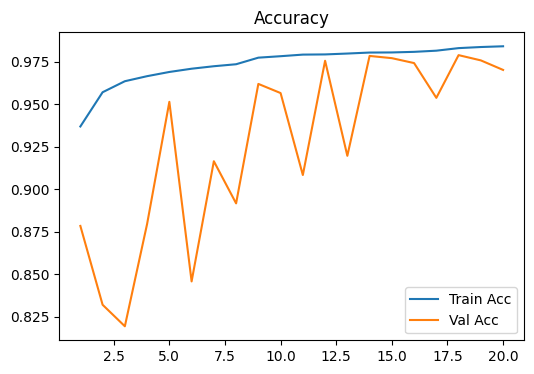

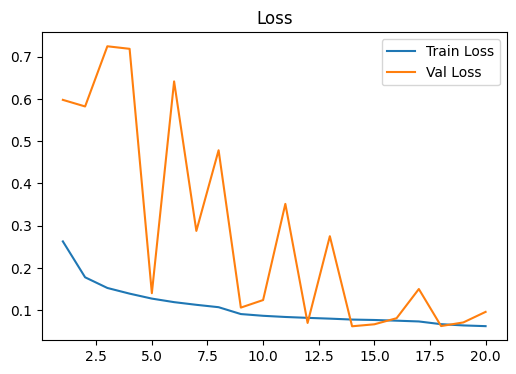

1406/1406 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step


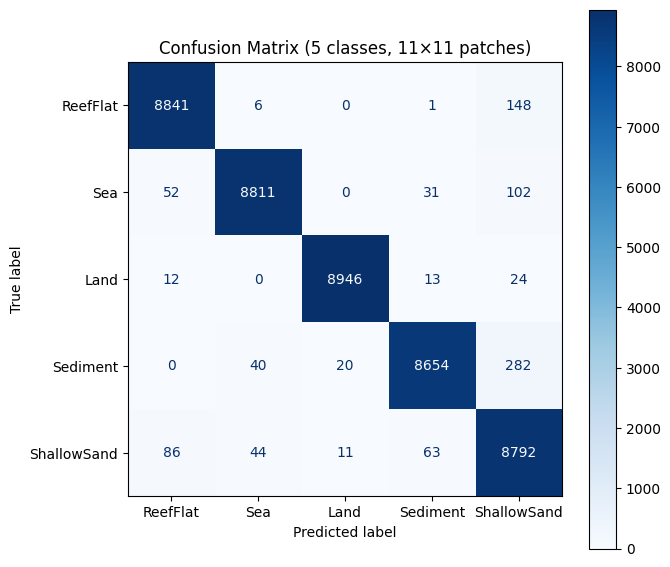

Saved model to: /content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11px/reef_cnn_11x11.h5


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import json
from codecarbon import EmissionsTracker

# ─── Paths ─────────────────────────────────────────────────────────────────────
TRAIN_DATA_DIR = '/content/drive/MyDrive/AI4EO/Final_Project/TrainingData/test_run'
CONFIG_PATH    = '/content/drive/MyDrive/AI4EO/Final_Project/config_reef.json'
MODEL_DIR      = '/content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11px'
os.makedirs(MODEL_DIR, exist_ok=True)

# ─── Hyperparameters ──────────────────────────────────────────────────────────
PATCH_SIZE       = 11
BATCH_SIZE       = 128
EPOCHS           = 50
VALIDATION_SPLIT = 0.1
PATIENCE_ES      = 6
PATIENCE_LR      = 3
MIN_LR           = 1e-6
INITIAL_LR       = 1e-3
EPS              = 1e-6

# ─── Load config for class names ───────────────────────────────────────────────
with open(CONFIG_PATH) as f:
    cfg = json.load(f)
classes     = cfg['classes']
num_classes = len(classes)
class_names = [c['name'] for c in classes]

# ─── Load 11×11 training data ──────────────────────────────────────────────────
X_train = np.load(os.path.join(TRAIN_DATA_DIR, f'X{PATCH_SIZE}_train.npy'))  # (N,11,11,4)
X_test  = np.load(os.path.join(TRAIN_DATA_DIR, f'X{PATCH_SIZE}_test.npy'))
y_train = np.load(os.path.join(TRAIN_DATA_DIR, 'y_train.npy'))
y_test  = np.load(os.path.join(TRAIN_DATA_DIR, 'y_test.npy'))

print(f"Data shapes: X_train={X_train.shape}, X_test={X_test.shape}, "
      f"y_train={y_train.shape}, y_test={y_test.shape}")

# ─── Append NDWI channel ──────────────────────────────────────────────────────
def append_ndwi(X):
    green = X[...,1].astype(float)
    nir   = X[...,3].astype(float)
    ndwi  = (green - nir) / (green + nir + EPS)
    return np.concatenate([X, ndwi[...,None]], axis=-1)

X_train = append_ndwi(X_train)  # now (N,11,11,5)
X_test  = append_ndwi(X_test)

# ─── Compute class weights (balance + extra penalty) ─────────────────────────
cw = class_weight.compute_class_weight('balanced',
                                       classes=np.arange(num_classes),
                                       y=y_train)
class_weight_dict = dict(enumerate(cw))

reef_i    = class_names.index('ReefFlat')
shallow_i = class_names.index('ShallowSand')
class_weight_dict[reef_i]    *= 2.0
class_weight_dict[shallow_i] *= 2.0

print("Class weight dict:", class_weight_dict)

# ─── Build the model ──────────────────────────────────────────────────────────
input_ch = X_train.shape[-1]  # 5
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  input_shape=(PATCH_SIZE, PATCH_SIZE, input_ch)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),  # 11→5

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # Classifier head
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# ─── Callbacks ────────────────────────────────────────────────────────────────
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE_ES,
                                     restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.5,
                                         patience=PATIENCE_LR,
                                         min_lr=MIN_LR)

# ─── TRAIN with CodeCarbon ─────────────────────────────────────────────────────
tracker = EmissionsTracker(
    project_name="reef_training",
    output_dir="//content/drive/MyDrive/AI4EO/Final_Project/Emissions_Log"
)

# Start tracking just before the heavy compute
tracker.start()

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

# Stop tracking right after .fit() ends
tracker.stop()

# ─── Retrieve the EmissionsData object ────────────────────────────────────────
emissions_data = tracker.final_emissions_data

# Access attributes instead of indexing
print(f"\n▶ Training CO₂ emissions (kg):     {emissions_data.emissions:.5f}")
print(f"▶ Energy consumed (kWh):           {emissions_data.energy_consumed:.5f}")
print(f"▶ Average CPU power (W):           {emissions_data.cpu_power:.2f}")
print(f"▶ Average GPU power (W):           {getattr(emissions_data, 'gpu_power', 0.0):.2f}\n")

# ─── Plot training curves ──────────────────────────────────────────────────────
def plot_curves(h):
    epochs = range(1, len(h.history['loss']) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, h.history['accuracy'],    label='Train Acc')
    plt.plot(epochs, h.history['val_accuracy'],label='Val Acc')
    plt.title('Accuracy'); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, h.history['loss'],    label='Train Loss')
    plt.plot(epochs, h.history['val_loss'],label='Val Loss')
    plt.title('Loss'); plt.legend(); plt.show()

plot_curves(history)

# ─── Evaluate & confusion matrix ───────────────────────────────────────────────
y_pred = np.argmax(model.predict(X_test), axis=1)
cm     = confusion_matrix(y_test, y_pred, labels=list(range(num_classes)))
disp   = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix ({num_classes} classes, {PATCH_SIZE}×{PATCH_SIZE} patches)')
plt.show()

# ─── Save the model ────────────────────────────────────────────────────────────
model_path = os.path.join(MODEL_DIR, f'reef_cnn_{PATCH_SIZE}x{PATCH_SIZE}.h5')
model.save(model_path)
print("Saved model to:", model_path)

# Rollout of our CNN

We now run inference on the full Sentinel-2 scene by sliding a non-overlapping 11×11 patch window across the image, appending NDWI to each patch, and predicting reef class probabilities. The output is upsampled to image resolution and filtered using an NDWI mask to isolate confident, shallow-water reef regions for visualisation.

### Training Tile

Running inference: 100%|██████████| 973/973 [06:11<00:00,  2.62it/s]


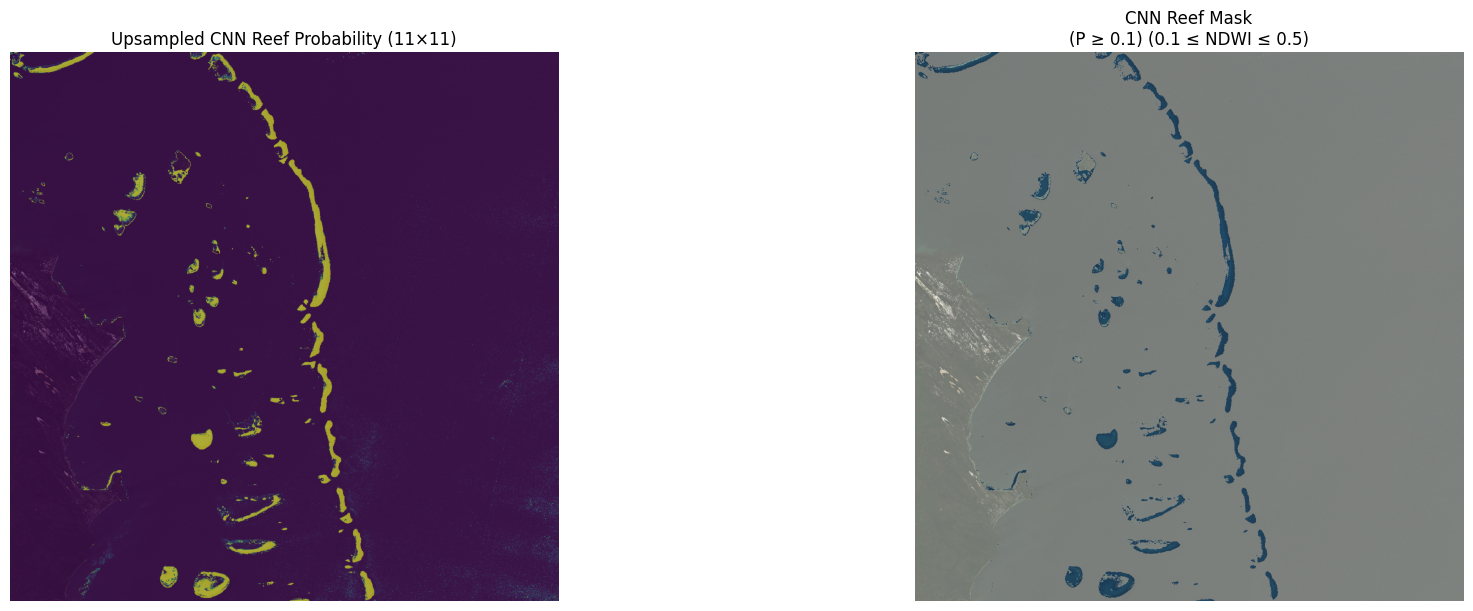

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm
import math

# ─── SETTINGS ─────────────────────────────────────────────────────────────
MODEL_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11px/reef_cnn_11x11.h5'
IMAGE_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube.npy'
PATCH_SIZE  = 11
BATCH_SIZE  = 1024   # how many patches to predict at once
P_THRESH    = 0.1
NDWI_MIN    = 0.1
NDWI_MAX    = 0.5
MAX_PREVIEW = 1024
EPS         = 1e-6

# ─── LOAD MODEL & IMAGE ─────────────────────────────────────────────────────
model = load_model(MODEL_PATH)
cube  = np.load(IMAGE_PATH)      # (H, W, 4)
H, W, _ = cube.shape

# ─── PRE-COMPUTE NDWI MAP ───────────────────────────────────────────────────
green    = cube[...,1].astype(np.float32)
nir      = cube[...,3].astype(np.float32)
ndwi_map = (green - nir) / (green + nir + EPS)

# ─── SET UP GRID OF NON-OVERLAPPING PATCH STARTS ────────────────────────────
ys = np.arange(0, H - PATCH_SIZE + 1, PATCH_SIZE)
xs = np.arange(0, W - PATCH_SIZE + 1, PATCH_SIZE)
h_s, w_s = len(ys), len(xs)
n_patches = h_s * w_s

n_batches = math.ceil(n_patches / BATCH_SIZE)
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

for batch_idx in tqdm(range(n_batches), desc="Running inference"):
    start = batch_idx * BATCH_SIZE
    end   = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # build your batch as before…
    batch = np.empty((batch_size, PATCH_SIZE, PATCH_SIZE, 5), dtype=np.float32)
    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]
        p4 = cube[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :].astype(np.float32)
        p_ndwi = ndwi_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE][...,None]
        batch[i,:,:,:4] = p4
        batch[i,:,:,4]   = p_ndwi[...,0]

    # turn on Keras’s bar if you like (verbose=1), or keep verbose=0
    preds = model.predict(batch, batch_size=batch_size, verbose=0)
    reef_prob_small.flat[start:end] = preds[:, 0]

    del batch, preds

# ─── STREAMED INFERENCE ─────────────────────────────────────────────────────
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

for start in range(0, n_patches, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # allocate batch
    batch = np.empty((batch_size, PATCH_SIZE, PATCH_SIZE, 5), dtype=np.float32)

    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]

        # load 4-band patch
        p4 = cube[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :].astype(np.float32)
        # load ndwi patch
        p_ndwi = ndwi_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE][..., None]

        batch[i, :, :, :4] = p4
        batch[i, :, :, 4]  = p_ndwi[..., 0]

    # predict and store only the “reef” class prob (class 0)
    preds = model.predict(batch, batch_size=batch_size, verbose=0)
    reef_prob_small.flat[start:end] = preds[:, 0]

    # free memory explicitly (optional)
    del batch, preds

# ─── UPSAMPLE TO FULL RESOLUTION ────────────────────────────────────────────
big_prob = np.kron(
    reef_prob_small.reshape(h_s, w_s),
    np.ones((PATCH_SIZE, PATCH_SIZE), dtype=np.float32)
)[:H, :W]

# ─── NDWI‐ONLY MASK ─────────────────────────────────────────────────────────
ndwi_mask = (ndwi_map >= NDWI_MIN) & (ndwi_map <= NDWI_MAX)

# ─── CROP TO MATCH big_prob’s SHAPE ─────────────────────────────────────────
h_bp, w_bp = big_prob.shape
ndwi_crop = ndwi_mask[:h_bp, :w_bp]

# ─── APPLY NDWI FILTER TO CNN PROBS ────────────────────────────────────────
final_cnn = (big_prob >= P_THRESH) & ndwi_crop

# ─── BUILD RGB BACKDROP ────────────────────────────────────────────────────
rgb = np.stack([
    (cube[...,2] - cube[...,2].min())/np.ptp(cube[...,2]),
    (cube[...,1] - cube[...,1].min())/np.ptp(cube[...,1]),
    (cube[...,0] - cube[...,0].min())/np.ptp(cube[...,0]),
], axis=-1)
rgb_crop = rgb[:H, :W]

# ─── LIGHTWEIGHT PLOTTING ─────────────────────────────────────────────────
scale = min(1.0, MAX_PREVIEW / max(H, W))
step  = max(1, int(1/scale))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

ax1.imshow(rgb_crop[::step,::step], vmin=0, vmax=1)
ax1.imshow(big_prob[::step,::step], cmap='viridis', alpha=0.6)
ax1.set_title("Upsampled CNN Reef Probability (11×11)")
ax1.axis('off')

ax2.imshow(rgb_crop[::step,::step], vmin=0, vmax=1)
ax2.imshow(final_cnn[::step,::step], cmap='GnBu', alpha=0.4)
ax2.set_title(f"CNN Reef Mask\n(P ≥ {P_THRESH}) ({NDWI_MIN} ≤ NDWI ≤ {NDWI_MAX})")
ax2.axis('off')

plt.show()

### Unseen Tile

Note here that regions affected by cloud have been removed from classification.

Running inference: 100%|██████████| 487/487 [03:00<00:00,  2.69it/s]


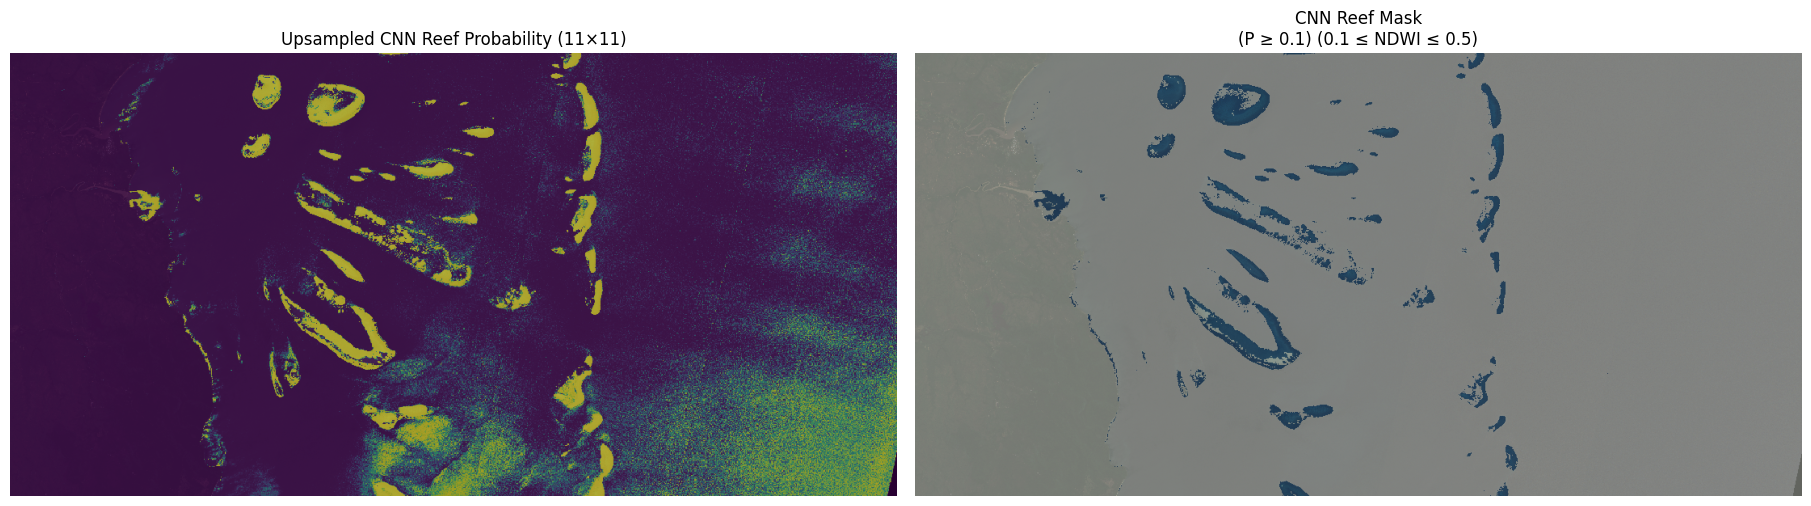

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm
import math

# ─── SETTINGS ─────────────────────────────────────────────────────────────
MODEL_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11px/reef_cnn_11x11.h5'
IMAGE_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube_gen.npy'
PATCH_SIZE  = 11
BATCH_SIZE  = 1024   # how many patches to predict at once
P_THRESH    = 0.1
NDWI_MIN    = 0.1
NDWI_MAX    = 0.5
MAX_PREVIEW = 1024
EPS         = 1e-6

# ─── LOAD & CROP IMAGE ──────────────────────────────────────────────────────
model = load_model(MODEL_PATH)
cube  = np.load(IMAGE_PATH)      # (H, W, 4)
H, W, _ = cube.shape

# drop bottom half (clouds/artifacts)
H2 = H // 2
cube = cube[:H2, :, :]
H, _, _ = cube.shape

# ─── PRE-COMPUTE NDWI MAP ───────────────────────────────────────────────────
green    = cube[...,1].astype(np.float32)
nir      = cube[...,3].astype(np.float32)
ndwi_map = (green - nir) / (green + nir + EPS)

# ─── SET UP GRID OF NON-OVERLAPPING PATCH STARTS ────────────────────────────
ys = np.arange(0, H - PATCH_SIZE + 1, PATCH_SIZE)
xs = np.arange(0, W - PATCH_SIZE + 1, PATCH_SIZE)
h_s, w_s = len(ys), len(xs)
n_patches = h_s * w_s

n_batches = math.ceil(n_patches / BATCH_SIZE)
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

for batch_idx in tqdm(range(n_batches), desc="Running inference"):
    start = batch_idx * BATCH_SIZE
    end   = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # build your batch as before…
    batch = np.empty((batch_size, PATCH_SIZE, PATCH_SIZE, 5), dtype=np.float32)
    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]
        p4 = cube[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :].astype(np.float32)
        p_ndwi = ndwi_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE][...,None]
        batch[i,:,:,:4] = p4
        batch[i,:,:,4]   = p_ndwi[...,0]

    # turn on Keras’s bar if you like (verbose=1), or keep verbose=0
    preds = model.predict(batch, batch_size=batch_size, verbose=0)
    reef_prob_small.flat[start:end] = preds[:, 0]

    del batch, preds

# ─── STREAMED INFERENCE ─────────────────────────────────────────────────────
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

for start in range(0, n_patches, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # allocate batch
    batch = np.empty((batch_size, PATCH_SIZE, PATCH_SIZE, 5), dtype=np.float32)

    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]

        # load 4-band patch
        p4 = cube[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :].astype(np.float32)
        # load ndwi patch
        p_ndwi = ndwi_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE][..., None]

        batch[i, :, :, :4] = p4
        batch[i, :, :, 4]  = p_ndwi[..., 0]

    # predict and store only the “reef” class prob (class 0)
    preds = model.predict(batch, batch_size=batch_size, verbose=0)
    reef_prob_small.flat[start:end] = preds[:, 0]

    # free memory explicitly (optional)
    del batch, preds

# ─── UPSAMPLE TO FULL RESOLUTION ────────────────────────────────────────────
big_prob = np.kron(
    reef_prob_small.reshape(h_s, w_s),
    np.ones((PATCH_SIZE, PATCH_SIZE), dtype=np.float32)
)[:H, :W]

# ─── NDWI‐ONLY MASK ─────────────────────────────────────────────────────────
ndwi_mask = (ndwi_map >= NDWI_MIN) & (ndwi_map <= NDWI_MAX)

# ─── CROP TO MATCH big_prob’s SHAPE ─────────────────────────────────────────
h_bp, w_bp = big_prob.shape
ndwi_crop = ndwi_mask[:h_bp, :w_bp]

# ─── APPLY NDWI FILTER TO CNN PROBS ────────────────────────────────────────
final_cnn = (big_prob >= P_THRESH) & ndwi_crop

# ─── BUILD RGB BACKDROP ────────────────────────────────────────────────────
rgb = np.stack([
    (cube[...,2] - cube[...,2].min())/np.ptp(cube[...,2]),
    (cube[...,1] - cube[...,1].min())/np.ptp(cube[...,1]),
    (cube[...,0] - cube[...,0].min())/np.ptp(cube[...,0]),
], axis=-1)
rgb_crop = rgb[:H, :W]

# ─── LIGHTWEIGHT PLOTTING ─────────────────────────────────────────────────
scale = min(1.0, MAX_PREVIEW / max(H, W))
step  = max(1, int(1/scale))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

ax1.imshow(rgb_crop[::step,::step], vmin=0, vmax=1)
ax1.imshow(big_prob[::step,::step], cmap='viridis', alpha=0.6)
ax1.set_title("Upsampled CNN Reef Probability (11×11)")
ax1.axis('off')

ax2.imshow(rgb_crop[::step,::step], vmin=0, vmax=1)
ax2.imshow(final_cnn[::step,::step], cmap='GnBu', alpha=0.4)
ax2.set_title(f"CNN Reef Mask\n(P ≥ {P_THRESH}) ({NDWI_MIN} ≤ NDWI ≤ {NDWI_MAX})")
ax2.axis('off')

plt.show()

# Extracting Ground Truth from the ACA

To create a ground truth mask for evaluation, we extract and rasterize selected geomorphic classes from a vector shapefile of the reef system (focusing on reef flats and lagoons) and align them spatially using the metadata (CRS, dimensions, transform) from a reference Sentinel-2 .jp2 image, downloaded earlier in the notebook.

The shapefile is sourced from the Allen Coral Atlas (ACA), a high-quality open-access platform providing detailed geomorphic reef classifications. While the data is free to use for research, creating an ACA account is required to access and download the shapefiles.

The resulting binary masks are cropped and saved as .npy arrays for efficient integration into our model validation workflow.

In [ ]:
import os
import fiona
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np

# ─── CONFIG ────────────────────────────────────────────────────────────────
GPKG_PATH = '/content/drive/MyDrive/AI4EO/Final_Project/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Geomorphic-Map/geomorphic.gpkg'

# list of (reference JP2, output .npy, crop_bottom_half)
mask_jobs = [
    (
        '/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE/GRANULE/L2A_T55LCD_A010095_20190211T003704/IMG_DATA/R10m/T55LCD_20190211T003709_B03_10m.jp2',
        '/content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_full.npy',
        False
    ),
    (
        '/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE/GRANULE/L2A_T55LCC_A010095_20190211T003704/IMG_DATA/R10m/T55LCC_20190211T003709_B03_10m.jp2',
        '/content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_cropped.npy',
        True
    )
]

# ─── 1) Load entire Geomorphic vector once ─────────────────────────────────
layers = fiona.listlayers(GPKG_PATH)
reef_gdf = gpd.read_file(GPKG_PATH, layer=layers[0])
print(f"Loaded {len(reef_gdf)} features from layer '{layers[0]}'")

#  ─── 1a) Inspect unique classes (already known, but good to confirm) ───────
unique_classes = reef_gdf['class'].dropna().unique()
print("All available classes in 'class' column:")
for uc in unique_classes:
    print(f"  • {uc!r}")

# ─── 1b) Define which classes to keep (Reef Flat Class) ─────────────────
keep_classes = [
    'Reef Crest',
    'Outer Reef Flat',
    'Inner Reef Flat',
    'Terrestrial Reef Flat',
    'Plateau',
    'Deep Lagoon',
    'Shallow Lagoon'
]

print("\nFiltering to keep only these classes:")
for kc in keep_classes:
    print(f"  • {kc!r}")

# Filter the GeoDataFrame
filtered_gdf = reef_gdf[reef_gdf['class'].isin(keep_classes)].copy()
print(f"\nAfter filtering, {len(filtered_gdf)} features remain (out of {len(reef_gdf)})")

# ─── 2) Loop over each mask job and rasterize only filtered classes ────────
for jp2_path, out_npy, crop_half in mask_jobs:
    # Open JP2 to get CRS, transform & dimensions
    with rasterio.open(jp2_path) as src:
        transform = src.transform
        height, width = src.height, src.width
        dst_crs = src.crs

    # Reproject filtered vector if needed
    if filtered_gdf.crs != dst_crs:
        filtered_gdf = filtered_gdf.to_crs(dst_crs)

    # Prepare shapes iterable: each (geometry, 1) for the filtered classes
    shapes = ((geom, 1) for geom in filtered_gdf.geometry)

    # Rasterize: pixels inside any filtered polygon → 1; else 0
    mask_full = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

    # Crop bottom half
    if crop_half:
        mask = mask_full[: (height // 2), :]
    else:
        mask = mask_full

    # Save to .npy
    os.makedirs(os.path.dirname(out_npy), exist_ok=True)
    np.save(out_npy, mask)
    print(f"→ Saved filtered‐classes mask to {out_npy}, shape = {mask.shape}")

Loaded 441627 features from layer 'Great Barrier Reef and Torres Strait'
All available classes in 'class' column:
  • 'Back Reef Slope'
  • 'Reef Slope'
  • 'Reef Crest'
  • 'Outer Reef Flat'
  • 'Sheltered Reef Slope'
  • 'Deep Lagoon'
  • 'Shallow Lagoon'
  • 'Inner Reef Flat'
  • 'Plateau'
  • 'Terrestrial Reef Flat'

Filtering to keep only these classes:
  • 'Reef Crest'
  • 'Outer Reef Flat'
  • 'Inner Reef Flat'
  • 'Terrestrial Reef Flat'
  • 'Plateau'
  • 'Deep Lagoon'
  • 'Shallow Lagoon'

After filtering, 235795 features remain (out of 441627)
→ Saved filtered‐classes mask to /content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_full.npy, shape = (10980, 10980)
→ Saved filtered‐classes mask to /content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_cropped.npy, shape = (5490, 10980)


# Model Evaluation

We evaluate the performance of our CNN reef classifier by comparing its predictions for the unseen region to a ground truth mask from the ACA. Patch-wise reef probabilities are upsampled, thresholded, and aligned with the ACA mask to compute a confusion matrix, classification report. We also provide visual overlays highlighting true positives (green), false positives (blue), and false negatives (red).

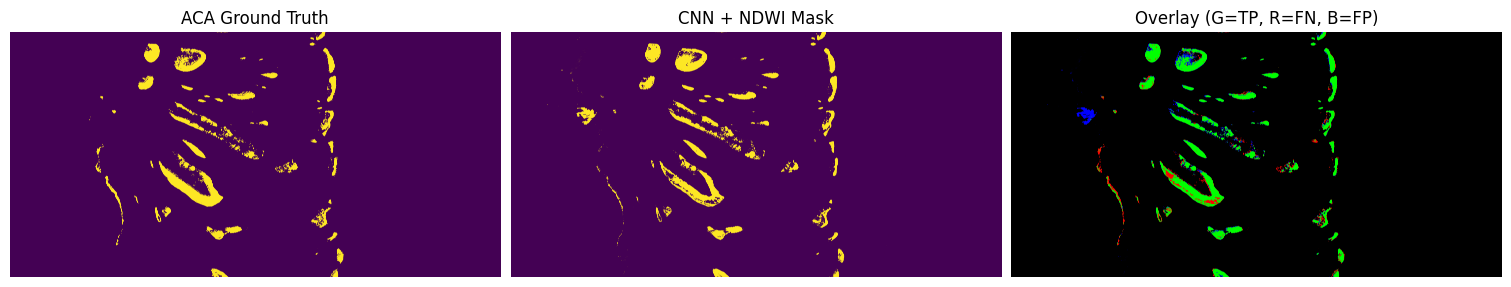

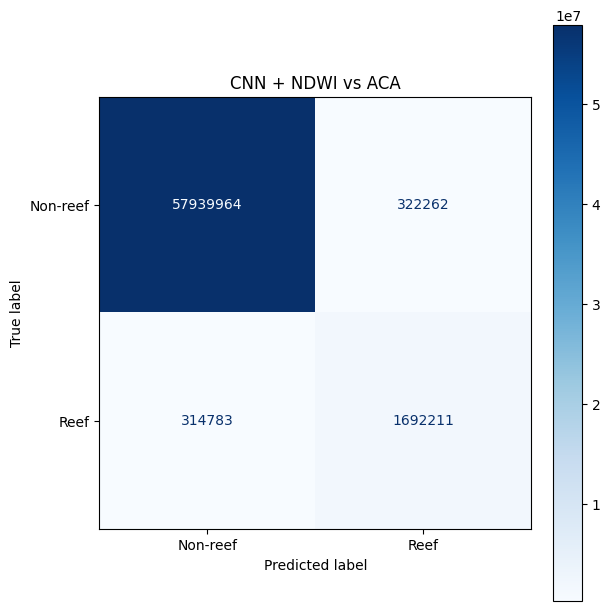

=== Classification Report ===

              precision    recall  f1-score   support

    Non-reef       0.99      0.99      0.99  58262226
        Reef       0.84      0.84      0.84   2006994

    accuracy                           0.99  60269220
   macro avg       0.92      0.92      0.92  60269220
weighted avg       0.99      0.99      0.99  60269220



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ─── Helper to load your CNN (Keras or ONNX) ───────────────────────────────
def load_cnn_model(path):
    try:
        from tensorflow.keras.models import load_model
        return load_model(path)
    except:
        try:
            from keras.models import load_model
            return load_model(path)
        except:
            import onnxruntime as ort
            sess = ort.InferenceSession(path)
            # assume the ONNX model expects 'input' as the input name
            return lambda x, **kwargs: sess.run(None, {'input': x})[0]

# ─── Paths & settings ─────────────────────────────────────────────────────
CUBE_PATH   = '/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube_gen.npy'
ACA_MASK    = '/content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_cropped.npy'
MODEL_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11px/reef_cnn_11x11.h5'

PATCH       = 11        # patch height & width
NDWI_MIN    = 0.1       # shallow‐water lower bound
P_THRESH    = 0.1       # probability threshold for “reef”
EPS         = 1e-6
BATCH_SIZE  = 1024      # how many patches to process at once (tune this to fit RAM)

# ─── 1) Load data & compute NDWI map ──────────────────────────────────────
cube      = np.load(CUBE_PATH)                 # shape = (H, W, 4)
aca_mask  = np.load(ACA_MASK).astype(bool)     # shape = (H₂, W₂)
H, W, _   = cube.shape

# compute NDWI map once (float32)
green     = cube[...,1].astype(np.float32)
nir       = cube[...,3].astype(np.float32)
ndwi_map  = (green - nir) / (green + nir + EPS)

# shallow‐water boolean mask (H×W)
shallow_mask = (ndwi_map >= NDWI_MIN)

# ─── 2) Prepare “grid” of non‐overlapping PATCH blocks ────────────────────
ys = np.arange(0, H - PATCH + 1, PATCH)
xs = np.arange(0, W - PATCH + 1, PATCH)
h_s, w_s = len(ys), len(xs)
n_patches = h_s * w_s

# Placeholder for patch‐level probabilities (coarse grid)
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

# ─── 3) CNN inference in batches (no giant pts array) ────────────────────
model = load_cnn_model(MODEL_PATH)

# We’ll iterate over all patch indices [0 .. n_patches-1], in chunks of BATCH_SIZE
for start in range(0, n_patches, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # Allocate a single batch array of shape (batch_size, PATCH, PATCH, 5)
    batch = np.zeros((batch_size, PATCH, PATCH, 5), dtype=np.float32)

    # Fill in the batch with (4 RGB+NIR bands) + (1 NDWI channel)
    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]

        # 4‐band slice
        patch_4 = cube[y:y+PATCH, x:x+PATCH, :].astype(np.float32)  # shape = (PATCH, PATCH, 4)
        # NDWI slice
        patch_ndwi = ndwi_map[y:y+PATCH, x:x+PATCH].astype(np.float32)  # shape = (PATCH, PATCH)

        batch[i, :, :, :4] = patch_4
        batch[i, :, :, 4]  = patch_ndwi

    # Run inference on this batch; preds[:,0] is probability of “reef”
    preds = model.predict(batch, batch_size=batch_size, verbose=0)  # shape = (batch_size, 1) or (batch_size, 2)
    reef_prob_small.flat[start:end] = preds[:, 0].astype(np.float32)

    # Free the batch & preds right away
    del batch, preds

# ─── 4) Upsample patch‐level probs to full H×W “big_prob” ─────────────────
big_prob = np.kron(
    reef_prob_small,
    np.ones((PATCH, PATCH), dtype=np.float32)
)
# If H or W aren’t exact multiples of PATCH, crop down to exactly (H, W)
big_prob = big_prob[:H, :W]

# ─── 5) Gate by NDWI (≥ NDWI_MIN) and by probability threshold ───────────
shallow_crop = shallow_mask[:big_prob.shape[0], :big_prob.shape[1]]  # <--- here
final_cnn    = (big_prob >= P_THRESH) & shallow_crop

# ─── 6) Crop both prediction & ACA mask to a common footprint ────────────
common_h = min(final_cnn.shape[0], aca_mask.shape[0])
common_w = min(final_cnn.shape[1], aca_mask.shape[1])

gt   = aca_mask[:common_h, :common_w]
pred = final_cnn[:common_h, :common_w]

# ─── 7) Visualize: ACA GT vs. CNN+NDWI vs. overlay ────────────────────────
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

ax1.imshow(gt,   cmap='viridis')
ax1.set_title('ACA Ground Truth')
ax1.axis('off')

ax2.imshow(pred, cmap='viridis')
ax2.set_title('CNN + NDWI Mask')
ax2.axis('off')

# Build an RGB overlay: G = True Positive, R = False Negative, B = False Positive
overlay = np.zeros((common_h, common_w, 3), dtype=np.float32)
overlay[(gt & pred), 1]  = 1.0   # True Positives → green
overlay[(gt & ~pred), 0] = 1.0   # False Negatives → red
overlay[(~gt & pred), 2] = 1.0   # False Positives → blue

ax3.imshow(overlay)
ax3.set_title('Overlay (G=TP, R=FN, B=FP)')
ax3.axis('off')

plt.show()

# ─── 8) Plot confusion matrix and classification report ────────────────
y_true = gt.ravel().astype(int)
y_pred = pred.ravel().astype(int)

cm      = confusion_matrix(y_true, y_pred, labels=[0,1])
disp    = ConfusionMatrixDisplay(cm, display_labels=['Non-reef','Reef'])

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('CNN + NDWI vs ACA')
plt.show()

print("=== Classification Report ===\n")
print(classification_report(
    y_true, y_pred, target_names=['Non-reef','Reef']
))

# Conclusions

The results from the confusion matrix show that our NDWI + CNN workflow performs strongly overall, achieving an accuracy of 99% across over 60 million pixels, with an F1-score of 0.84 for the reef class. This performance reflects a complementary relationship between the two components: the NDWI mask effectively removes deep water and terrestrial regions that often confuse the CNN, while the CNN provides spatial and spectral nuance that NDWI alone lacks—particularly in distinguishing reef structures from similarly reflective features like sediment and turbid sand.

To illustrate this, we plot our NDWI mask with our ACA overlayed, and do the same with our CNN classification. See below:

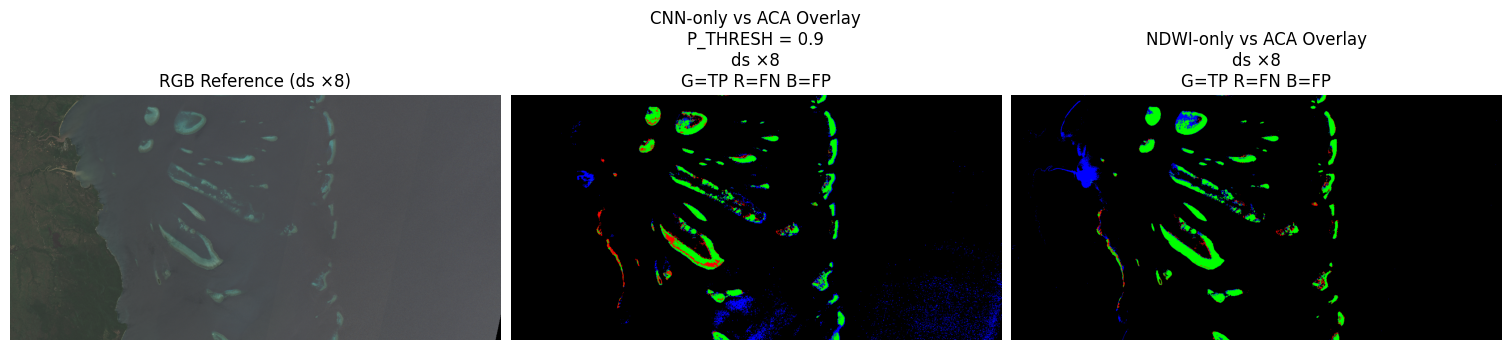

In [ ]:
# ─── Downsample factor ───────────────────────────────────────────────────────
factor = 8  # keep every 4th pixel (adjust as needed)

# ─── Adjustable probability threshold for CNN ─────────────────────────────────
P_THRESH = 0.9  # adjust this value as needed

# ─── 1) Prepare RGB reference (crop + downsample) ────────────────────────────
# Assumes cube has shape (H, W, 4) with bands [Blue, Green, Red, NIR].
rgb_full = cube[..., :3]  # [Blue, Green, Red]
# Permute to [R, G, B] for display
rgb_display = np.stack([rgb_full[..., 2], rgb_full[..., 1], rgb_full[..., 0]], axis=-1)
rgb_ref = rgb_display[:common_h, :common_w]  # (common_h, common_w, 3)

# Downsample by slicing every 'factor' pixels
rgb_ref_ds = rgb_ref[::factor, ::factor]
# Normalize for display
rgb_ref_ds = rgb_ref_ds / np.max(rgb_ref_ds)

# ─── 2) CNN-only classification (threshold big_prob → crop + downsample) ─────
cnn_only_pred_full = (big_prob >= P_THRESH)  # boolean array (H, W)
cnn_only_pred = cnn_only_pred_full[:common_h, :common_w]  # (common_h, common_w)
cnn_ds = cnn_only_pred[::factor, ::factor]  # (h_ds, w_ds)

# ─── 3) NDWI-only classification (crop + downsample) ──────────────────────────
ndwi_pred_full = shallow_mask  # boolean array (H, W)
ndwi_only_pred = ndwi_pred_full[:common_h, :common_w]  # (common_h, common_w)
ndwi_ds = ndwi_only_pred[::factor, ::factor]  # (h_ds, w_ds)

# ─── 4) Downsample GT mask ────────────────────────────────────────────────────
gt_ds = gt[:common_h, :common_w][::factor, ::factor]  # ground truth (h_ds, w_ds)

# ─── 5) Build TP / FN / FP overlay for CNN-only vs. ACA (downsampled) ─────────
h_ds, w_ds = gt_ds.shape
overlay_cnn_ds = np.zeros((h_ds, w_ds, 3), dtype=np.float32)
# True Positives (CNN & GT) → green
overlay_cnn_ds[(gt_ds & cnn_ds), 1] = 1.0
# False Negatives (GT=1 & CNN=0) → red
overlay_cnn_ds[(gt_ds & ~cnn_ds), 0] = 1.0
# False Positives (CNN=1 & GT=0) → blue
overlay_cnn_ds[(~gt_ds & cnn_ds), 2] = 1.0

# ─── 6) Build TP / FN / FP overlay for NDWI-only vs. ACA (downsampled) ───────
overlay_ndwi_ds = np.zeros((h_ds, w_ds, 3), dtype=np.float32)
# True Positives (NDWI & GT) → green
overlay_ndwi_ds[(gt_ds & ndwi_ds), 1] = 1.0
# False Negatives (GT=1 & NDWI=0) → red
overlay_ndwi_ds[(gt_ds & ~ndwi_ds), 0] = 1.0
# False Positives (NDWI=1 & GT=0) → blue
overlay_ndwi_ds[(~gt_ds & ndwi_ds), 2] = 1.0

# ─── 7) Plot: downsampled RGB, CNN vs ACA overlay, and NDWI vs ACA overlay ────
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# RGB reference
ax1.imshow(rgb_ref_ds)
ax1.set_title(f'RGB Reference (ds ×{factor})')
ax1.axis('off')

# CNN vs ACA overlay
ax2.imshow(overlay_cnn_ds)
ax2.set_title(f'CNN-only vs ACA Overlay\nP_THRESH = {P_THRESH}\nds ×{factor}\nG=TP R=FN B=FP')
ax2.axis('off')

# NDWI vs ACA overlay
ax3.imshow(overlay_ndwi_ds)
ax3.set_title(f'NDWI-only vs ACA Overlay\nds ×{factor}\nG=TP R=FN B=FP')
ax3.axis('off')

plt.show()

We can see that our CNN better at disregarding reflective features like sediment (inspect the top left of our images, where we see runoff from a river into the ocean). However it struggles with deeper waters (see the bottom middle section of our CNN overlay), where the NDWI mask is more effective. This highlights the benefits of such a dual classification, if training time or compute is of concern.  

On this dataset, the CNN achieves both recall and precision of 0.88. In contrast, the NDWI-based mask, when inspected visually, tends to miss a larger fraction of reef pixels and also includes more non-reef areas. In a monitoring context, we prefer the CNN’s bias toward higher recall: missing true reefs (false negatives) is harder to correct later than over-segmenting them, and any residual false positives can be pruned in post-processing.

It should be noted that this model was trained specifically on labelled data from the Great Barrier Reef, and further work is needed to assess generalisation to other reef systems. In particular, expanding the training dataset and using CNN architectures that incorporate larger spatial context (beyond the current 11×11 patch size) could improve the model’s ability to resolve more complex geomorphic transitions.

It is also worth noting that the ACA classifies reef geomorphology using Random Forest classifiers trained on multi-source remote sensing data, as well as extensive post-processing, including manual correction by regional experts. While that approach leverages extensive feature engineering, our end-to-end CNN + NDWI pipeline offers a lightweight and scalable alternative, serving as a proof of concept for real-time or large-scale reef classification using publicly available imagery and minimal preprocessing.

# Environmental Cost of Training

Given the rising energy demands of machine learning workflows, it's important to quantify their environmental footprint, especially in research projects where scalability and cloud computing are involved.

In the cell below, we estimate the environmental impact of training our model using CodeCarbon. Since Google Colab runs in a cloud environment, the library’s automatic location detection may be inaccurate. To address this, we manually calculate emissions using the average CO₂ output per kilowatt-hour (kWh) for the UK.
If you're based in a different region, simply adjust this value to reflect your local energy mix.

In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/AI4EO/Final_Project/Emissions_Log/emissions.csv"
df = pd.read_csv(csv_path)

# 3. Display available columns
print("Available columns in CSV:")
print(df.columns.tolist(), "\n")

# 4. Identify energy column and compute carbon assuming UK grid (0.2 kg CO₂/kWh)
energy_col = "energy_consumed"  # adjust if different
carbon_intensity = 0.20         # kg CO₂ per kWh (UK average)

df["carbon_kg"] = df[energy_col] * carbon_intensity

# 5. Show per-run emissions and total summary
result = df[["timestamp", energy_col, "carbon_kg"]]
print("Computed per-run carbon emissions (kg CO₂):")
display(result)

total_energy = df[energy_col].sum()
total_carbon = df["carbon_kg"].sum()
print(f"\nTotal energy consumed across all runs: {total_energy:.5f} kWh")
print(f"Total carbon emissions (UK assumed):   {total_carbon:.5f} kg CO₂")

Available columns in CSV:
['timestamp', 'project_name', 'run_id', 'experiment_id', 'duration', 'emissions', 'emissions_rate', 'cpu_power', 'gpu_power', 'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed', 'country_name', 'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'os', 'python_version', 'codecarbon_version', 'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 'longitude', 'latitude', 'ram_total_size', 'tracking_mode', 'on_cloud', 'pue'] 

Computed per-run carbon emissions (kg CO₂):


timestamp  energy_consumed  carbon_kg
0  2025-06-01T22:08:45         0.090681   0.018136
1  2025-06-02T16:54:53         0.113790   0.022758


Total energy consumed across all runs: 0.20447 kWh
Total carbon emissions (UK assumed):   0.04089 kg CO₂


To contextualize this value, 0.02 kg of CO₂ per training session is roughly equivalent to running a 60W incandescent bulb for 12–15 minutes, or charging a smartphone once.

These emissions are remarkably low thanks to the lightweight CNN architecture, minimal training iterations, and use of freely available public satellite imagery. This reinforces the feasibility of deploying similar models in large-scale or low-resource settings with minimal environmental impact.

This estimate captures the compute-related emissions of model training only, using a single CNN training run on Google Colab. Preprocessing, data transfers, and storage-related emissions are not included, but are assumed to be negligible in comparison.
